# Setup

In [517]:
# load required packages

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import random

import getpass
import ndex2

import json
import cdapsutil
import pydot

# need ddot to parse the ontology
import ddot
from ddot import Ontology

import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

sns.set(font_scale=1.4)

sns.set_style('white')

sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.rcParams['svg.fonttype'] = 'none'

from tqdm import tqdm


from random import randint
from matplotlib.patches import Patch

from netcoloc import validation

import mygene
mg = mygene.MyGeneInfo()

## Functions

### Utilities

In [518]:
def _get_mp_graph(datafile="parsed_mp.txt"):
    mp_data = pd.read_csv(datafile, sep="\t", header=None)
    mp_data.head()
    mp_graph = nx.from_pandas_edgelist(mp_data, 0,1, create_using=nx.DiGraph)
    return mp_graph


def genes_per_node(MPO):
    node_order = MPO.topological_sorting(top_down=False)
    nodes = [i for i in node_order]
    results = {i: set(MPO.term_2_gene[i]) for i in node_order}
    genes = {i: set(MPO.gene_2_term[i]) for i in MPO.genes}
    while len(nodes) > 0:
        current = nodes.pop()
        children = MPO.parent_2_child[current]
        if len(children) > 0:
            for child in children:
                if child != current:
                    results[current] = results[current].union(results[child])
        for gene in results[current]:
            if gene not in genes.keys():
                genes[gene] = set([current])
            else:
                genes[gene] = genes[gene].union(set([current]))
        else:
            pass
    counts = {k: len(results[k]) for k in results.keys()}
    return counts, genes, results


def get_hits(network_results, data, p=0.01, OR=2, obs_min=3, total=10000, level= 3):
    mp_graph = _get_mp_graph()
    node_levels = nx.shortest_path_length(mp_graph, "MP:0000001")
    term_totals = data.loc[:, ("total", "description")]
    network_results = network_results.join(term_totals, how="left").drop_duplicates(subset=["OR", "total"])
    network_results = network_results.assign(depth=[node_levels[node] for node in network_results.index])
    try:
        hits = network_results.loc[network_results.obs >= obs_min].loc[network_results.OR >= OR]
        hits = hits.loc[network_results.q >= -1 * np.log10(p)]
        hits = hits.loc[network_results.total <= total]
        hits = hits.loc[network_results.depth >= level]
        # if there are parents in the hits then keep the parents and not the children
        subG = G.subgraph(hits.index)       
        keep_nodes = [node for node in subG.nodes if subG.in_degree[node]==0]
        #keep_nodes = [node for node in subG.nodes if (subG.in_degree[node] == 0 and subG.out_degree[node] == 0) or 
        #             (subG.in_degree[node] == 0 and subG.out_degree[node] > 1) or 
        #              (subG.out_degree[node] == 0 and subG.out_degree[subG.predecessors(node)[0]] == 1)]
        hits = hits.loc[keep_nodes]
        return hits
    except:
        print("no hits passing filters")
        
def num_to_mp(number):
    mp = "MP:"
    num = str(number)
    zeros_to_add = 7-len(num)
    mp = [mp] + ["0"] * zeros_to_add + [num]
    return "".join(mp)

def get_MP_description(term, MPO):
    return MPO.node_attr.loc[term].description


In [551]:
subG = get_hits(n, results)

In [554]:
[node for node in subG.nodes if (subG.in_degree[node] == 0 and subG.out_degree[node] > 1)]

['MP:0000759']

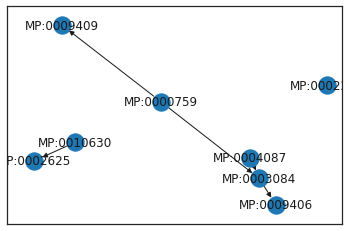

In [557]:
nx.draw_networkx(subG, with_labels=True
            )

In [230]:
[node for node in h.nodes if h.in_degree[node] == 0]

['MP:0001259', 'MP:0001264', 'MP:0001265', 'MP:0001256']

### Bar plotting

In [519]:
from statsmodels.stats.multitest import fdrcorrection
from matplotlib.patches import Patch


def plot_hbar_comparison(data_all, communities, mps, sig_level=0.05, community_names=None, sort_by=None, 
                         label_number="total", vert=20, color_idx=None, mp_graph=None, horz=10, save=False,
                        ylabel_groups=None, subplot_ax=None, drop_terms=True, correct_by_community=False):
    # Check inputs --------
    assert len(communities) == len(community_names), "Length of community names and communities must be equal"
    assert sig_level < 1.0 and sig_level > 0
    assert all([c in data_all.name.values for c in communities]), "Not all specified communities in data"
    
    if type(mps) == str and mp_graph is not None:
        mps = [node for node in nx.dfs_preorder_nodes(mp_graph, mps, 1) if node in data_all.index][1:]
    
    # Set up color variables --------
    #colors = [(0/255,158/255,115/255), (0/255,114/255,178/255), (230/255,175/255,0/255), (213/255,94/255, 0/255),
    #         (115/255, 44/255, 87/255)]

    colors = [(14/255,142/255,18/255), (3/255,67/255,223/255), (250/255,160/255,0/255), (181/255,7/255,72/255)]
    colors += [(201/255, 14/255, 169/255)]
    if len(communities) == 1:
        if color_idx is None:
            colors = [colors[1]]
        else:
            colors = [colors[color_idx]]
    elif color_idx is not None:
        colors = [colors[i] for i in color_idx]
    cmap = {comm:colors[c] for c, comm in enumerate(communities)}
    
    # Initialize plotting parameters --------
    height=((1-0.3)/len(communities))
    n_tests = len(communities) * len(mps)
    community_plot_data = []
    data = data_all.loc[mps]
    data = data.loc[data.name.isin(communities)]
    ## Perform P-value correction
    if len(data) < n_tests:
        diff = n_tests - len(data)
        if correct_by_community:
            grouped_data = data.groupby("name").apply(lambda grp: grp.assign(q=fdrcorrection(list(grp["OR_p"]) + [1 for _ in range(diff)], method="poscorr")[1][:(-1*diff)],
                                                                            q_hyper=fdrcorrection(list(grp["hyper_p"]) + [1 for _ in range(diff)], method="poscorr")[1][:(-1*diff)]))
            data = grouped_data.reset_index(drop=True, level=0)
        else:
            data["q"] = fdrcorrection(list(data["OR_p"]) + [1 for _ in range(diff)], method="poscorr")[1][:(-1*diff)]
            data["q_hyper"] = fdrcorrection(list(data["hyper_p"]) + [1 for _ in range(diff)], method="poscorr")[1][:(-1*diff)]
    else:
        if correct_by_community:
            grouped_data = data.groupby("name").apply(lambda grp: grp.assign(q=fdrcorrection(grp["OR_p"], method="poscorr")[1],
                                                                            q_hyper=fdrcorrection(grp["hyper_p"], method="poscorr")[1]))
            data = grouped_data.reset_index(drop=True, level=0)
        else:
            data["q"] = fdrcorrection(data["OR_p"], method="poscorr")[1]
            data["q_hyper"] = fdrcorrection(data["hyper_p"], method="poscorr")[1]
    
    # Sort the data
    if sort_by == "q":
        sort_data = data.loc[data.name==communities[0]].sort_values(by=["q", "OR_p"])
        if all([mp in sort_data.index for mp in mps]):
            mps = list(sort_data.index.values)
        else:
            if len(communities) == 1:
                mps = list(sort_data.index.values)
            else:
                extra_mps = [mp for mp in mps if mp not in sort_data.index ]
                mps = list(sort_data.index.values) + extra_mps
    elif sort_by == "observed":
        sort_data = data.loc[data.name==communities[0]].sort_values(by=["q"])
        sort_data = sort_data.sort_values(by=["observed"], ascending=False)
        if all([mp in sort_data.index for mp in mps]):
            mps = list(sort_data.index.values)
        else:
            if len(communities) == 1:
                mps = list(sort_data.index.values)
            else:
                extra_mps = [mp for mp in mps if mp not in sort_data.index ]
                mps = list(sort_data.index.values) + extra_mps
            
            
    for c, comm in enumerate(communities):
        plot_data = pd.DataFrame({"mps":mps, "community":comm, "left":1.0, "width":0.0, "upper":0, "lower":0, 
                                  "fill":[(1,1,1)], "hatch":""}, index=mps)  
        comm_nodes = [node for node in mps if (node in data.loc[data.name==comm].index)]
        results = data.loc[data.name==comm]
        results = results.assign(sig=[cmap[comm] if val<sig_level else (1,1,1) for val in results["q"]])
        sig_bars = results.loc[results["q"] < sig_level].index
        results = results.assign(hypsig=["/" if val < sig_level else "" for val in results.q_hyper])
        try:
            plot_data = plot_data.assign(left=[min(1, results.loc[mp, "OR"]) if mp in results.index else 1.0 for mp in plot_data.index], 
                                         width=[max(1-results.loc[mp, "OR"], results.loc[mp, "OR"]-1) if mp in results.index else 0.0 for mp in plot_data.index], 
                                         upper=[results.loc[mp, "OR_CI_upper"] - results.loc[mp, "OR"] if mp in results.index else 0.0 for mp in plot_data.index],
                                        lower =[results.loc[mp, "OR"] - results.loc[mp, "OR_CI_lower"] if mp in results.index else 0.0 for mp in plot_data.index],
                                        fill =[results.loc[mp, "sig"] if mp in results.index else (1,1,1) for mp in plot_data.index], 
                                        hatch = [results.loc[mp, "hypsig"] if mp in results.index else ""for mp in plot_data.index])
        except:
            return plot_data, results, comm
        neg_bars = plot_data.loc[plot_data["left"] < 1].index
        plot_data = plot_data.assign(upper=[results.loc[x, "OR_CI_upper"] - 1 if x in neg_bars else plot_data.loc[x, "upper"] for x in plot_data.index])
        plot_data = plot_data.assign(lower=[1- results.loc[x, "OR_CI_lower"] if x in neg_bars else plot_data.loc[x, "lower"] for x in plot_data.index])
        # TODO finish up to get the right color scheme as before without iteration
        #return plot_data, cmap, comm, sig_bars
        plot_data = plot_data.assign(edgecolor=[cmap[comm] if mp in results.index else (1,1,1) for mp in plot_data.index ])
        plot_data = plot_data.assign(ecolor=[(darken(cmap[comm])) if mp in sig_bars else (alpha_blending(cmap[comm], 0.3)) for mp in plot_data.index])
        plot_data = plot_data.assign(y=[-1*(i+c*height) for i in range(len(plot_data))])
    
        
        community_plot_data.append(plot_data)

    all_plot_data = pd.concat(community_plot_data, axis=0)
    
    if drop_terms:
        widths = all_plot_data.groupby("mps").width.mean()
        drop_terms = [widths.index[i] for i, x in enumerate(widths) if x == 0]
        all_plot_data = all_plot_data.drop(drop_terms)
        mps = [mp for mp in mps if mp not in drop_terms]
    #return all_plot_data
    if subplot_ax is not None:
        ax = subplot_ax
    else:
        plt.figure(figsize=(horz, vert), frameon=False)
        ax = plt.subplot(111)
    ax.barh(data=all_plot_data, y="y", height=height, left="left", color="fill", width="width", 
             xerr=(all_plot_data.lower, all_plot_data.upper), 
             edgecolor="edgecolor", ecolor="ecolor", alpha=0.7)

    handles = [Patch(facecolor=cmap[comm]) for comm in communities]
    handle_map = {community_names[c] +  " (N=" + str(int(data.loc[data["name"]==comm, "size"].values[0])) + ")": colors[c] for c, comm in enumerate(communities)}
    
    if label_number in ["total"]:
        ylabels = []
        for node in mps:
            try:
                ylabels.append(data.loc[node, "description"].values[0] + " (" + str(int(data.loc[node, label_number][0]))+")")
            except AttributeError:
                #print(data.loc[node, "description"])
                #print(data.loc[node, label_number])
                ylabels.append(data.loc[node, "description"] + " (" + str(int(data.loc[node, label_number]))+")")

    elif label_number == "observed" and len(communities) == 1:
        ylabels = [data.loc[node, "description"] + " (" + str(int(data.loc[node, label_number]))+")" for node in mps]

    elif label_number == "percent_community" and len(communities) == 1:
        comm_size = data["size"].values[0]/100
        ylabels = [data.loc[node, "description"] + 
                   " (" + str(round(int(data.loc[node, "observed"])/comm_size))+'%)'  if node in data.index else
                   data.loc[node, "description"] + " (0%)" for node in mps]
    else:
        ylabels = [data_all.loc[node, "description"].values[0] for node in mps]
        
    ylabels = [desc.split("abnormal ")[1] if "abnormal" in desc else desc for desc in ylabels] 
    ylabels = [desc.replace("physiology", "phys.") for desc in ylabels]
    ylabels = [desc.replace("morphology", "morph.") for desc in ylabels]
    ylabels = [desc.replace(" phenotype", "") for desc in ylabels]
    a=ax.set_yticks(ticks=[-1*(i + height*len(communities)/4) for i in range(len(mps))] )
    ax.set_yticklabels(labels=ylabels)
    ax.set_xlabel("Odds ratio with 95% confidence interval")
    #plt.xlim((0, max(all_plot_data.width + all_plot_data.upper)*1.1))
    if max(all_plot_data.width) > 9:
        plt.xscale("log")
    ax.set_ylim((-1* len(mps), 3))
    
    if ylabel_groups is not None:
        if len(ylabel_groups) == len(ylabels):
            y_colors = {0:"#0C3952", 1:"#696264"}
            for ytick, color in zip(ax.get_yticklabels(), ylabel_groups):
                ytick.set_color(y_colors[color])
        else:
            print('Number of ylabel groups does not match number of labels')
            print("Labels:", len(ylabels))
            print("Label groups:", len(ylabel_groups))
    
    
    if sort_by is None:
        plt.legend(handles, handle_map, loc="upper right")
    else:
        plt.legend(handles, handle_map, loc="upper left")
    if save:
        plt.savefig('/cellar/users/snwright/Data/Transfer/'+"_".join(communities)+'.png', format='png', dpi=600, bbox_inches="tight")
    return data, ax


def alpha_blending(foreground_tuple, alpha) :
    """ alpha blending as if on the white background.
    """
    foreground_arr = np.array(foreground_tuple)
    final = tuple( (1. -  alpha) + foreground_arr*alpha )
    return final


def darken(color_tuple, factor=0.25):
    color = np.array(color_tuple)
    color = color * (1-factor)
    return tuple(color)
    

### Network plotting

#### TODO
- check all terms against updated hypergeometric test
- consider replacing depth criteria
- only take the parent when there are two or more children. If only one child, still take the child

In [520]:
import networkx as nx
import random
from matplotlib.patches import BoxStyle as bx
from scipy.stats import hypergeom
 
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, leaf_vs_root_factor = 0.5):

    '''
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    Based on Joel's answer at https://stackoverflow.com/a/29597209/2966723,
    but with some modifications.  

    We include this because it may be useful for plotting transmission trees,
    and there is currently no networkx equivalent (though it may be coming soon).
    
    There are two basic approaches we think of to allocate the horizontal 
    location of a node.  
    
    - Top down: we allocate horizontal space to a node.  Then its ``k`` 
      descendants split up that horizontal space equally.  This tends to result
      in overlapping nodes when some have many descendants.
    - Bottom up: we allocate horizontal space to each leaf node.  A node at a 
      higher level gets the entire space allocated to its descendant leaves.
      Based on this, leaf nodes at higher levels get the same space as leaf
      nodes very deep in the tree.  
      
    We use use both of these approaches simultaneously with ``leaf_vs_root_factor`` 
    determining how much of the horizontal space is based on the bottom up 
    or top down approaches.  ``0`` gives pure bottom up, while 1 gives pure top
    down.   
    
    
    :Arguments: 
    
    **G** the graph (must be a tree)

    **root** the root node of the tree 
    - if the tree is directed and this is not given, the root will be found and used
    - if the tree is directed and this is given, then the positions will be 
      just for the descendants of this node.
    - if the tree is undirected and not given, then a random choice will be used.

    **width** horizontal space allocated for this branch - avoids overlap with other branches

    **vert_gap** gap between levels of hierarchy

    **vert_loc** vertical location of root
    
    **leaf_vs_root_factor**

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, leftmost, width, leafdx = 0.2, vert_gap = 0.2, vert_loc = 0, 
                    xcenter = 0.5, rootpos = None, 
                    leafpos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if rootpos is None:
            rootpos = {root:(xcenter,vert_loc)}
        else:
            rootpos[root] = (xcenter, vert_loc)
        if leafpos is None:
            leafpos = {}
        children = list(G.neighbors(root))
        leaf_count = 0
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            rootdx = width/len(children)
            nextx = xcenter - width/2 - rootdx/2
            for child in children:
                nextx += rootdx
                rootpos, leafpos, newleaves = _hierarchy_pos(G,child, leftmost+leaf_count*leafdx, 
                                    width=rootdx, leafdx=leafdx,
                                    vert_gap = vert_gap, vert_loc = vert_loc-vert_gap, 
                                    xcenter=nextx, rootpos=rootpos, leafpos=leafpos, parent = root)
                leaf_count += newleaves

            leftmostchild = min((x for x,y in [leafpos[child] for child in children]))
            rightmostchild = max((x for x,y in [leafpos[child] for child in children]))
            leafpos[root] = ((leftmostchild+rightmostchild)/2, vert_loc)
        else:
            leaf_count = 1
            leafpos[root]  = (leftmost, vert_loc)
#        pos[root] = (leftmost + (leaf_count-1)*dx/2., vert_loc)
#        print(leaf_count)
        return rootpos, leafpos, leaf_count

    xcenter = width/2.
    if isinstance(G, nx.DiGraph):
        leafcount = len([node for node in nx.descendants(G, root) if G.out_degree(node)==0])
    elif isinstance(G, nx.Graph):
        leafcount = len([node for node in nx.node_connected_component(G, root) if G.degree(node)==1 and node != root])
    rootpos, leafpos, leaf_count = _hierarchy_pos(G, root, 0, width, 
                                                    leafdx=width*1./leafcount, 
                                                    vert_gap=vert_gap, 
                                                    vert_loc = vert_loc, 
                                                    xcenter = xcenter)
    pos = {}
    for node in rootpos:
        pos[node] = (leaf_vs_root_factor*leafpos[node][0] + (1-leaf_vs_root_factor)*rootpos[node][0], leafpos[node][1]) 
#    pos = {node:(leaf_vs_root_factor*x1+(1-leaf_vs_root_factor)*x2, y1) for ((x1,y1), (x2,y2)) in (leafpos[node], rootpos[node]) for node in rootpos}
    xmax = max(x for x,y in pos.values())
    for node in pos:
        pos[node]= (pos[node][0]*width/(xmax+1), pos[node][1])
    return pos


def draw_significance_hierarchy(data, community, root, mpG, MPO, hier_df_genes, term_mapping, select_on="q", size_by="OR", 
                                color_by="q", alpha_by=None, 
                                vert=10, label="all", descriptive_labels=False,
                               adjust_root=0):
    
    comm_genes = hier_df_genes.loc[community, "CD_MemberList"].split(" ")
    data = data.loc[data.name==community]
    stop = False
    sigH = []
    queue = []
    if select_on=="hypergeom":
        all_hypers = {root:1.0}
    current=root
    previous=root
    data = data.assign(ppv=data.observed/data.total)
    while not stop:
        children = [node for node in nx.dfs_preorder_nodes(mpG, current, 1)]
        if len(children) == 0:
            if len(queue) > 0:
                previous, current = queue.pop()
            else:
                stop=True
        else:
            node_order = [node for node in children if node in data.index]
            subset = data.loc[node_order]
            subset.loc[:, "q"] = fdrcorrection(subset.OR_p, method="poscorr")[1]
            if select_on=="q":
                new_sigs = list(subset.loc[subset.q < subset.loc[current, "q"], "MP"].values)
            elif select_on=="OR":
                new_sigs = list(subset.loc[subset.OR > subset.loc[current, "OR"], "MP"].values)
            elif select_on=="ppv":
                new_sigs = list(subset.loc[subset.ppv > subset.loc[current, "ppv"], "MP"].values)
            elif select_on=="hypergeom":
                parent_size = term_counts[current]
                parent_observed = data.loc[current, "observed"]
                parent_hyper = all_hypers[current]
                new_sigs = []
                for child in node_order:
                    child_hyper = hypergeom.sf(M=parent_size, n=parent_observed, N=term_counts[child], 
                                            k=subset.loc[child, "observed"]-1)
                    if child_hyper < parent_hyper:
                        new_sigs.append(child)
                        all_hypers[child] = child_hyper
            elif select_on=="qxOR":
                subset = subset.assign(qxOR=-1 * np.log10(subset.q) * subset.OR)
                new_sigs = list(subset.loc[subset.qxOR > subset.loc[current, "qxOR"], "MP"].values)
        
            queue += [(current, sig) for sig in new_sigs if sig != current]
            sigH.append((current, previous, subset.loc[current, "q"], subset.loc[current, "OR"], subset.loc[current, "observed"]))
            if len(queue) > 0:
                previous, current = queue.pop()
            else:
                stop=True  
    sigG = nx.DiGraph()
    sigG.add_node(sigH[0][0], OR=sigH[0][3], q=-1*np.log10(sigH[0][2]), obs=sigH[0][4])
    for edge in sigH[1:]:
        sigG.add_node(edge[0], OR=edge[3], q=-1*np.log10(edge[2]), obs=edge[4])
        if sigG.in_degree[edge[0]] < 1:
            sigG.add_edge(edge[1], edge[0])
    node_data = pd.DataFrame.from_dict(sigG.nodes, orient='index')
    # add the gene hits for each node
    hit_sets = [list(get_gene_hits_no_annotation(comm_genes, term, MPO, term_mapping)) for term in node_data.index.values]
    node_data = node_data.assign(hits=hit_sets)
    H = nx.convert_node_labels_to_integers(sigG, label_attribute="node_label")
    plt.figure(figsize=(20,vert))
    pos = hierarchy_pos(sigG,root=root, leaf_vs_root_factor=1)
    # get term descriptions
    descriptions = MPO.node_attr
    descriptions.index.name=None
    # create sizes
    max_size=1000
    min_size=100
    node_sizes= normalize_to_range(node_data[size_by], upper=max_size, lower=min_size)
    # get transparency values
    max_alpha=1
    min_alpha=0.2
    if alpha_by in ["q", "OR", "obs"]:
        node_alphas = list(normalize_to_range(1 - 1 / node_data[alpha_by].values, upper=max_alpha, lower=min_alpha))
    else:
        node_alphas = 1
    # get labels
    hrz="left"
    vrt="center"
    if label == "all":
        node_labels = {node:node for node in node_data.index.values}
        hrz = "center"
        vrt='bottom'
    elif label == "leaf":
        if descriptive_labels:
            labels = [" "*(2+int(node_sizes[i]/200)) + descriptions.loc[node, "description"] if (sigG.out_degree[node]==0) else "" for i, node in enumerate(node_data.index.values)]
        else:
            labels = [" "*(2+int(node_sizes[i]/200)) + node if (sigG.out_degree[node]==0) else "" for i, node in enumerate(node_data.index.values)]
        node_labels = {node_data.index.values[i]:labels[i] for i in range(len(labels))}
    # plot results
    pos2 = {key:(-1*pos[key][1], pos[key][0]) for key in pos.keys()}
    
    pos2[root] = (-1 * adjust_root, pos2[root][1])
    nx.draw_networkx(sigG,with_labels=True, pos=pos2, node_size=node_sizes, nodelist=list(node_data.index),
                    node_color="white", label="test", edgelist=None,
                    labels=node_labels, horizontalalignment=hrz, verticalalignment=vrt, font_size=12)
    
    if color_by == "q":
        c_min = 0
        c_max = 10
    elif color_by == "OR":
        c_min = -0.5
        c_max = 10
    else:
        c_min = min(node_data[color_by])
        c_max = max(node_data[color_by])
    
    n = nx.draw_networkx_nodes(sigG, pos=pos2, node_size=node_sizes, nodelist=list(node_data.index),
                    node_color=node_data[color_by], cmap="viridis", label="test", alpha = node_alphas,
                              vmin=c_min, vmax=c_max)
    # edge labels for edges out of root
    if descriptive_labels:
        edge_labels = [descriptions.loc[node, "description"] if sigG.has_edge(root, node) else "" for node in sigG.nodes]
    else:
        edge_labels = [node if sigG.has_edge(root, node) else "" for node in sigG.nodes]

    edge_labels = {(root, node_data.index.values[i]):edge_labels[i] for i in range(len(edge_labels))}
    if label != "all":
        nx.draw_networkx_edge_labels(sigG, pos=pos2, edge_labels=edge_labels, label_pos=0.48, 
                                     bbox={"boxstyle":bx.Round(pad=0, rounding_size=0.99),
                                          "facecolor":"white"})
    #sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=min(node_data[color_by]), vmax=max(node_data[color_by])))
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=c_min, vmax=c_max))
    sm._A = []
    plt.colorbar(sm, orientation="horizontal", label=color_by, shrink=0.3, pad =0.02 )
    #nx.draw_networkx_labels(sigG, pos=pos2, font_size=12, verticalalignment="bottom", horizontalalignment="left")
    #plt.legend(n)
    legend_G, legend_sizes, legend_pos = create_legend_size_graph(node_sizes, node_data, size_by=size_by, adjust_root=adjust_root)
    #return legend_G, legend_sizes, legend_pos
    try:
        nx.draw_networkx(legend_G, pos =legend_pos, node_size=legend_sizes, node_color="black", nodelist=list(legend_G.nodes()),
                        verticalalignment="center", font_color="white")
    except ValueError as e:
        print(legend_sizes, legend_G.nodes())
        print("Could not plot size legend.", e)    
    
    print("PARENT:", root, descriptions.loc[root, "description"])
    plt.xlim(-1 * adjust_root-0.05, max([pos2[k][0] for k in pos2]) * 1.5)
    plt.show()
    return node_data

def create_legend_size_graph(node_sizes, node_data, min_size=100, max_size=1000, size_by='obs', adjust_root=0):
    G = nx.Graph()
    lower = min([sz for sz in node_sizes])
    true_lower = min(node_data[size_by])
    upper = max([sz for sz in node_sizes])
    true_upper = max(node_data[size_by])
    true_q1, true_q3 = [round(x) for x in np.quantile([true_lower, true_upper], [0.3333, 0.66667])]
    q1, q3 = np.quantile([lower, upper], [0.3333, 0.66667])
    positions = {}
    nodes_to_plot = list(set([round(true_lower), round(true_q1), round(true_q3),  round(true_upper)]))
    nodes_to_plot.sort()
    for i, node in enumerate(nodes_to_plot):
        G.add_node(node)
        positions[node] = (0.01 + 0.05*(i-1) - adjust_root, 0.4)
    if len(positions) == 1:
        leg_sizes = (min_size+max_size)/2
    elif len(positions) == 2:
        leg_sizes = [lower, upper]
    elif len(positions) == 3:
        leg_sizes = [lower, np.mean([q1, q3]), upper]
    else:
        leg_sizes = [lower, q1, q3, upper]
        
    return G, leg_sizes, positions
    
    

def normalize_to_range(data, upper, lower):
    if max(data) - min(data) == 0:
        norm_data = (data / data) * (upper+lower)/2
    else:
        # normalize to unit
        norm_data = (data - min(data))/(max(data)-min(data))
        # normalize to range
        norm_data = norm_data * (upper - lower) + lower
    return norm_data

def get_gene_hits_no_annotation(genes, term, MPO, term_mapping):
    term_genes = [MPO.genes[idx] for idx in term_mapping[term]]
    overlap = set(genes).intersection(set(term_genes))
    return overlap

def change_symbols(mgi_data, pc_node_map):
    symbol_map = pd.Series(pc_node_map.index.values, index=pc_node_map["symbol"]).to_dict()
    mgi_data["human_ortholog"] = mgi_data["human_ortholog"].map(symbol_map)
    return mgi_data

### Other plotting

In [521]:
def plot_community_heatmap(results, traits, node_list, annotations,MPO, filter_th=0.05, stat="OR", filter_stat="OR_p",
                          ylabel_groups=None, color_range=None, vert=None, horz=12):
    keep_cols = list(set(["name", "description", stat, filter_stat]))
    body_size_results = results.loc[traits, keep_cols]
    body_size_results["description"] = body_size_results["description"].apply(lambda x: x.split("abnormal ")[-1])
    body_size_results = body_size_results.merge(annotations, left_on="name", right_on="represents")
    keep_nodes = [node for node in node_list if node in body_size_results.name_x.values]
    missing_nodes = [n for n in node_list if n not in keep_nodes]
    body_size_results = body_size_results.assign(sig_OR=[body_size_results.loc[x, stat] if body_size_results.loc[x, filter_stat] < filter_th else None 
                                         for x in body_size_results.index])
    OR_table = body_size_results.loc[body_size_results.name_x.isin(keep_nodes)].pivot(index="description", columns="name_x", values="sig_OR")
    # add null results for communities with no results
    for n in missing_nodes:
        OR_table[n] = [np.nan] * len(traits)
    # reorder the table
    OR_table = OR_table.loc[:, node_list]
    descriptions = [get_MP_description(term, MPO).split("abnormal ")[-1] for term in traits]
    OR_table = OR_table.loc[descriptions]
    # plot results
    if vert is None:
        _, ax = plt.subplots(figsize=(horz,2*(len(traits))/6))
    else:
        _, ax = plt.subplots(figsize=(horz, vert))
    if stat == "OR":
        if color_range is not None:
            sns.heatmap(np.log2(OR_table), cmap='RdBu', center= color_range[1], 
                        cbar_kws={"aspect":10, "ticks":[i for i in range(color_range[0]+1, color_range[2])],
                                 "orientation": 'horizontal', "shrink":0.4}, 
                       vmin=color_range[0], vmax = color_range[2])
        else:
            sns.heatmap(np.log2(OR_table), cmap='RdBu', center=0, cbar_kws={"aspect":10, "ticks":[-1, 0, 1, 2,3,4]})
    else:
        sns.heatmap(np.log2(OR_table), cmap='RdBu', center=0, cbar_kws={"aspect":10})
    plt.ylabel("")
    if ylabel_groups is not None:
        if len(ylabel_groups) == len(traits):
            y_colors = {0:"#0C3952", 1:"#696264"}
            for ytick, color in zip(ax.get_yticklabels(), ylabel_groups):
                ytick.set_color(y_colors[color])
                ytick.set_fontsize(14)
                ytick.set_fontname('Nimbus Sans Narrow')
        else:
            print('Number of ylabel groups does not match number of labels')
            print("Labels:", len(traits))
            print("Label groups:", len(ylabel_groups))
    plt.xlabel("")
    ax.xaxis.tick_bottom()
    _ = plt.xticks(rotation=90)
    ax.tick_params(axis=u'both', which=u'both',length=0)
    plt.title("Log2("+stat+") for communities where "+filter_stat+" < "+str(filter_th))
    return OR_table

## Load Heierarchy data

In [522]:
## LOAD PCNET
interactome_uuid='4de852d9-9908-11e9-bcaf-0ac135e8bacf' # for PCNet
# interactome_uuid='275bd84e-3d18-11e8-a935-0ac135e8bacf' # for STRING high confidence
ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_int = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=interactome_uuid
        ).to_networkx()
nodes = list(G_int.nodes)

# pcnet appears to have some self edges... should remove them. 
G_int.remove_edges_from(nx.selfloop_edges(G_int))

# print out interactome num nodes and edges for diagnostic purposes
print('number of nodes:')
print(len(G_int.nodes))
print('\nnumber of edges:')
print(len(G_int.edges))

nodes = list(G_int.nodes)
pd.DataFrame(G_int.nodes).to_csv("pcnet_node_list.tsv", sep="\t", index=False, header=False)

number of nodes:
18820

number of edges:
2693109


In [17]:
updated_nodes = mg.querymany(nodes, as_dataframe=True, species='human', scopes='symbol, alias', fields='symbol')
updated_nodes = updated_nodes.sort_values(by="_score", ascending=False)
updated_nodes = updated_nodes.drop_duplicates(subset=["symbol"])

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-18820...done.
Finished.
894 input query terms found dup hits:
	[('FBXO30', 2), ('ARF1', 2), ('UBE2F-SCLY', 2), ('FHL3', 2), ('UBC', 2), ('COP1', 2), ('SP3', 2), ('
159 input query terms found no hit:
	['AC022826.2', 'AL136295.5', 'MT-CO3', 'LOC105369243', 'AL136295.1', 'LOC101060399', 'AC006486.1', '
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [523]:
## Load conserved network
ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_overlap_cx = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid='e8cc9239-d91a-11eb-b666-0ac135e8bacf'
        )


# print out interactome num nodes and edges for diagnostic purposes
G_overlap = G_overlap_cx.to_networkx()
print('number of nodes:')
print(len(G_overlap.nodes))
print('\nnumber of edges:')
print(len(G_overlap.edges))

number of nodes:
657

number of edges:
5287


In [524]:
## load hierarchy data
hier_df_genes = pd.read_csv("hier_df_genes.tsv", sep="\t", index_col=0)
hier_df_genes.head()

CD_MemberList  frac_d1_seeds  \
C877  HELZ EMX2 HIST1H3A RAD51 SYT12 GYPC KDM3B ERC1...       0.353583   
C898  STX4 LSAMP SPOCK1 SGCB STXBP5 TRP-AGG2-6 GPRC5...       0.363636   
C904  BCL11B PKIB PKIA LMO1 NR2F1 LDB2 ZFPM2 GATA3 A...       0.300000   
C906  PROM2 SPINT1 TNIK PKP3 SSH3 FEZ2 CORIN WWC1 CAPN1       0.333333   
C911  ZNF629 ZKSCAN5 LINGO1 ZNF202 ZKSCAN2 ZNF263 ZN...       0.571429   

      frac_d2_seeds  
C877       0.177570  
C898       0.181818  
C904       0.200000  
C906       0.111111  
C911       0.142857

In [525]:
## Load enrichment results
results = pd.read_csv("updated_enrichment_results_02_28_22.tsv", sep = "\t", index_col=0)
results = results.assign(MP = results.index)
results.head()

observed  total        OR          OR_p  OR_CI_lower  OR_CI_upper  \
MP:0000001       464  12416  1.357896  6.337290e-04     1.139331     1.618390   
MP:0010768       265   6248  1.432740  1.076482e-05     1.220738     1.681560   
MP:0010769       254   5844  1.474168  2.407434e-06     1.254574     1.732198   
MP:0005376       242   6165  1.251777  6.792763e-03     1.063922     1.472801   
MP:0010770       239   5265  1.551894  1.325976e-07     1.318102     1.827155   

                 hyper_p  sig_5e6                       description  size  \
MP:0000001  2.117363e-04    False               mammalian phenotype   642   
MP:0010768  5.554697e-06    False                   mortality/aging   642   
MP:0010769  1.353154e-06     True                 abnormal survival   642   
MP:0005376  3.189302e-03    False  homeostasis/metabolism phenotype   642   
MP:0010770  9.082748e-08     True              preweaning lethality   642   

            name          MP  
MP:0000001  C877  MP:0000001  
MP:0010768  C877  MP:0010768  
MP:0010769  C877  MP:0010769  
MP:0005376  C877  MP:0005376  
MP:0010770  C877  MP:0010770

In [185]:
old_results = pd.read_csv("full_results.tsv", sep="\t", index_col=0)
old_results = old_results.assign(MP = old_results.index)


## Load mouse data

In [526]:
mgi_df = validation.load_MGI_mouseKO_data(url='http://www.informatics.jax.org/downloads/reports/MGI_PhenoGenoMP.rpt', map_using="mgi")

In [23]:
mgi_df = change_symbols(mgi_df, updated_nodes)

In [527]:
MPO2 = validation.load_MPO(url='http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology', use_genes=True, mapping=mgi_df)

14642


In [528]:
mp_graph = _get_mp_graph()
root="MP:0000001"
top_level = [node for node in nx.dfs_preorder_nodes(mp_graph, "MP:0000001", 1) if node not in ["MP:0000001", "MP:0003012", "MP:0002873"]]
node_levels = nx.shortest_path_length(mp_graph, "MP:0000001")

In [529]:
term_counts, gene_mapping, term_mapping = genes_per_node(MPO2)

# Analysis

In [156]:
def old_new_bar_plots(comm, comm_name, mps, vert):
    fig, [ax1, ax2] = plt.subplots(1,2, figsize=(16, vert), sharey=False)
    old = plot_hbar_comparison(old_results, communities=[comm], mps=mps, vert=vert, subplot_ax=ax1, horz=1,
                         sig_level=0.05, community_names=[comm_name], sort_by=None, label_number="percent_community")
    new = plot_hbar_comparison(results, communities=[comm], mps=mps, vert=vert, subplot_ax=ax2, horz =1,
                         sig_level=0.05, community_names=[comm_name], sort_by=None, label_number="percent_community")
    fig.tight_layout()
    plt.show()
    

In [187]:
old_temp = old_results.copy()
old_temp["name"] = old_temp["name"] + "_old"
all_results = pd.concat([results, old_temp])

## Full network results

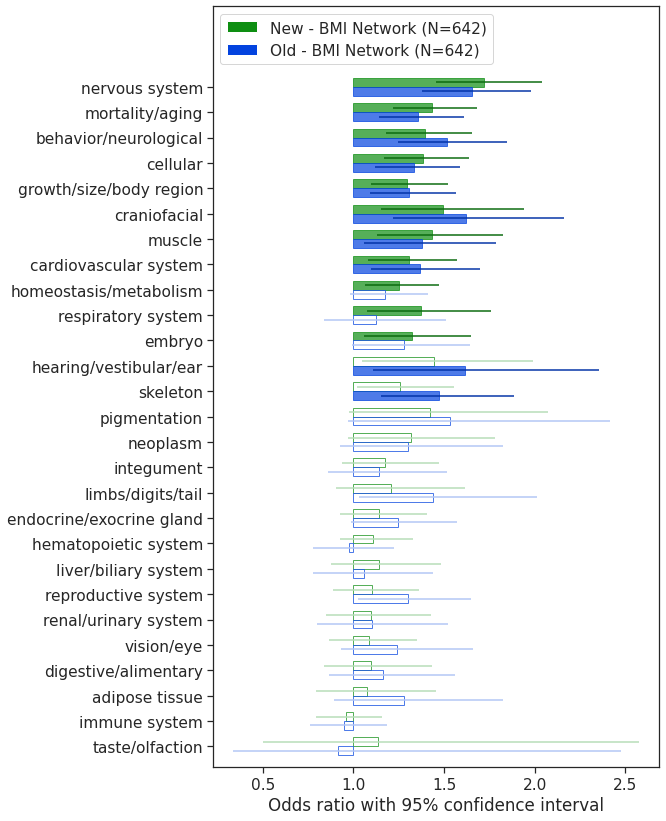

In [402]:
a = plot_hbar_comparison(all_results, communities=["C877", "C877_old"], mps=top_level, vert=14, horz = 8,
                         sig_level=0.05, community_names=["New - BMI Network", "Old - BMI Network"], sort_by="q", 
                         label_number="percent_community", correct_by_community=False)

PARENT: MP:0000001 mammalian phenotype


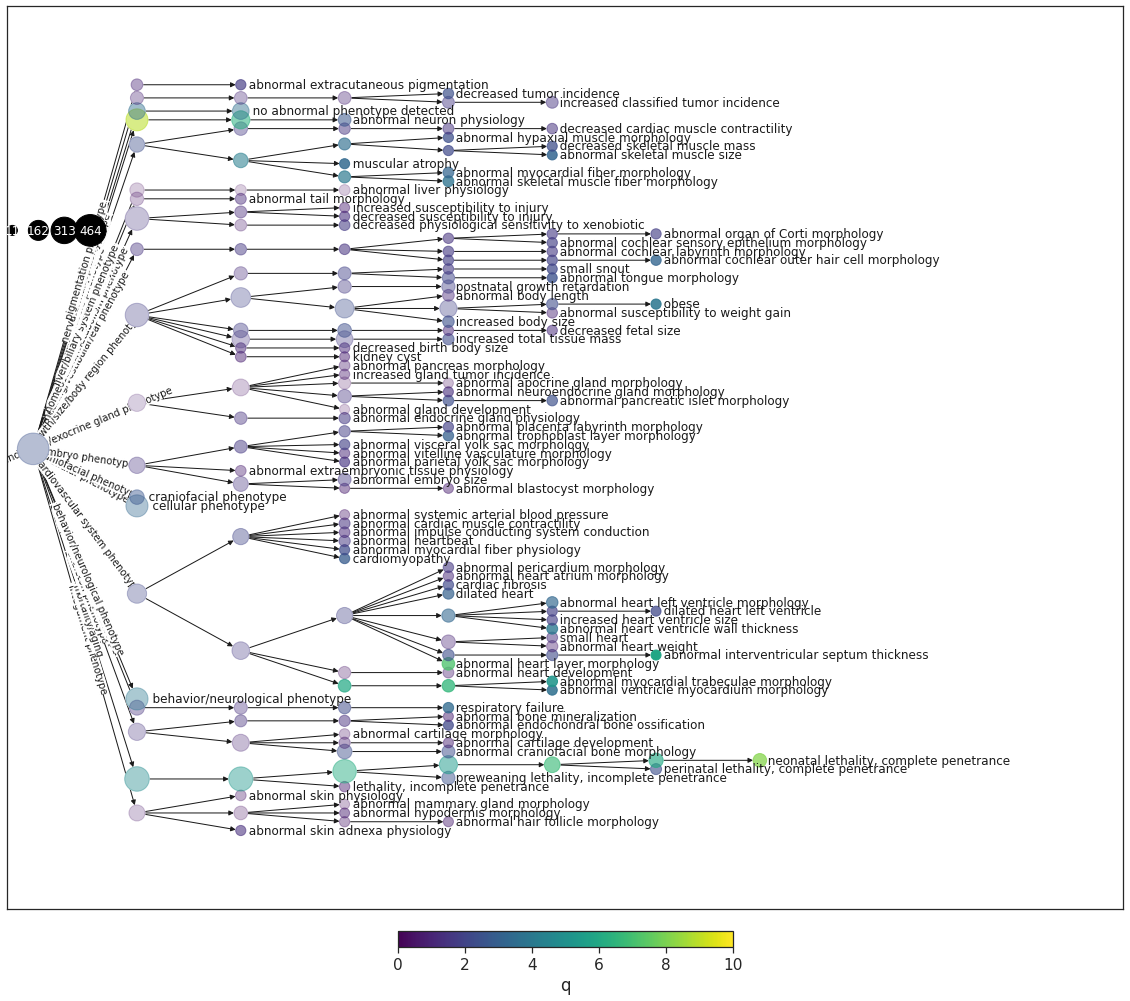

In [30]:
n = draw_significance_hierarchy(results.loc[results.observed > 10], "C877", "MP:0000001", mp_graph, MPO2, 
                                hier_df_genes, term_mapping, select_on="ppv", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=20, label="leaf", descriptive_labels=True)

## Community selection

In [33]:
new_annotations = pd.read_csv("~/Data/Transfer/rat/update_GO_annotations.csv", usecols=["name", "represents"])
body_size_traits = ["MP:0005378","MP:0010866", "MP:0003956" , "MP:0005451"]
node_list = ["C917", "C889", "C887", "C885", "C888", "C900", "C886", "C882", "C905", "C881", "C920",
                "C880", "C934", "C931", "C912", "C883", "C878", "C891", "C884", "C879", "C907", "C909", "C894"]

### Heatmap with parent

#### previous results

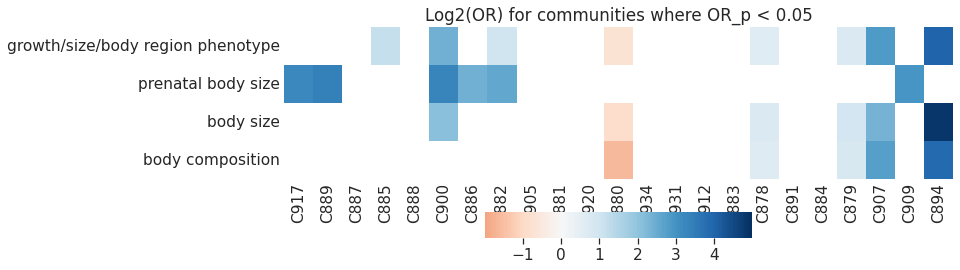

In [189]:
_ = plot_community_heatmap(old_results, body_size_traits, node_list, new_annotations, stat="OR", filter_stat="OR_p", 
                       color_range = [-2, 0, 5], MPO=MPO2, vert = 4)

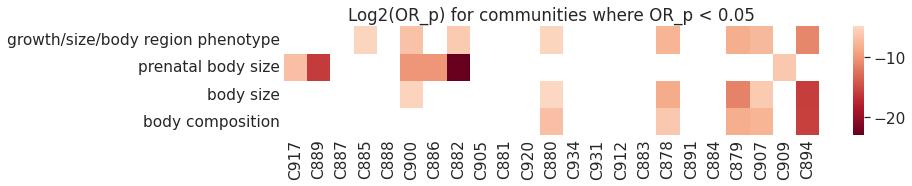

In [196]:
_ = plot_community_heatmap(old_results, body_size_traits, node_list, new_annotations,MPO2, stat="OR_p", filter_stat="OR_p", vert = 2)

#### updated results

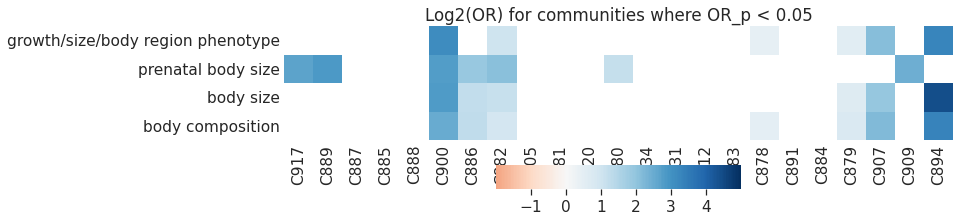

In [195]:
_ = plot_community_heatmap(results, body_size_traits, node_list, new_annotations, stat="OR", filter_stat="OR_p", 
                       color_range = [-2, 0, 5], MPO=MPO2, vert = 3)

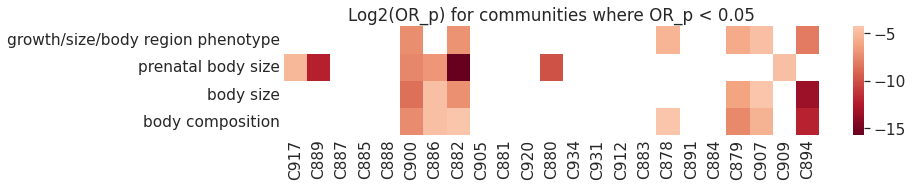

In [193]:
_ = plot_community_heatmap(results, body_size_traits, node_list, new_annotations,MPO2, stat="OR_p", filter_stat="OR_p", vert = 2)

### Heatmap without parent

#### Previous results

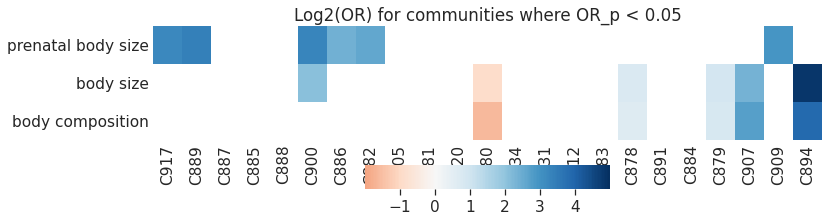

In [197]:
_ = plot_community_heatmap(old_results, body_size_traits[1:], node_list, new_annotations, stat="OR", filter_stat="OR_p", MPO=MPO2,
                      color_range = [-2, 0, 5], vert=3)

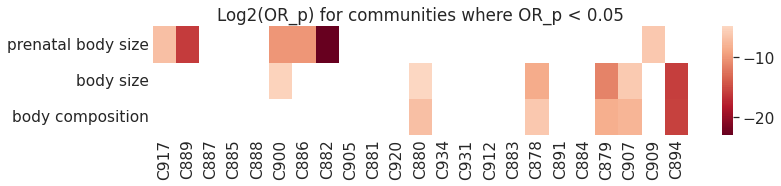

In [198]:
_ = plot_community_heatmap(old_results, body_size_traits[1:], node_list, new_annotations, MPO=MPO2,stat="OR_p", filter_stat="OR_p", vert =2)

#### updated results

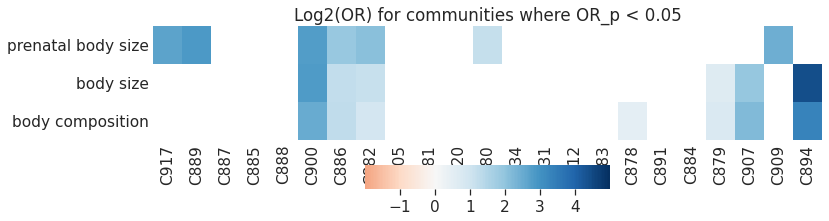

In [199]:
_ = plot_community_heatmap(results, body_size_traits[1:], node_list, new_annotations, stat="OR", filter_stat="OR_p", MPO=MPO2,
                      color_range = [-2, 0, 5], vert=3)

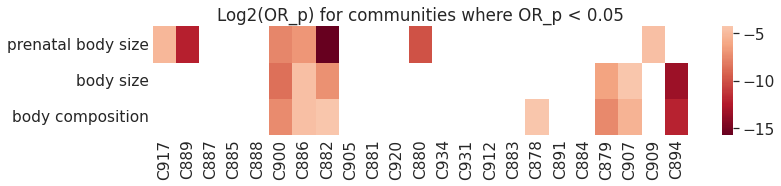

In [200]:
_ = plot_community_heatmap(results, body_size_traits[1:], node_list, new_annotations, MPO=MPO2,stat="OR_p", filter_stat="OR_p", vert =2)

## GSR - C894

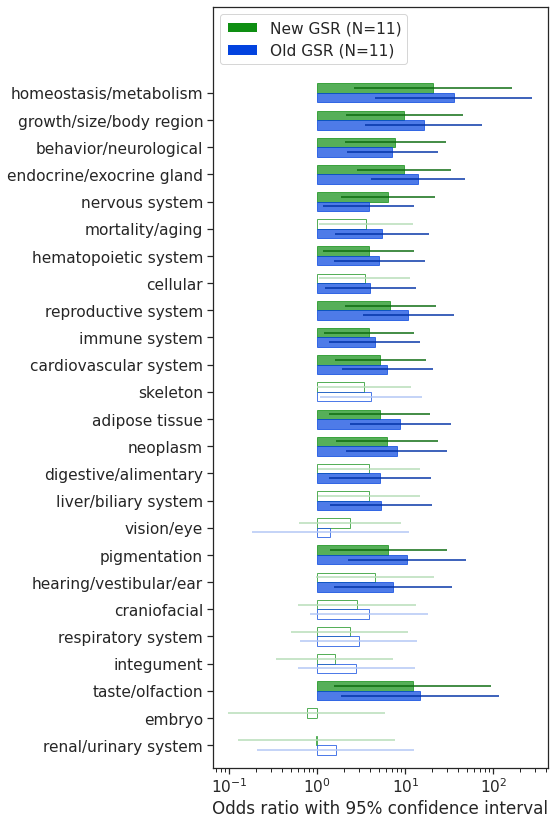

In [295]:
a = plot_hbar_comparison(all_results, communities=["C894", "C894_old"], mps=top_level, vert = 14, horz=6,
                         sig_level=0.05, community_names=["New GSR", "Old GSR"], sort_by="observed", label_number="percent_community")

PARENT: MP:0000001 mammalian phenotype


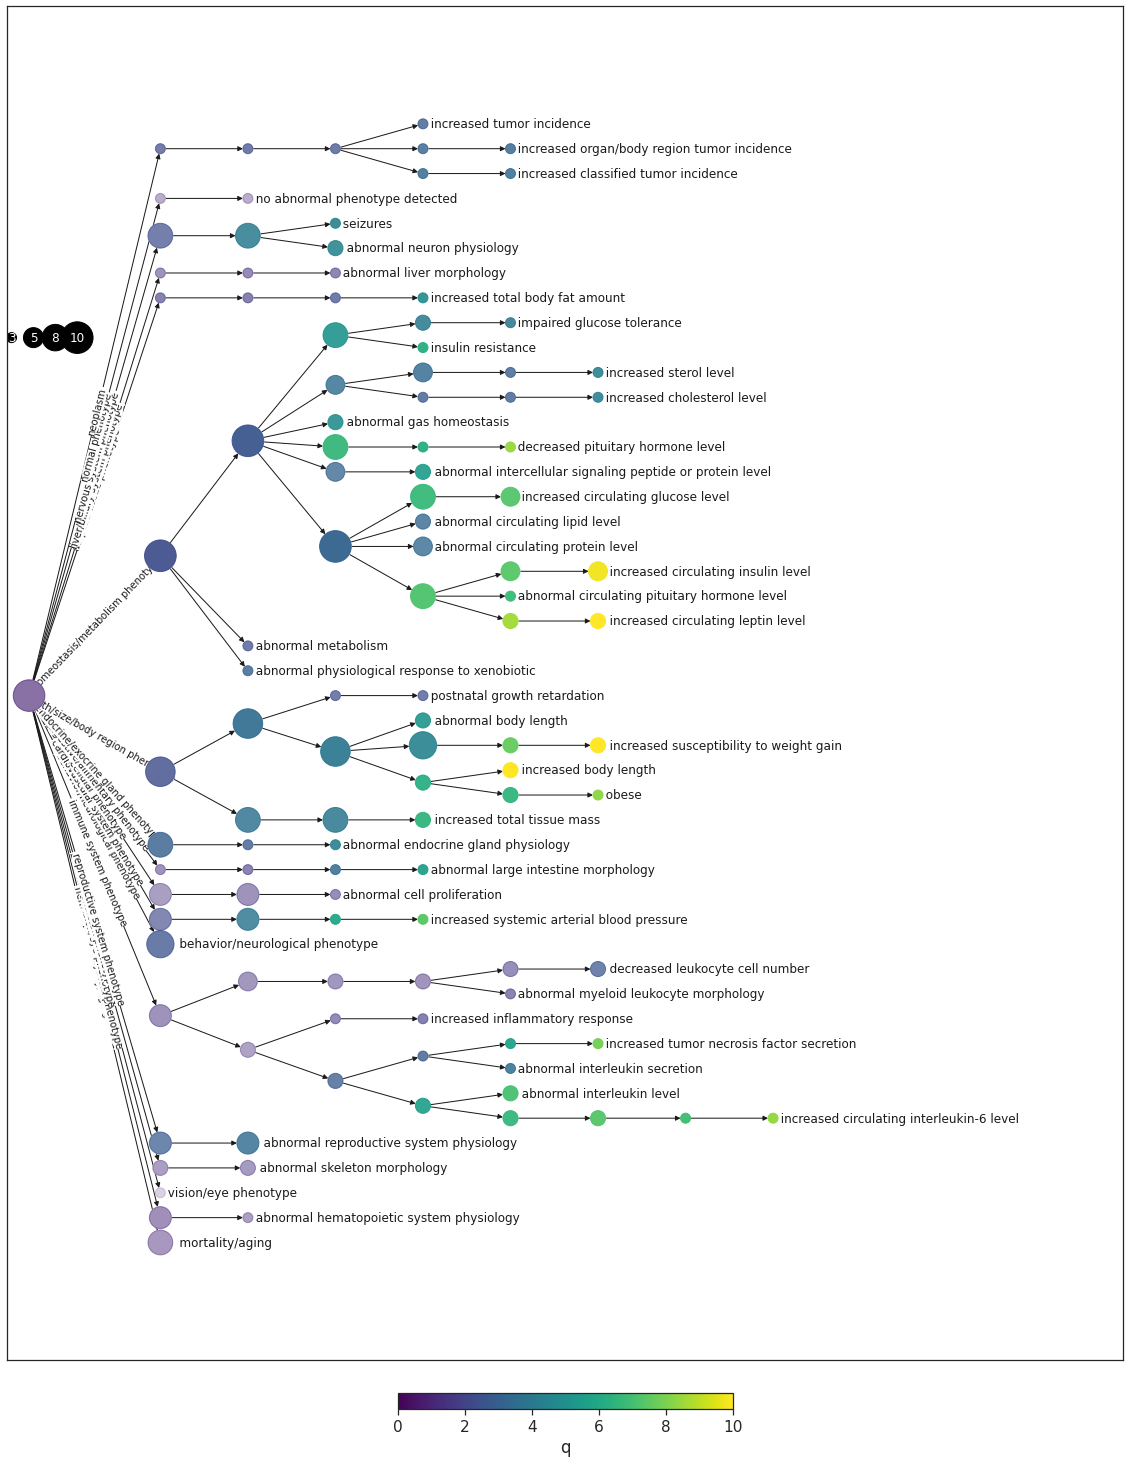

In [208]:
n = draw_significance_hierarchy(results.loc[results.observed>=3], "C894", "MP:0000001", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="ppv", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=30, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)

### Homestasis/Metabolism

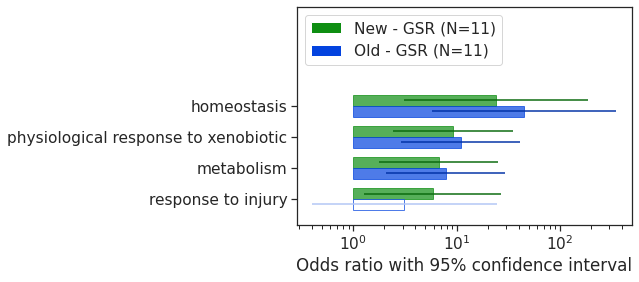

In [544]:
b = plot_hbar_comparison(all_results, communities=["C894", "C894_old"], mps="MP:0005376", vert = 4, mp_graph=mp_graph, horz=6,
                         sig_level=0.05, community_names=["New - GSR", "Old - GSR"], sort_by="observed", 
                         label_number="percent_community", correct_by_community=False)


In [545]:
def get_gene_hits_no_annotation(genes, term, MPO, term_mapping):
    term_genes = [MPO.genes[idx] for idx in term_mapping[term]]
    overlap = set(genes).intersection(set(term_genes))
    return overlap

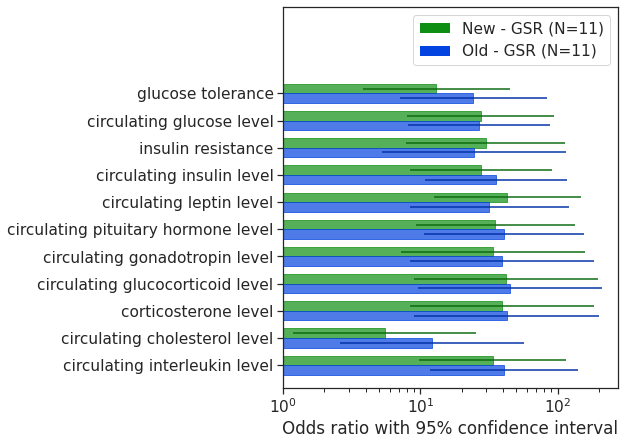

In [546]:
hormone_terms = [5291, 188,5331, 1560, 5667, 5116, 3361, 3366, 3963, 180, 8588]
hormone_terms = [num_to_mp(n) for n in hormone_terms]
a = plot_hbar_comparison(all_results, communities=["C894", "C894_old"], mps=hormone_terms, vert = 7, mp_graph=mp_graph,horz=6,
                         sig_level=0.05, community_names=["New - GSR", "Old - GSR"], sort_by=None, label_number="percent_community")

In [745]:
hier_df_genes

CD_MemberList  frac_d1_seeds  \
C877  HELZ EMX2 HIST1H3A RAD51 SYT12 GYPC KDM3B ERC1...       0.353583   
C898  STX4 LSAMP SPOCK1 SGCB STXBP5 TRP-AGG2-6 GPRC5...       0.363636   
C904  BCL11B PKIB PKIA LMO1 NR2F1 LDB2 ZFPM2 GATA3 A...       0.300000   
C906  PROM2 SPINT1 TNIK PKP3 SSH3 FEZ2 CORIN WWC1 CAPN1       0.333333   
C911  ZNF629 ZKSCAN5 LINGO1 ZNF202 ZKSCAN2 ZNF263 ZN...       0.571429   
...                                                 ...            ...   
C928                 MAPK6 CLHC1 CAMK4 STK33 AC138811.2       0.400000   
C917     MAP2K5 DAPK2 CAMK2G MAP2K3 DAPK3 MAP2K6 MAP2K1       0.571429   
C918          NSD2 KNSTRN KIF22 PYDC1 CCDC34 CENPF OIP5       0.428571   
C927                      ZDHHC21 RFT1 AKT3 TSPAN5 CMC4       0.600000   
C936                         CDPF1 YWHAB DDIT4L NR2C2AP       0.250000   

      frac_d2_seeds  
C877       0.177570  
C898       0.181818  
C904       0.200000  
C906       0.111111  
C911       0.142857  
...             ...  
C928       0.400000  
C917       0.142857  
C918       0.285714  
C927       0.200000  
C936       0.250000  

[61 rows x 3 columns]

In [216]:
c894_genes = hier_df_genes.loc["C894", "CD_MemberList"].split(" ")
hit_dict = {}
for h in hormone_terms:
    hit_dict[h] = list(get_gene_hits_no_annotation(c894_genes, h, MPO2, term_mapping))

In [217]:
for h in hit_dict:
    print(h, hit_dict[h])

MP:0005291 ['POMC', 'VIPR1', 'GNAO1', 'MC4R']
MP:0000188 ['BDNF', 'GNAO1', 'MC4R', 'POMC', 'VIPR1', 'ADORA2B', 'PRLHR']
MP:0005331 ['POMC', 'BDNF', 'PRLHR']
MP:0001560 ['BDNF', 'GNAO1', 'MC4R', 'POMC', 'PRLHR']
MP:0005667 ['POMC', 'BDNF', 'PRLHR', 'MC4R']
MP:0005116 ['POMC', 'NPFFR1', 'POU1F1']
MP:0003361 ['NPFFR1', 'POU1F1']
MP:0003366 ['POMC', 'PRLHR']
MP:0003963 ['POMC', 'PRLHR']
MP:0000180 ['PRLHR', 'MC4R']
MP:0008588 ['GNAI2', 'POMC', 'MC4R', 'ADORA2B']


Abnormal homeostasis


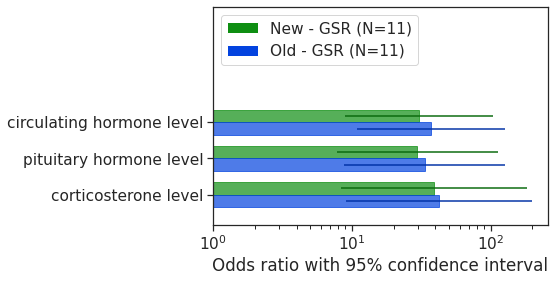

In [547]:
print("Abnormal homeostasis")
a = plot_hbar_comparison(all_results[all_results.observed > 1], communities=["C894", "C894_old"], mps="MP:0003953", horz=6, vert = 4, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - GSR", "Old - GSR"], sort_by="observed", label_number="percent_community")

Abnormal blood homeostasis


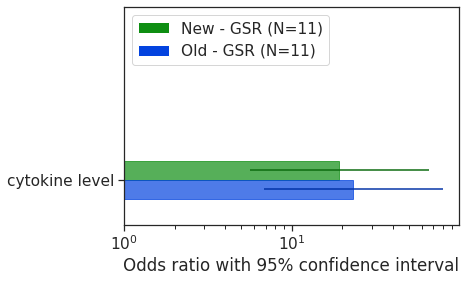

In [548]:
print("Abnormal blood homeostasis")
a = plot_hbar_comparison(all_results[all_results.observed > 1], communities=["C894", "C894_old"], mps="MP:0008835", horz=6, vert = 4, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - GSR", "Old - GSR"], sort_by="observed", label_number="percent_community")

Abnormal circulating hormone level ~ abnormal hormone level


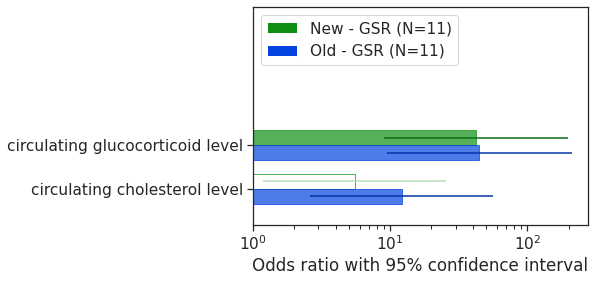

In [549]:
print("Abnormal circulating hormone level ~ abnormal hormone level")
a = plot_hbar_comparison(all_results[all_results.observed > 1], communities=["C894", "C894_old"], mps="MP:0003949", horz=6, vert =4, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - GSR", "Old - GSR"], sort_by="observed", label_number="percent_community")

PARENT: MP:0009642 abnormal blood homeostasis


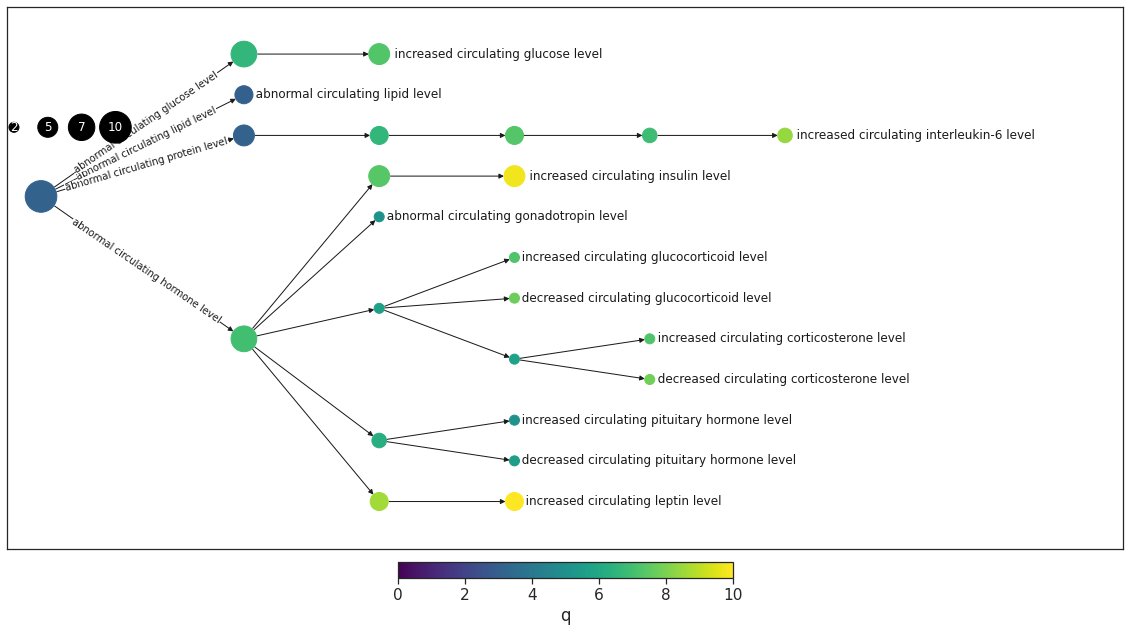

no hits passing filters


In [553]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C894", "MP:0009642", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="ppv", 
                                size_by="obs", alpha_by="x",color_by="q", vert=12, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)
#get_hits(n, results, p=0.01, OR=2, obs_min=3, total=100000, level= 2)

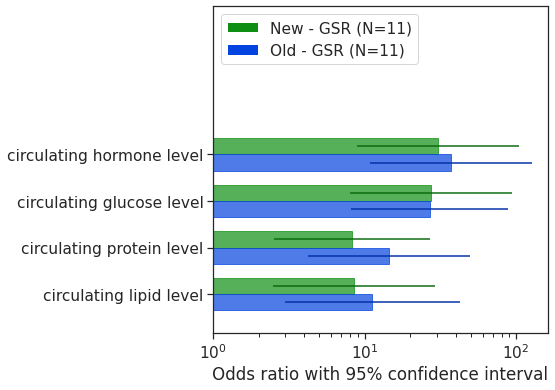

In [556]:
a = plot_hbar_comparison(all_results[all_results.observed>=2], communities=["C894", "C894_old"], mps="MP:0009642", horz=6, vert = 6, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - GSR", "Old - GSR"], sort_by="observed", label_number="percent_community")

### Growth/body size

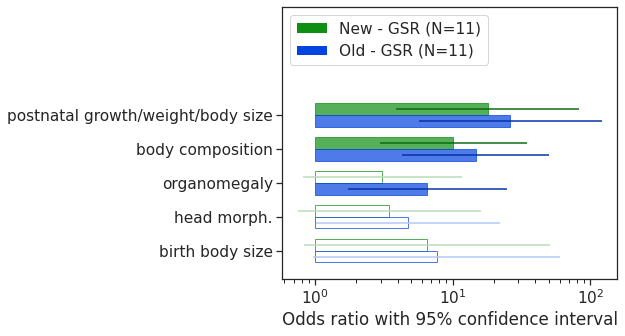

In [557]:
a = plot_hbar_comparison(all_results, communities=["C894", "C894_old"], mps="MP:0005378", horz=6, vert = 5, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - GSR", "Old - GSR"], sort_by="observed", label_number="percent_community")

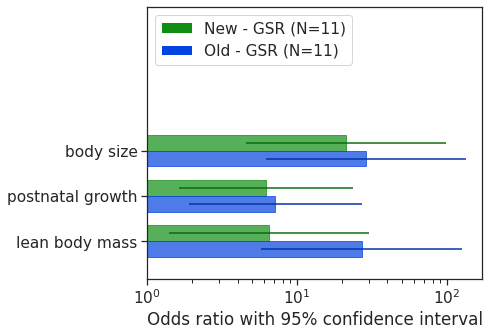

In [568]:
a = plot_hbar_comparison(all_results, communities=["C894", "C894_old"], mps="MP:0002089", horz=6, vert = 5, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - GSR", "Old - GSR"], sort_by="observed", label_number="percent_community")

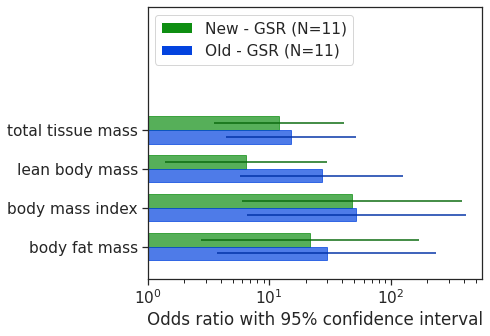

In [569]:
a = plot_hbar_comparison(all_results, communities=["C894", "C894_old"], mps="MP:0005451", horz=6, vert = 5, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - GSR", "Old - GSR"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005378 growth/size/body region phenotype


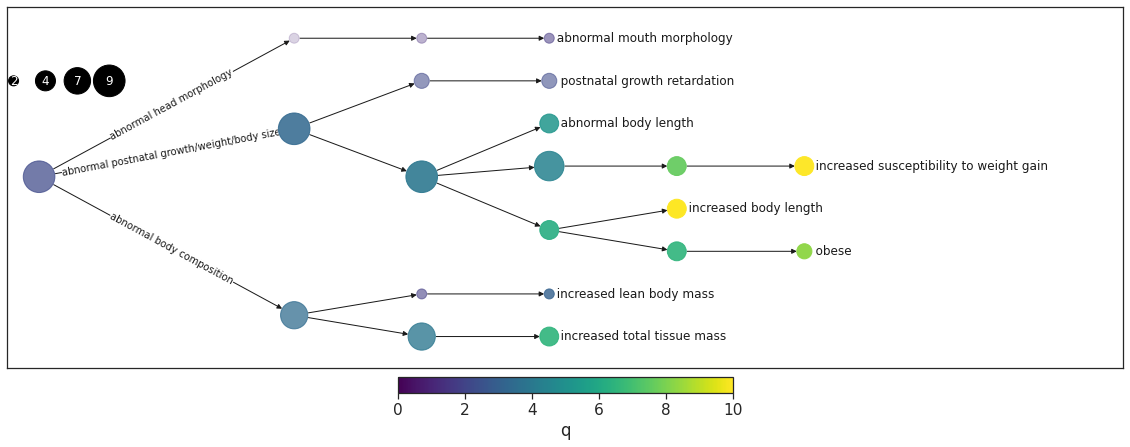

no hits passing filters


In [558]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C894", "MP:0005378", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="ppv", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=8, label="leaf", 
                                descriptive_labels=True, adjust_root=0.2)
get_hits(n, results, p=0.001, OR=2, obs_min=3, total=10000, level=4)

### Behavior/neurological

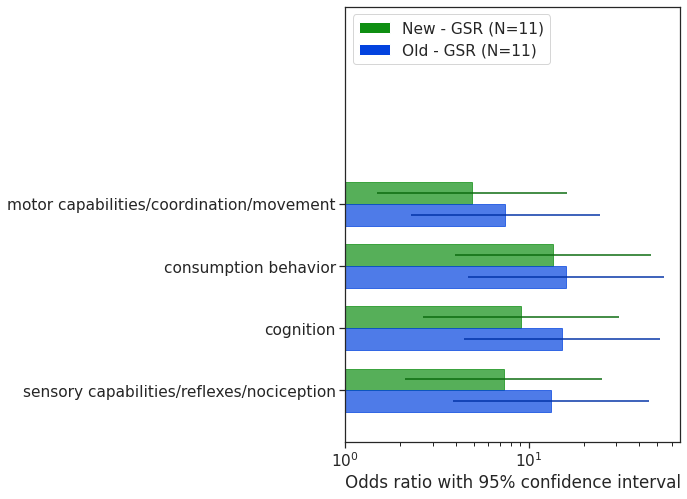

In [565]:
a = plot_hbar_comparison(all_results[all_results.observed>=4], communities=["C894", "C894_old"], mps="MP:0004924", horz=6, vert = 8, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - GSR", "Old - GSR"], sort_by="observed", label_number="percent_community")

PARENT: MP:0004924 abnormal behavior


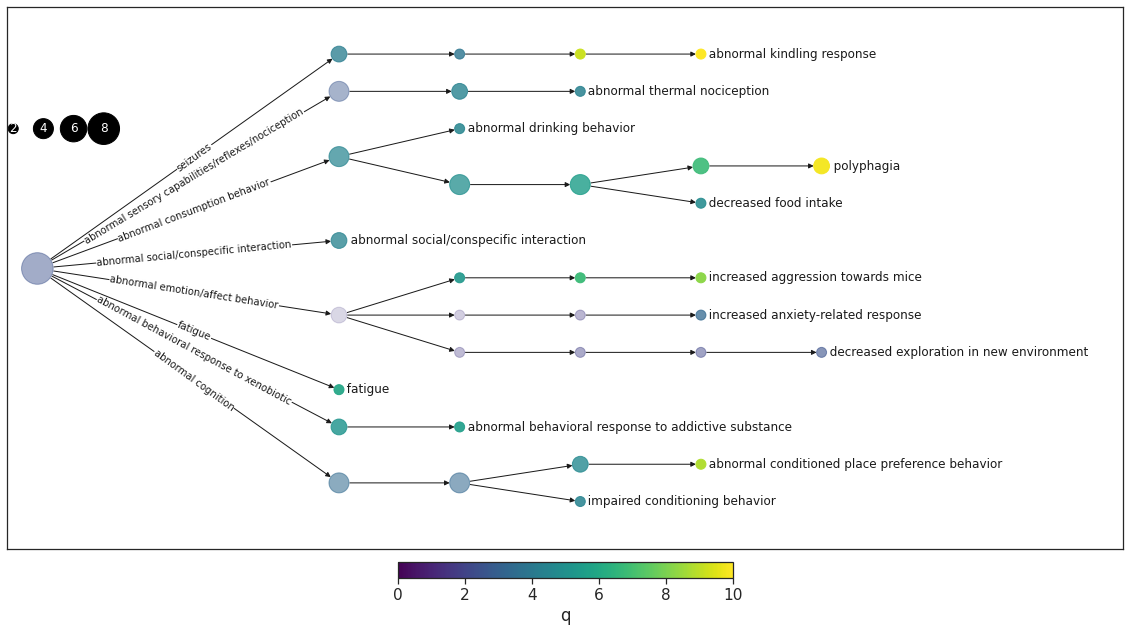

no hits passing filters


In [567]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C894", "MP:0004924", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="ppv", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=12, label="leaf", 
                                descriptive_labels=True, adjust_root=0.3)
get_hits(n, results, p=0.001, OR=2, obs_min=3, total=10000, level=3)

### Endo/exocrine gland

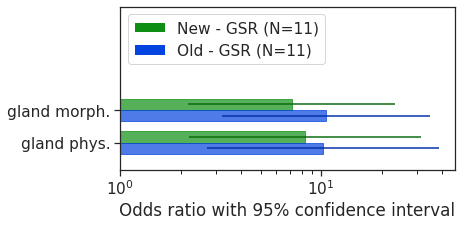

In [570]:
a = plot_hbar_comparison(all_results, communities=["C894", "C894_old"], mps="MP:0005379", horz=6, vert = 3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - GSR", "Old - GSR"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005379 endocrine/exocrine gland phenotype


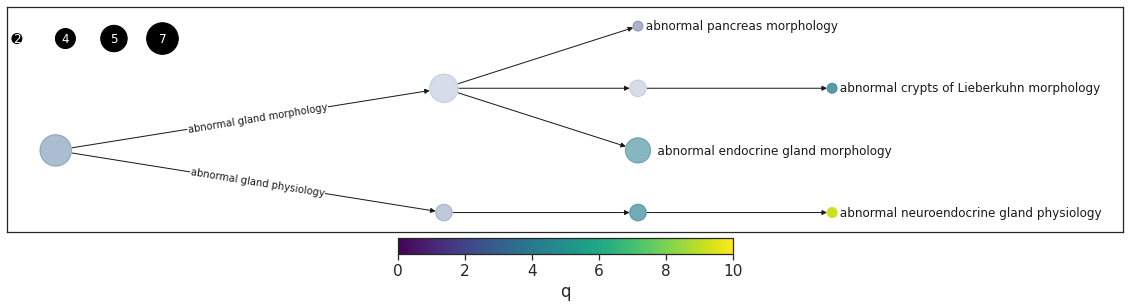

no hits passing filters


In [574]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C894", "MP:0005379", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="hypergeom", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=5, label="leaf", 
                                descriptive_labels=True, adjust_root=0.2)
get_hits(n, results, p=0.001, OR=2, obs_min=3, total=10000, level=3)

### Nervous system

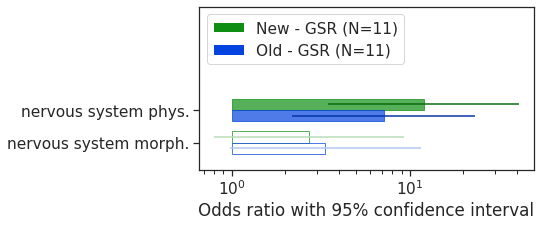

In [575]:
a = plot_hbar_comparison(all_results, communities=["C894", "C894_old"], mps="MP:0003631", horz=6, vert = 3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - GSR", "Old - GSR"], sort_by="observed", label_number="percent_community")

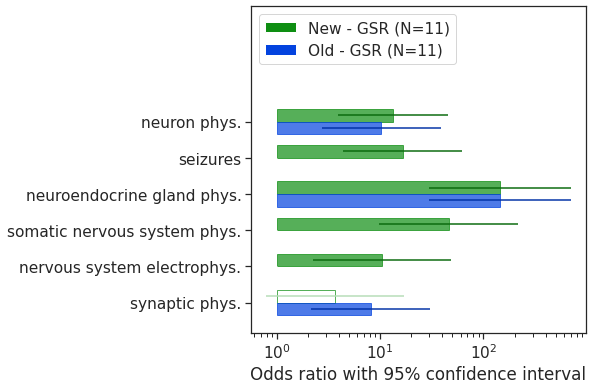

In [582]:
a = plot_hbar_comparison(all_results[all_results.observed>=2], communities=["C894", "C894_old"], mps="MP:0003633", horz=6, vert = 6, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - GSR", "Old - GSR"], sort_by="observed", label_number="percent_community")

PARENT: MP:0003631 nervous system phenotype


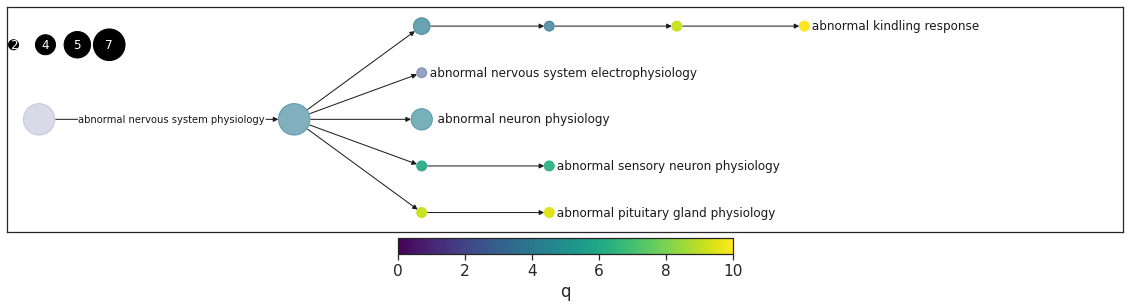

no hits passing filters


In [583]:
x = draw_significance_hierarchy(results.loc[results.observed>=2], "C894", "MP:0003631", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="ppv", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=5, label="leaf", 
                                descriptive_labels=True, adjust_root=0.2)
get_hits(x, results, p=0.001, OR=2, obs_min=3, total=10000, level=3)

### Mortality/aging

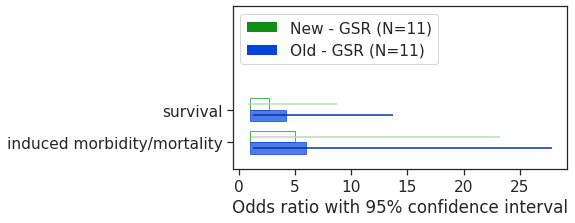

In [584]:
a = plot_hbar_comparison(all_results, communities=["C894", "C894_old"], mps="MP:0010768", horz=6, vert = 3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - GSR", "Old - GSR"], sort_by="observed", label_number="percent_community")

PARENT: MP:0010768 mortality/aging


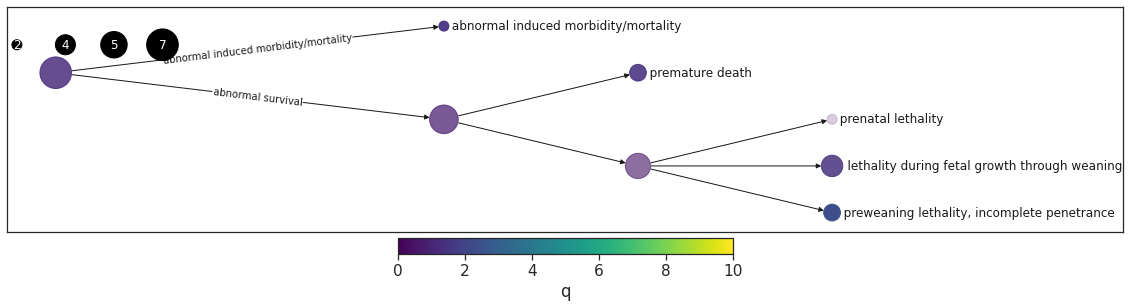

no hits passing filters


In [586]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C894", "MP:0010768", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="hypergeom", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=5, label="leaf", 
                                descriptive_labels=True, adjust_root=0.2)
get_hits(n, results, p=0.001, OR=2, obs_min=3, total=10000, level=3)

### Hematopoetic

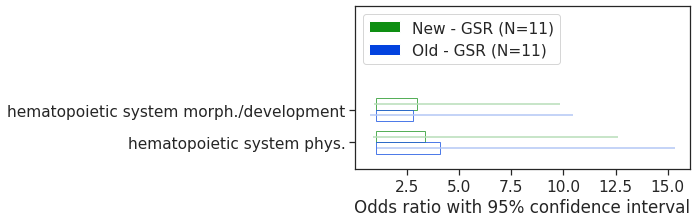

In [587]:
a = plot_hbar_comparison(all_results, communities=["C894", "C894_old"], mps="MP:0005397", horz=6, vert = 3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - GSR", "Old - GSR"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005397 hematopoietic system phenotype


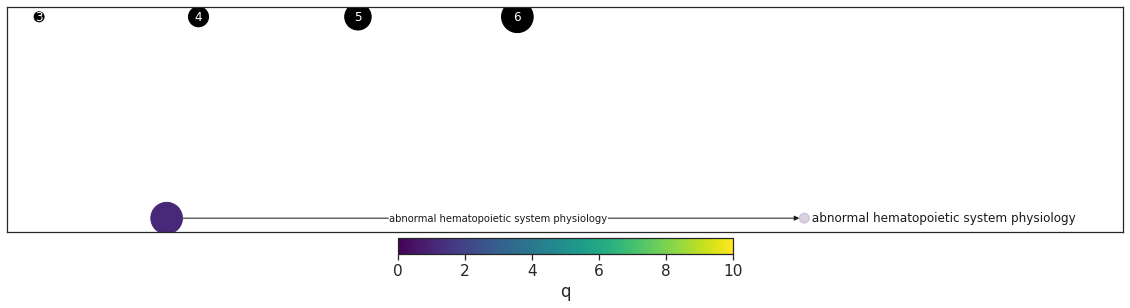

no hits passing filters


In [591]:
x = draw_significance_hierarchy(results.loc[results.observed>=2], "C894", "MP:0005397", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="hypergeom", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=5, label="leaf", 
                                descriptive_labels=True, adjust_root=0)
get_hits(x, results, p=0.001, OR=2, obs_min=3, total=10000, level=3)

### Cellular

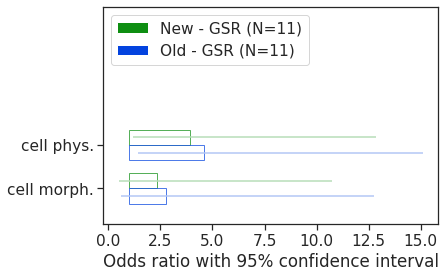

In [589]:
a = plot_hbar_comparison(all_results, communities=["C894", "C894_old"], mps="MP:0005384", horz=6, vert = 4, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - GSR", "Old - GSR"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005384 cellular phenotype


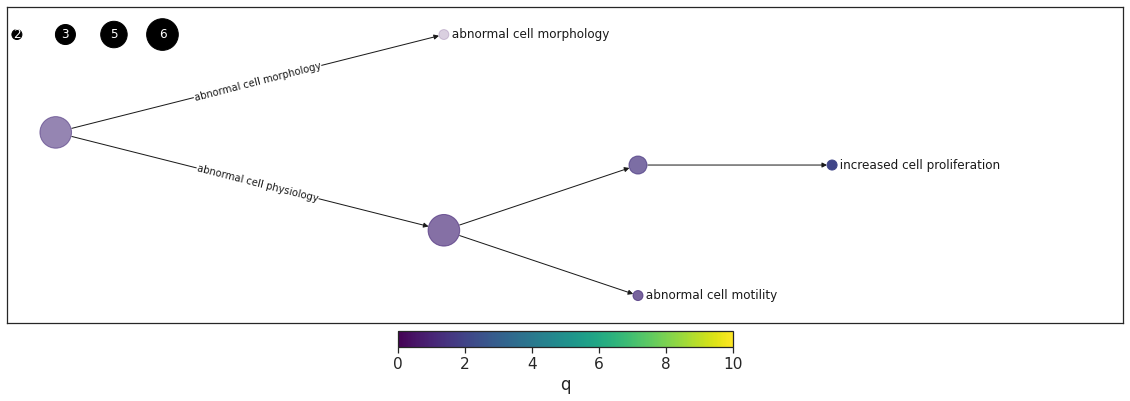

no hits passing filters


In [593]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C894", "MP:0005384", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="hypergeom", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", 
                                descriptive_labels=True, adjust_root=0.2)
get_hits(n, results, p=0.001, OR=2, obs_min=3, total=10000, level=3)

### Reproductive

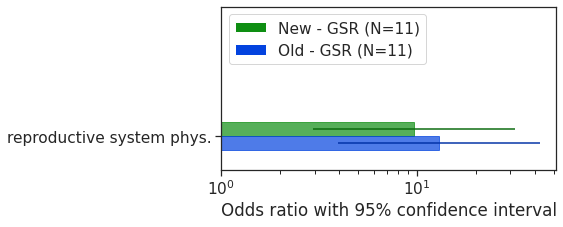

In [594]:
a = plot_hbar_comparison(all_results, communities=["C894", "C894_old"], mps="MP:0005389", horz=6, vert = 3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - GSR", "Old - GSR"], sort_by="observed", label_number="percent_community")


PARENT: MP:0005389 reproductive system phenotype


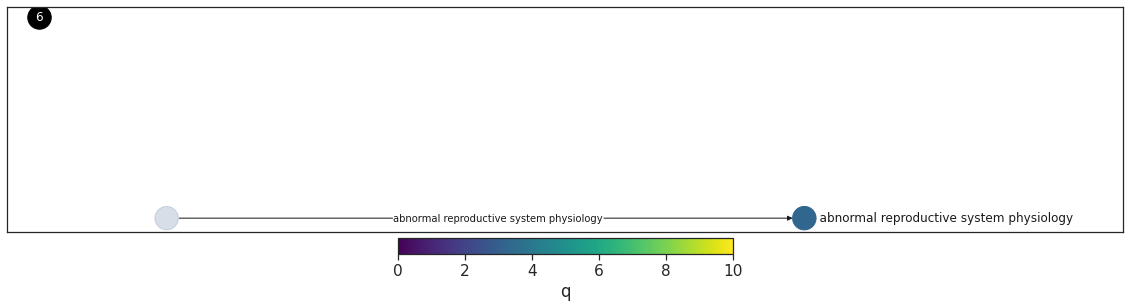

no hits passing filters


In [597]:
x = draw_significance_hierarchy(results.loc[results.observed>=2], "C894", "MP:0005389", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="hypergeom", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=5, label="leaf", 
                                descriptive_labels=True, adjust_root=0)
get_hits(x, results, p=0.001, OR=2, obs_min=3, total=10000, level=3)

### Immune system


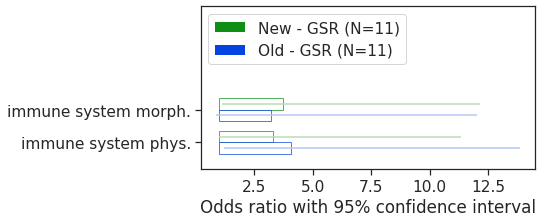

In [598]:
a = plot_hbar_comparison(all_results, communities=["C894", "C894_old"], mps="MP:0005387", horz=6, vert = 3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - GSR", "Old - GSR"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005387 immune system phenotype


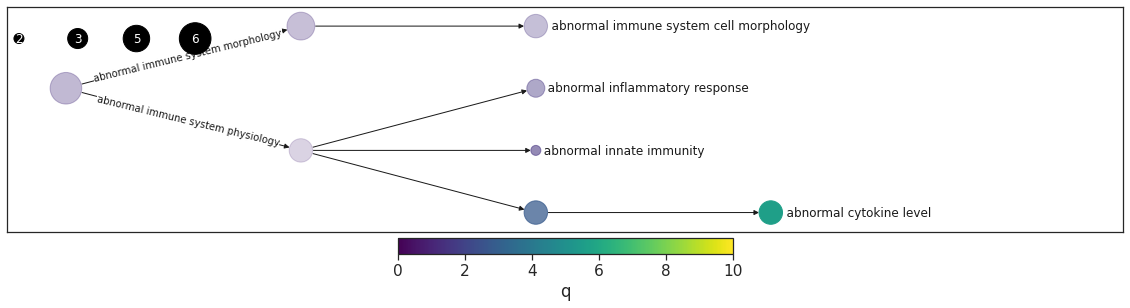

no hits passing filters


In [599]:
x = draw_significance_hierarchy(results.loc[results.observed>=2], "C894", "MP:0005387", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="hypergeom", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=5, label="leaf", 
                                descriptive_labels=True, adjust_root=0)
get_hits(x, results, p=0.001, OR=2, obs_min=3, total=10000, level=3)

### Cardiovascular

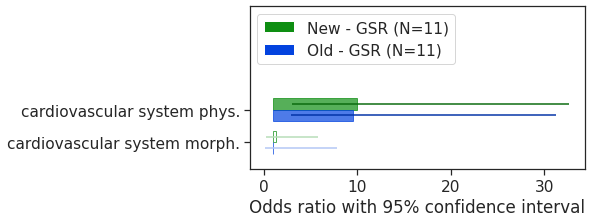

In [600]:
a = plot_hbar_comparison(all_results, communities=["C894", "C894_old"], mps="MP:0005385", horz=6, vert = 3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - GSR", "Old - GSR"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005385 cardiovascular system phenotype


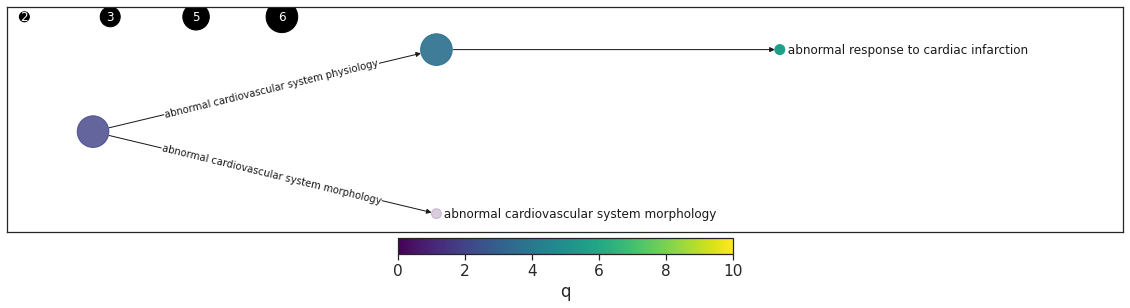

no hits passing filters


In [601]:
x = draw_significance_hierarchy(results.loc[results.observed>=2], "C894", "MP:0005385", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="hypergeom", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=5, label="leaf", 
                                descriptive_labels=True, adjust_root=0)
get_hits(x, results, p=0.001, OR=2, obs_min=3, total=10000, level=3)

### Adipose

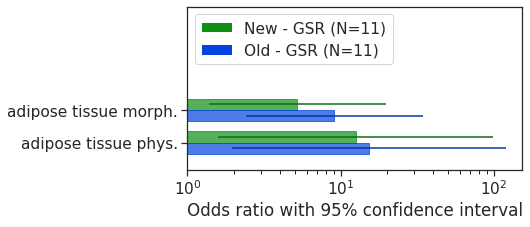

In [602]:
a = plot_hbar_comparison(all_results, communities=["C894", "C894_old"], mps="MP:0005375", horz=6, vert = 3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - GSR", "Old - GSR"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005375 adipose tissue phenotype


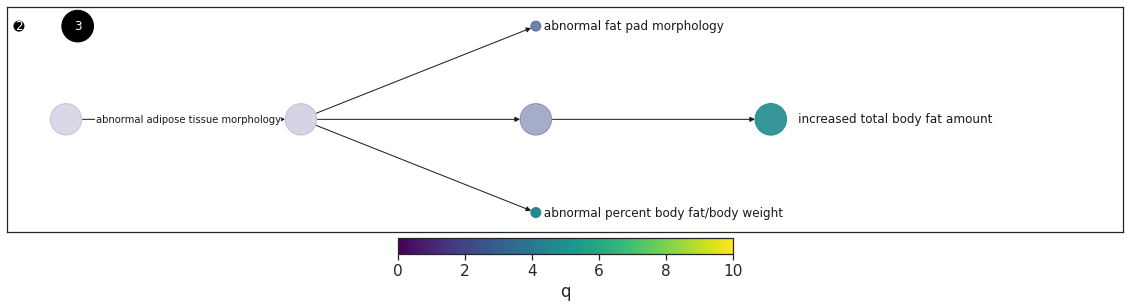

no hits passing filters


In [603]:
x = draw_significance_hierarchy(results.loc[results.observed>=2], "C894", "MP:0005375", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="hypergeom", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=5, label="leaf", 
                                descriptive_labels=True, adjust_root=0)
get_hits(x, results, p=0.001, OR=2, obs_min=3, total=10000, level=3)

### Adipose

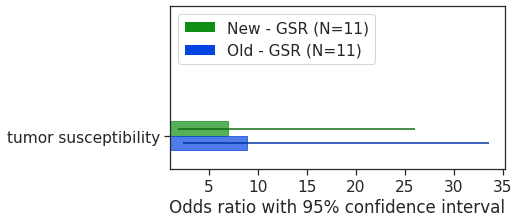

In [604]:
a = plot_hbar_comparison(all_results, communities=["C894", "C894_old"], mps="MP:0002006", horz=6, vert = 3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - GSR", "Old - GSR"], sort_by="observed", label_number="percent_community")

PARENT: MP:0002006 neoplasm


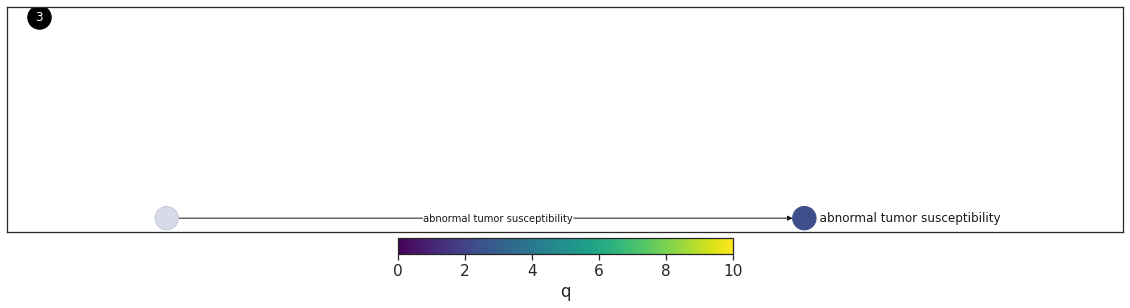

no hits passing filters


In [605]:
x = draw_significance_hierarchy(results.loc[results.observed>=2], "C894", "MP:0002006", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="hypergeom", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=5, label="leaf", 
                                descriptive_labels=True, adjust_root=0)
get_hits(x, results, p=0.001, OR=2, obs_min=3, total=10000, level=3)

## DM1/DM2/DM3 - C882/C886/C900

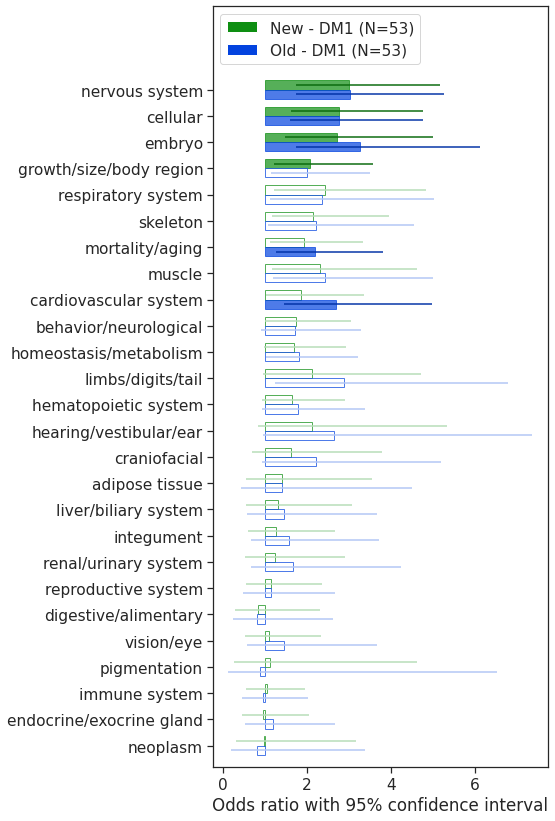

In [488]:
a = plot_hbar_comparison(all_results, communities=["C882", "C882_old"], mps=top_level, horz=6, vert = 14,
                         sig_level=0.05, community_names=["New - DM1", "Old - DM1"], sort_by="q", 
                         label_number="percent_community")

PARENT: MP:0000001 mammalian phenotype


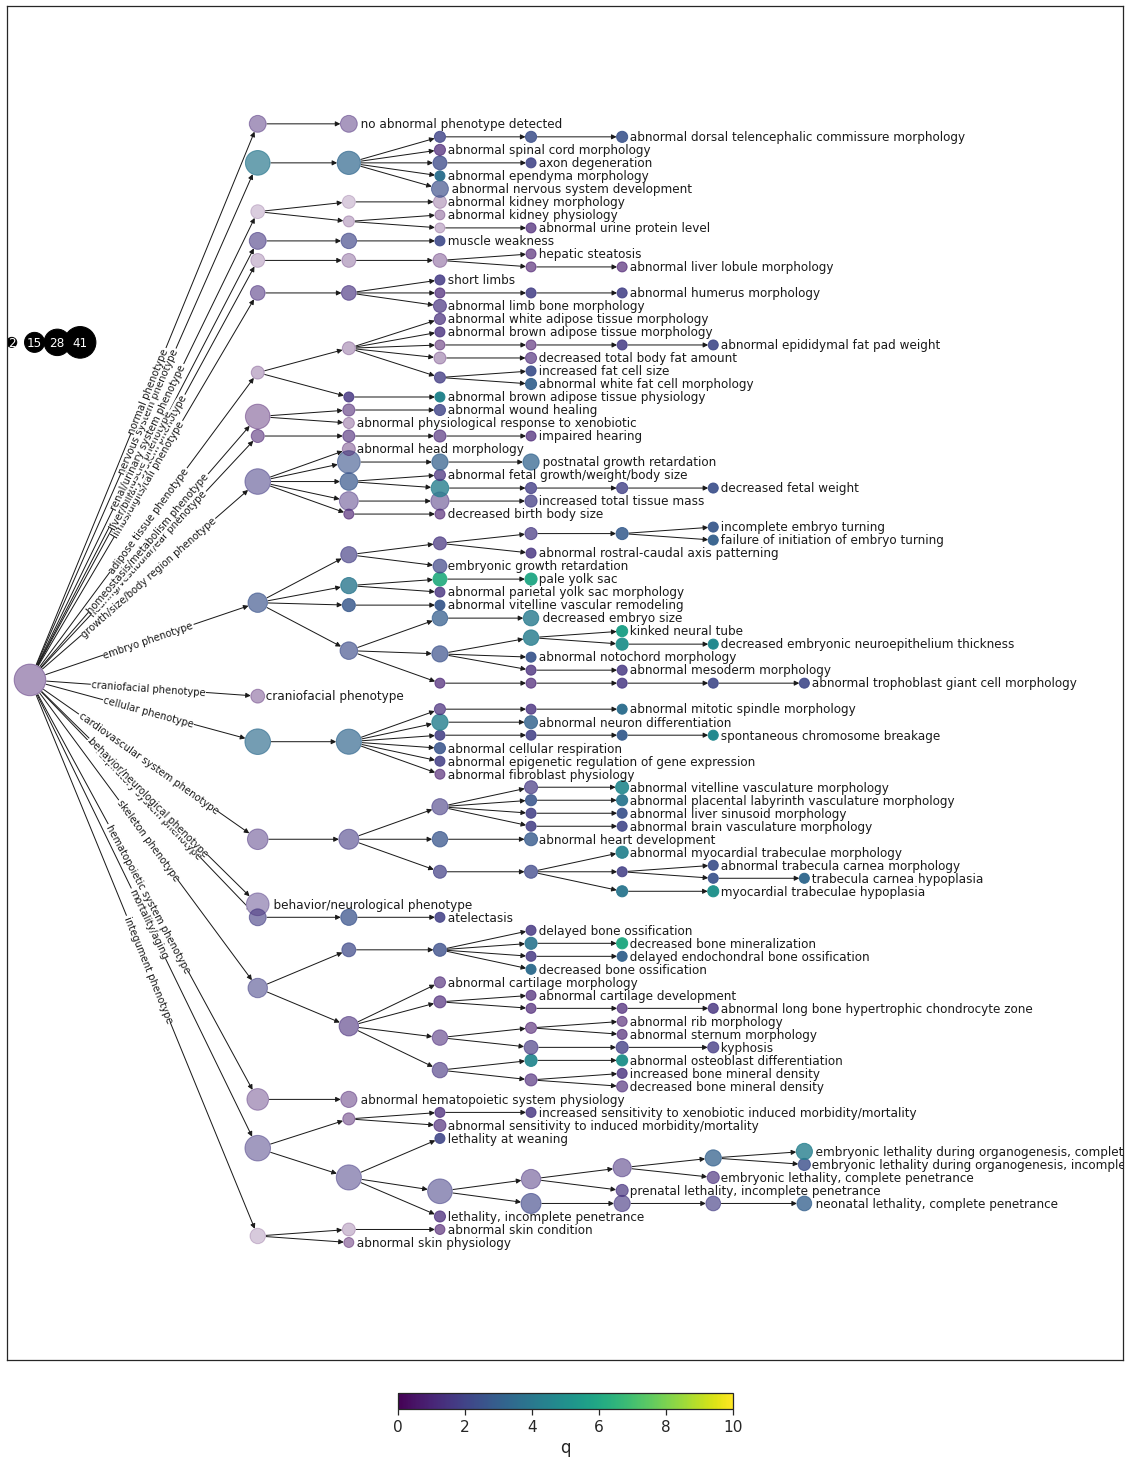

In [301]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C882", "MP:0000001", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="ppv", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=30, label="leaf", 
                                descriptive_labels=True, adjust_root=0.3)

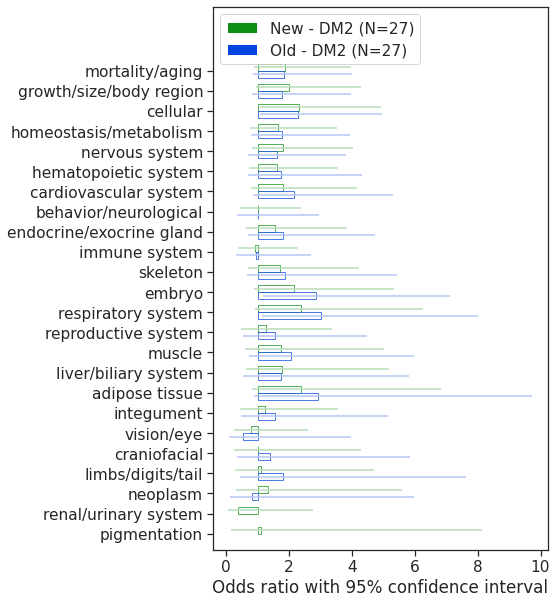

In [302]:
a = plot_hbar_comparison(all_results, communities=["C886", "C886_old"], mps=top_level, horz=6, vert = 10,
                         sig_level=0.05, community_names=["New - DM2", "Old - DM2"], sort_by="observed", label_number="percent_community")

PARENT: MP:0000001 mammalian phenotype


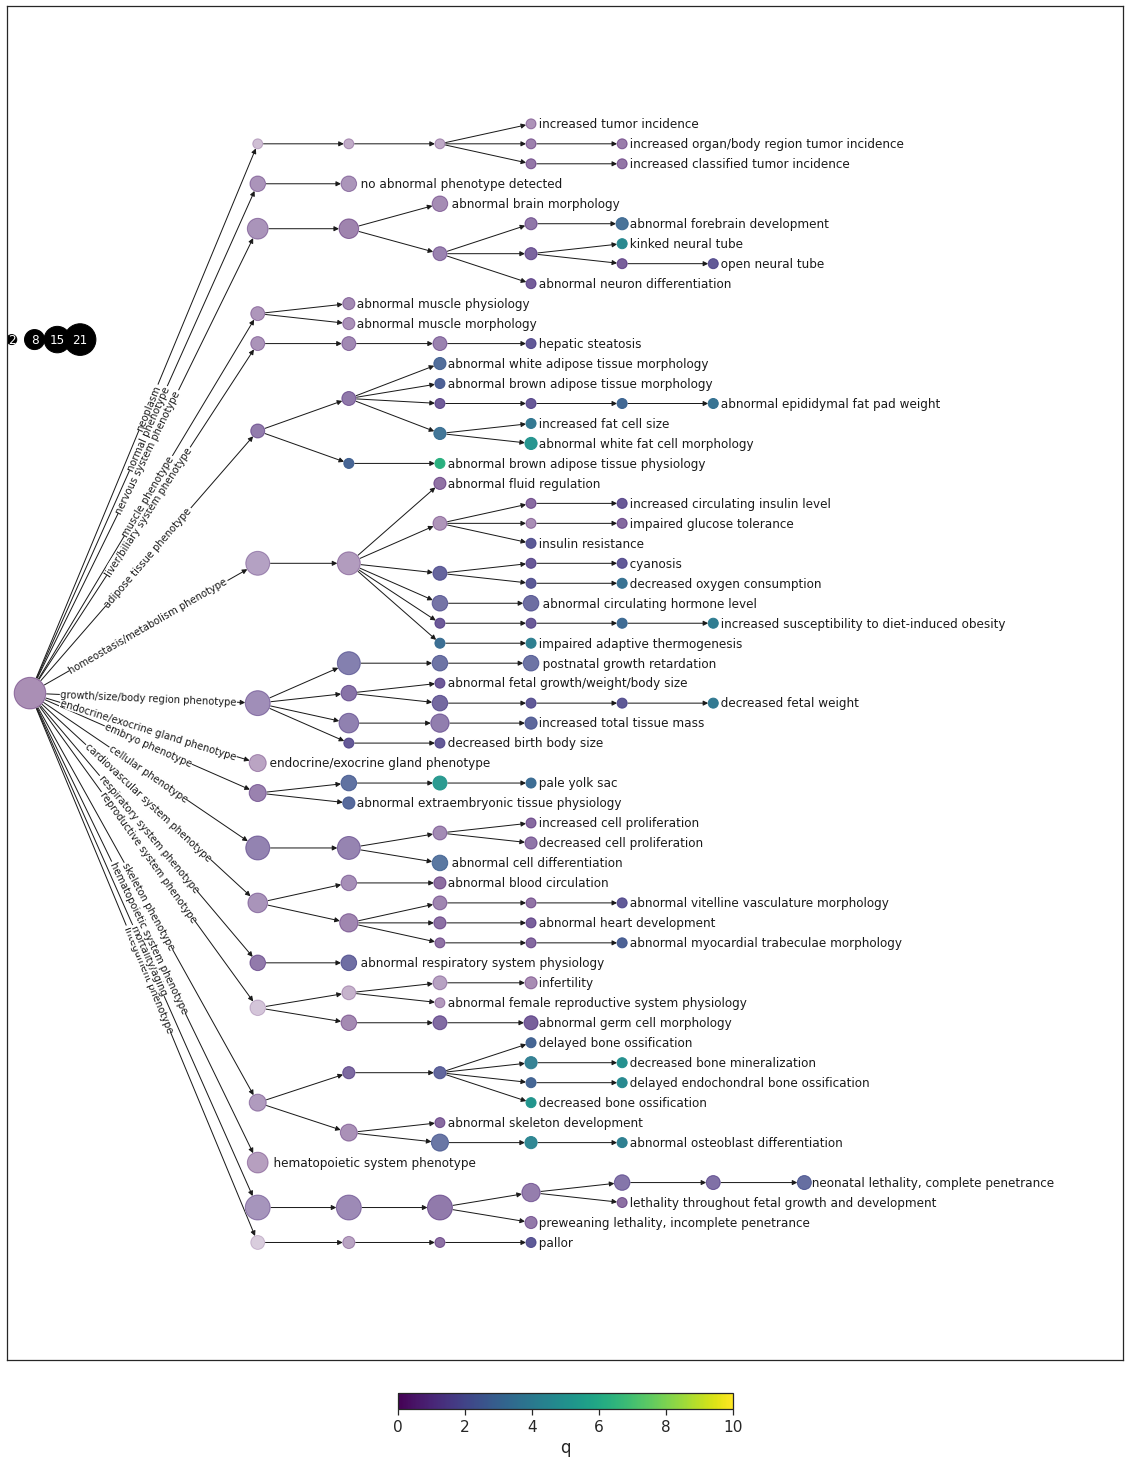

In [303]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C886", "MP:0000001", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="ppv", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=30, label="leaf", 
                                descriptive_labels=True, adjust_root=0.3)


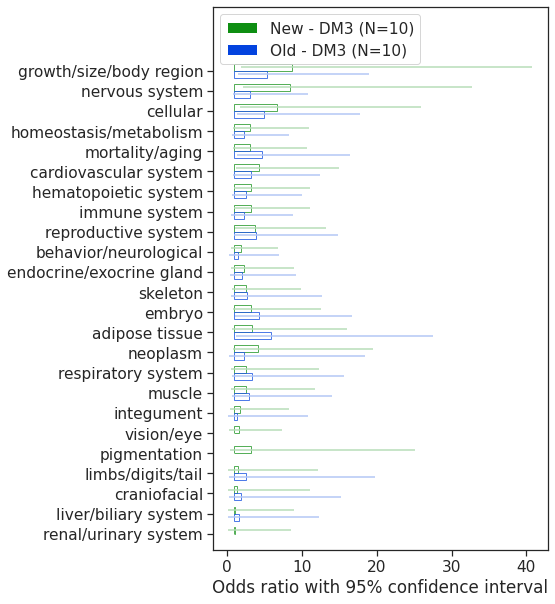

In [304]:
a = plot_hbar_comparison(all_results, communities=["C900", "C900_old"], mps=top_level, horz=6, vert = 10,
                         sig_level=0.05, community_names=["New - DM3", "Old - DM3"], sort_by="observed", label_number="percent_community")

PARENT: MP:0000001 mammalian phenotype


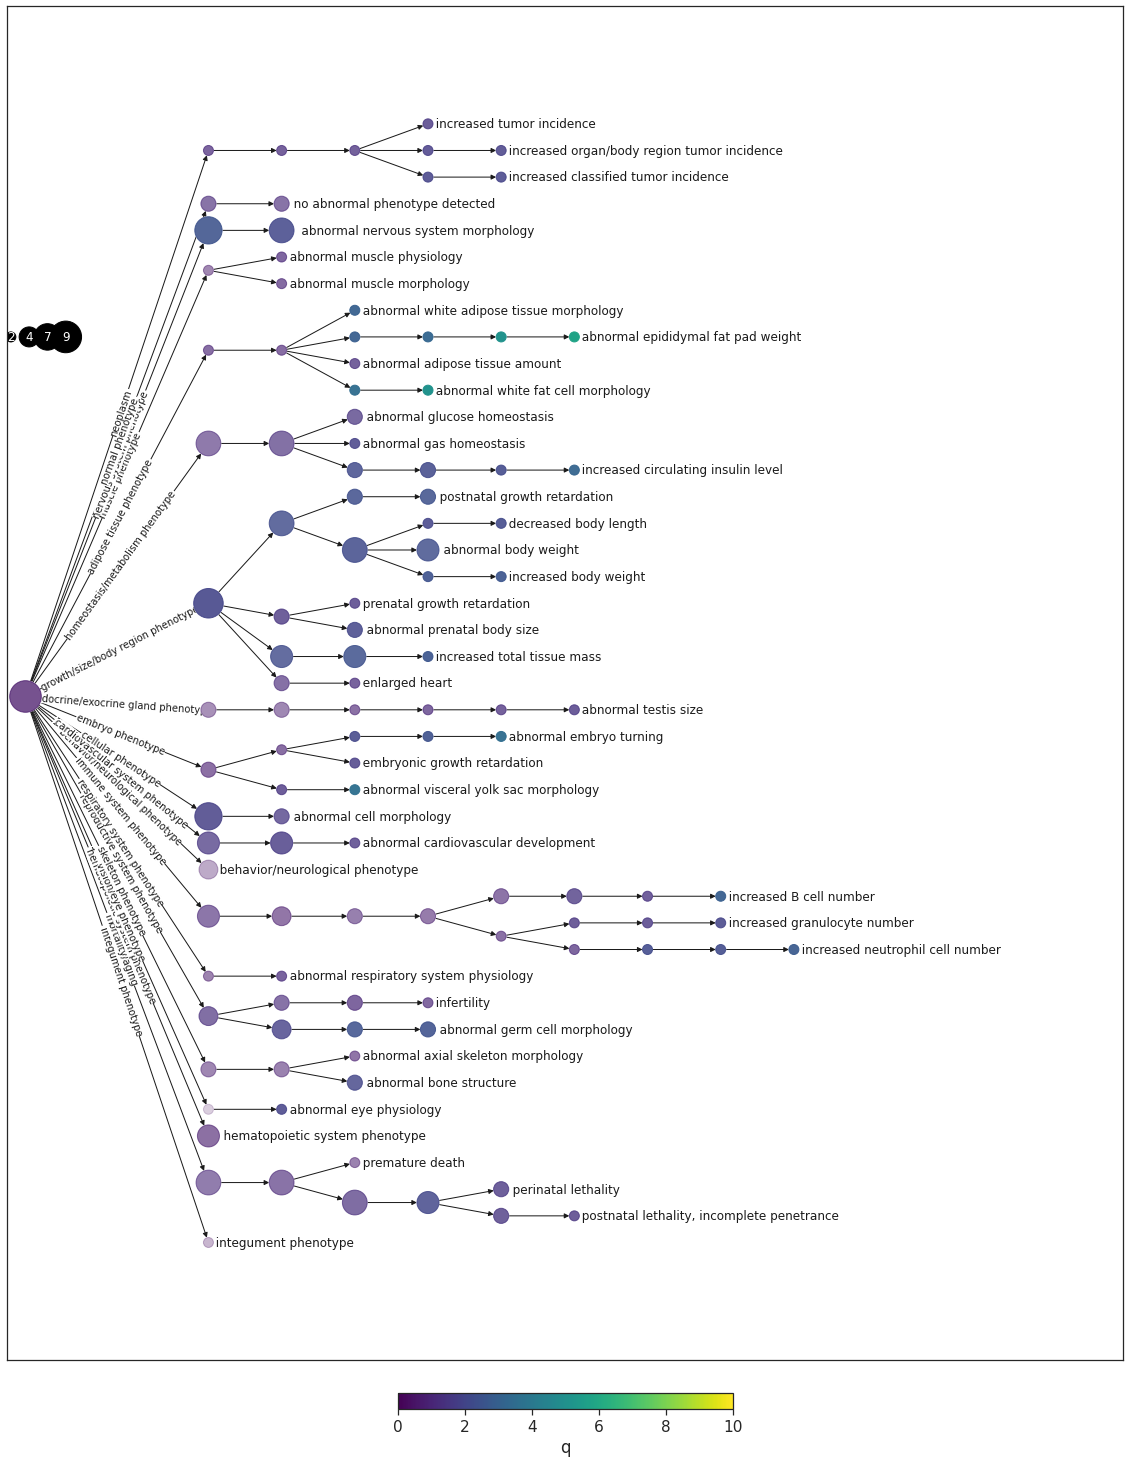

In [305]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C900", "MP:0000001", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="ppv", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=30, label="leaf", 
                                descriptive_labels=True, adjust_root=0.3)


### Nervous System

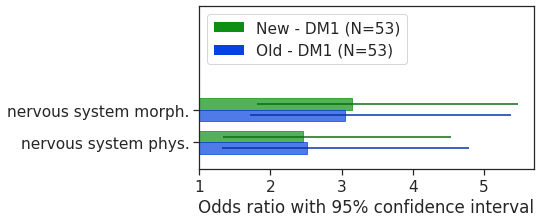

In [509]:
a = plot_hbar_comparison(all_results[all_results.observed>=2], communities=["C882", "C882_old"], mps="MP:0003631", horz=6, vert = 3,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - DM1", "Old - DM1"], sort_by="observed", label_number="percent_community")

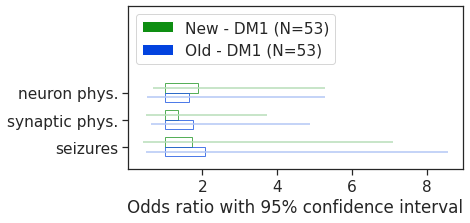

In [510]:
a = plot_hbar_comparison(all_results[all_results.observed>=2], communities=["C882", "C882_old"], mps="MP:0003633", horz=6, vert = 3,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - DM1", "Old - DM1"], sort_by="observed", label_number="percent_community")

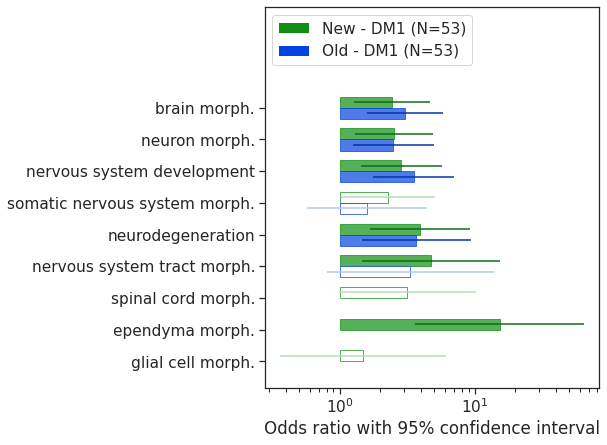

In [512]:
a = plot_hbar_comparison(all_results[all_results.observed>=2], communities=["C882", "C882_old"], mps="MP:0003632", horz=6, vert = 7,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - DM1", "Old - DM1"], sort_by="observed", label_number="percent_community")

PARENT: MP:0003631 nervous system phenotype


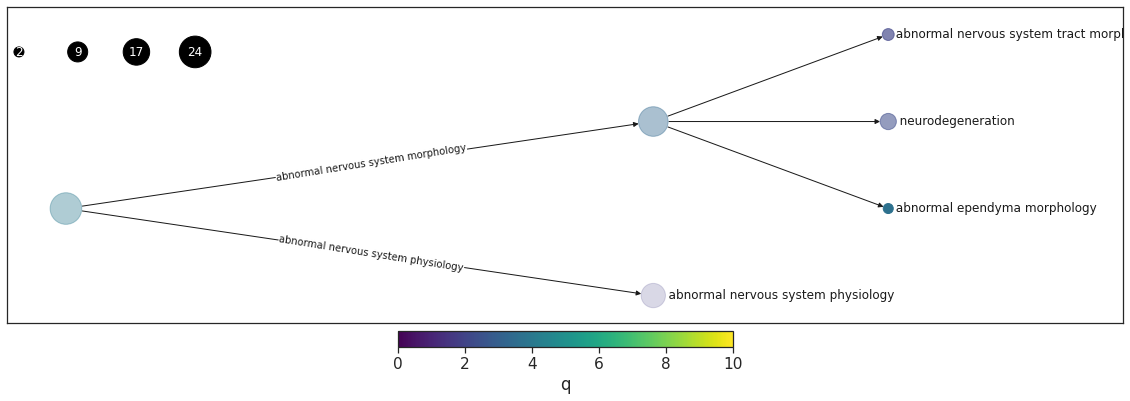

no hits passing filters


In [310]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C882", "MP:0003631", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="hypergeom", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", 
                                descriptive_labels=True, adjust_root=0.3)
get_hits(n, results, p=0.01, OR=2, obs_min=7, total=10000, level=3)

### Cellular

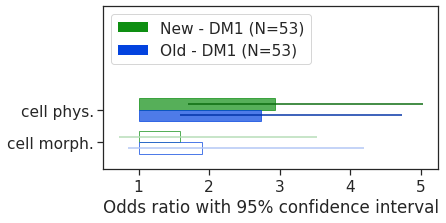

In [489]:
a = plot_hbar_comparison(all_results[all_results.observed>=2], communities=["C882", "C882_old"], mps="MP:0005384", horz=6, vert = 3,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - DM1", "Old - DM1"], sort_by="observed", label_number="percent_community")


PARENT: MP:0005384 cellular phenotype


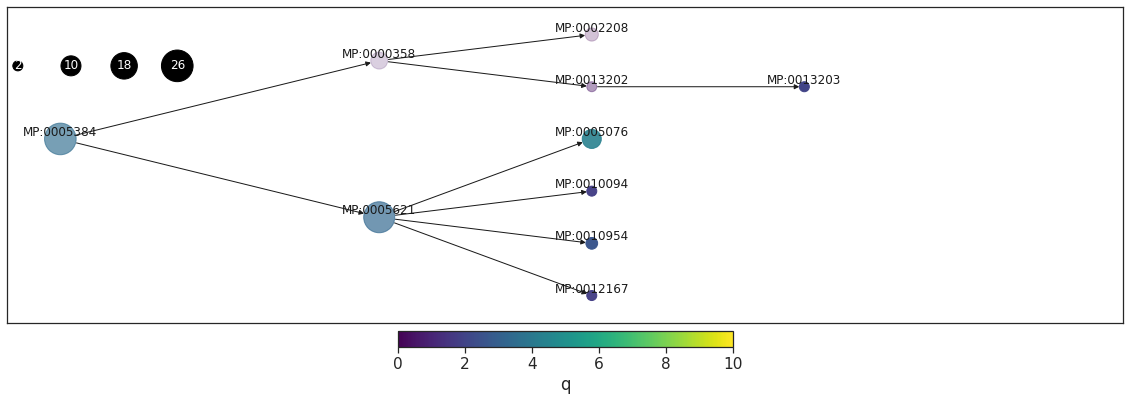

no hits passing filters


In [491]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C882", "MP:0005384", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="hypergeom", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="all", 
                                descriptive_labels=True, adjust_root=0.1)
get_hits(n, results, p=0.01, OR=2, obs_min=7, total=10000, level=3)


### Embryo

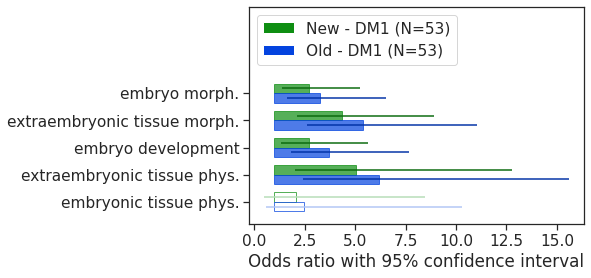

In [492]:
a = plot_hbar_comparison(all_results[all_results.observed>=2], communities=["C882", "C882_old"], mps="MP:0005380", horz=6, vert = 4,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - DM1", "Old - DM1"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005380 embryo phenotype


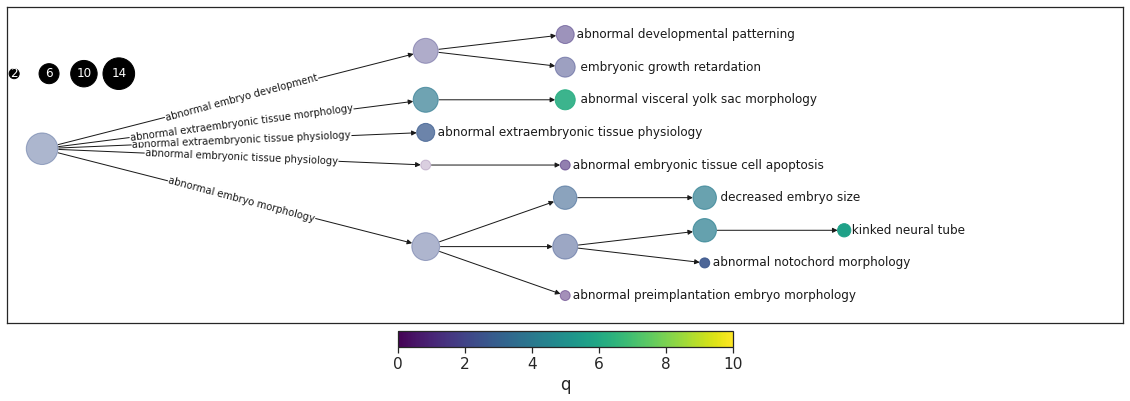

no hits passing filters


In [495]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C882", "MP:0005380", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="hypergeom", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", 
                                descriptive_labels=True, adjust_root=0.35)
get_hits(n, results, p=0.01, OR=2, obs_min=7, total=10000, level=3)

### Growth/body size

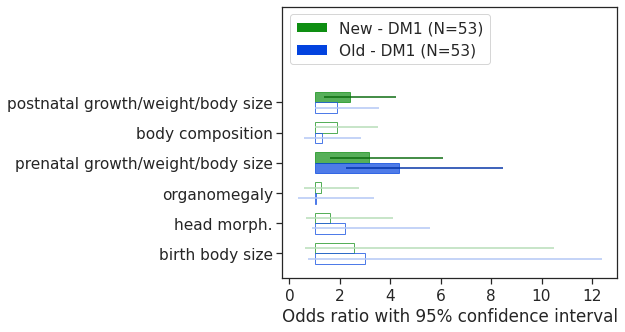

In [496]:
a = plot_hbar_comparison(all_results[all_results.observed>=2], communities=["C882", "C882_old"], mps="MP:0005378", horz=6, vert = 5,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - DM1", "Old - DM1"], sort_by="observed", label_number="percent_community")

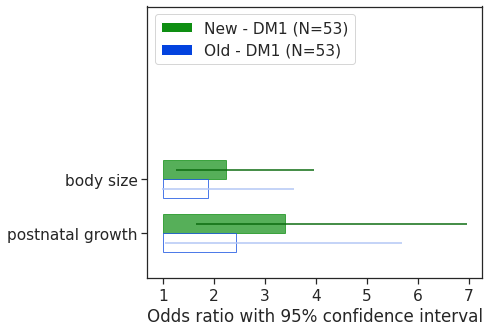

In [499]:
a = plot_hbar_comparison(all_results[all_results.observed>=2], communities=["C882", "C882_old"], mps="MP:0002089", horz=6, vert = 5,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - DM1", "Old - DM1"], sort_by="observed", label_number="percent_community")

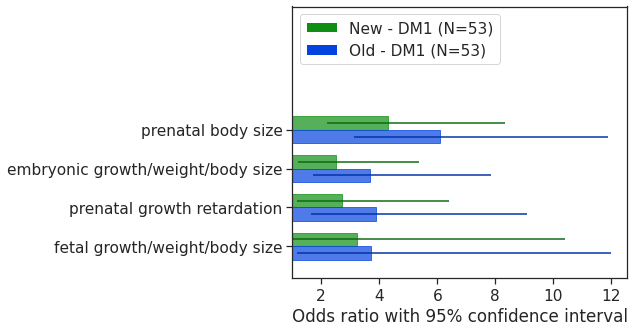

In [501]:
a = plot_hbar_comparison(all_results[all_results.observed>=2], communities=["C882", "C882_old"], mps="MP:0004196", horz=6, vert = 5,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - DM1", "Old - DM1"], sort_by="observed", label_number="percent_community")

PARENT: MP:0004196 abnormal prenatal growth/weight/body size


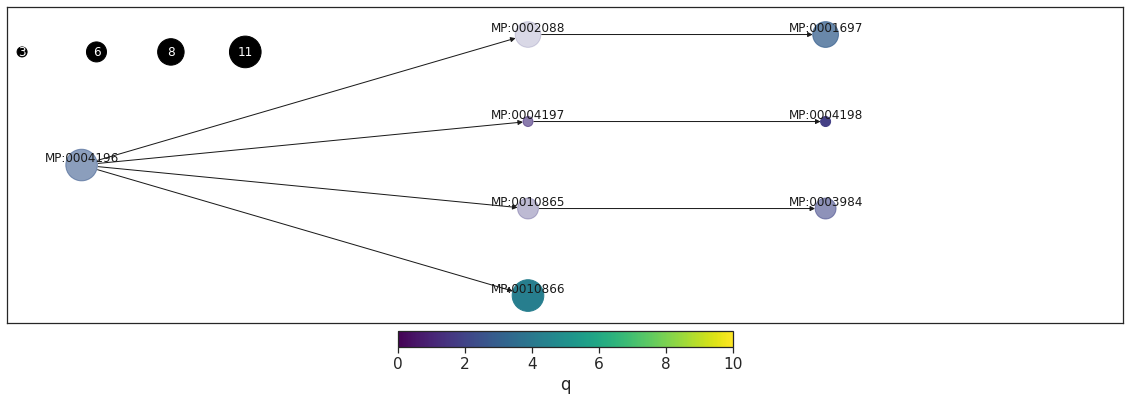

no hits passing filters


In [503]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C882", "MP:0004196", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="hypergeom", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="all", 
                                descriptive_labels=True, adjust_root=0.1)
get_hits(n, results, p=0.01, OR=2, obs_min=7, total=10000, level=3)

PARENT: MP:0002089 abnormal postnatal growth/weight/body size


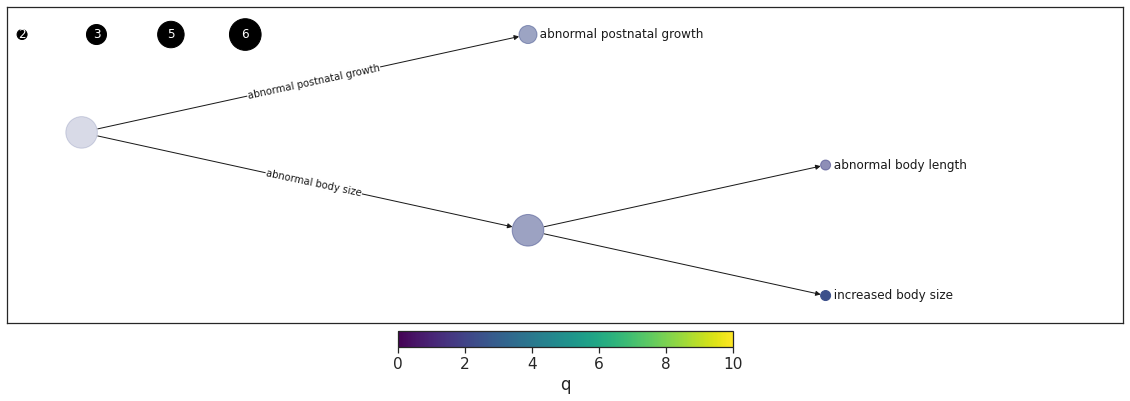

no hits passing filters


In [504]:
# check the C900 postnatal body size signal
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C900", "MP:0002089", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="hypergeom", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)
get_hits(n, results, p=0.01, OR=2, obs_min=3, total=10000, level=3)

### respiratory

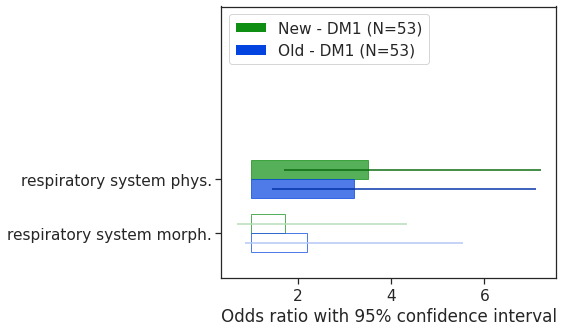

In [507]:
a = plot_hbar_comparison(all_results[all_results.observed>=2], communities=["C882", "C882_old"], mps="MP:0005388", horz=6, vert = 5,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - DM1", "Old - DM1"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005388 respiratory system phenotype


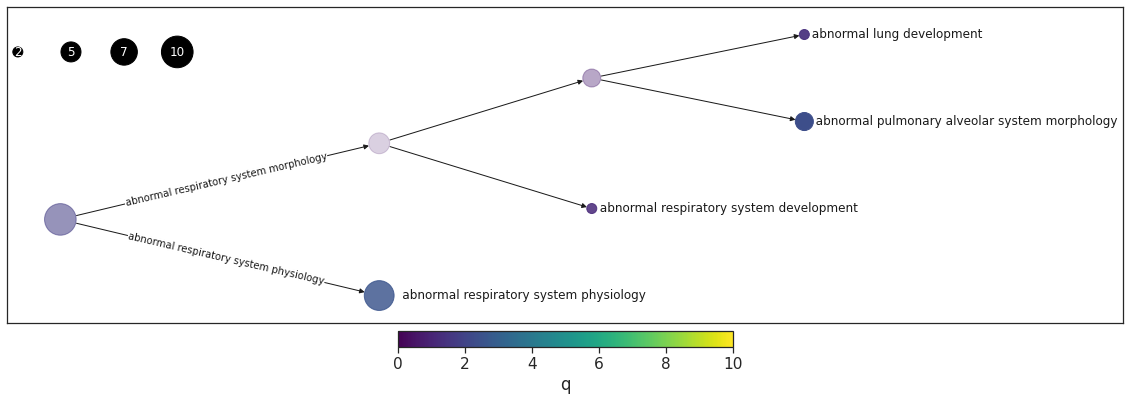

no hits passing filters


In [532]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C882", "MP:0005388", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="hypergeom", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)
get_hits(n, results, p=0.01, OR=2, obs_min=7, total=10000, level=3)

### Skeleton

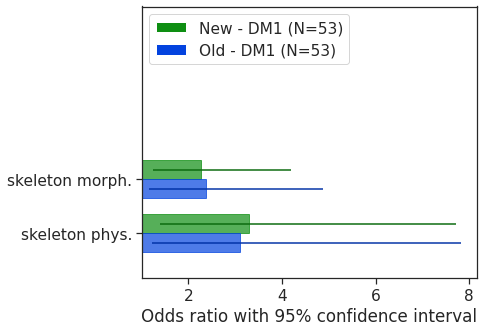

In [533]:
a = plot_hbar_comparison(all_results[all_results.observed>=2], communities=["C882", "C882_old"], mps="MP:0005390", horz=6, vert = 5,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - DM1", "Old - DM1"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005390 skeleton phenotype


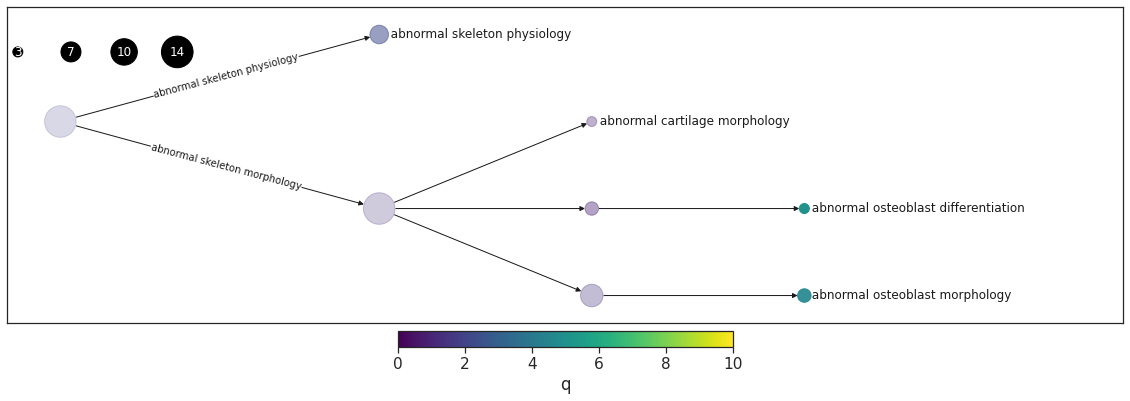

no hits passing filters


In [534]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C882", "MP:0005390", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="hypergeom", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)
get_hits(n, results, p=0.01, OR=2, obs_min=7, total=10000, level=3)

In [535]:
n

OR         q  obs  \
MP:0005390   2.151037  1.848660   14   
MP:0005508   2.270562  1.218284   14   
MP:0003795   2.487043  1.446085    8   
MP:0004986   9.259831  4.635670    4   
MP:0002113   2.787281  1.004369    4   
MP:0008395  14.563636  5.016156    3   
MP:0000163   2.570888  0.945464    3   
MP:0001533   3.285143  2.202111    6   

                                                         hits  
MP:0005390  [SPG7, DOCK2, UTRN, KDM3A, CCP110, ZNF106, SP3...  
MP:0005508  [SPG7, DOCK2, UTRN, KDM3A, CCP110, ZNF106, SP3...  
MP:0003795  [DOCK2, KDM3A, SP3, KDM6B, NBR1, GDAP2, KDM6A,...  
MP:0004986                          [NBR1, USP34, SP3, KDM6B]  
MP:0002113                           [NBR1, STK4, SP3, KDM6B]  
MP:0008395                                 [NBR1, SP3, KDM6B]  
MP:0000163                              [CCP110, STK4, KDM6B]  
MP:0001533            [CCP110, SP3, KDM6B, NBR1, STK4, USP34]

### Mortality/aging

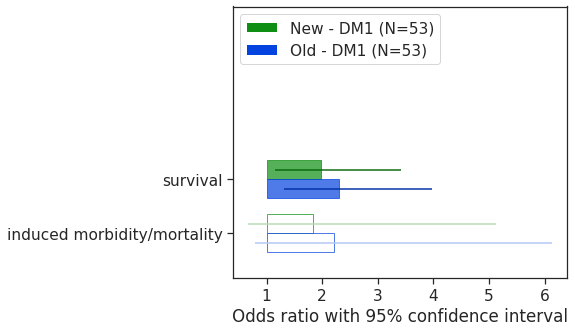

In [505]:
a = plot_hbar_comparison(all_results[all_results.observed>=2], communities=["C882", "C882_old"], mps="MP:0010768", horz=6, vert = 5,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - DM1", "Old - DM1"], sort_by="observed", label_number="percent_community")

PARENT: MP:0010768 mortality/aging


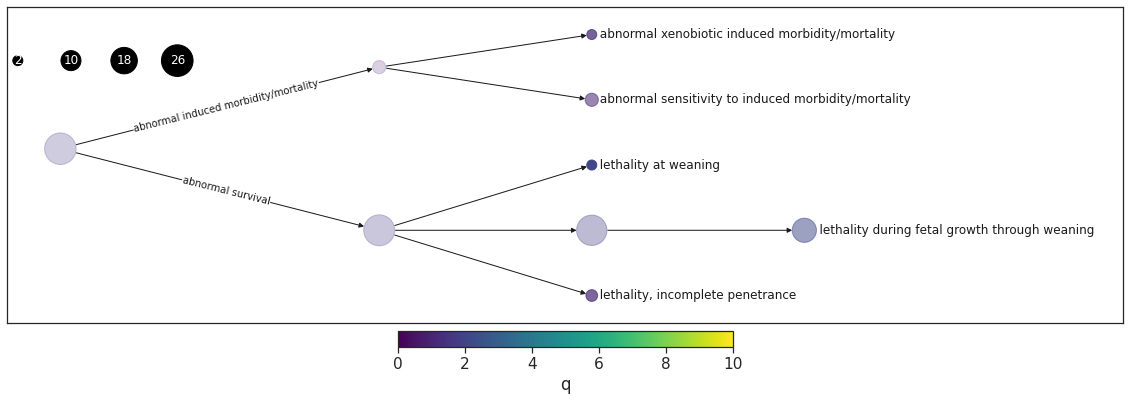

no hits passing filters


In [506]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C882", "MP:0010768", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="hypergeom", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)
get_hits(n, results, p=0.01, OR=2, obs_min=7, total=10000, level=3)

### Homeostasis/metabolism

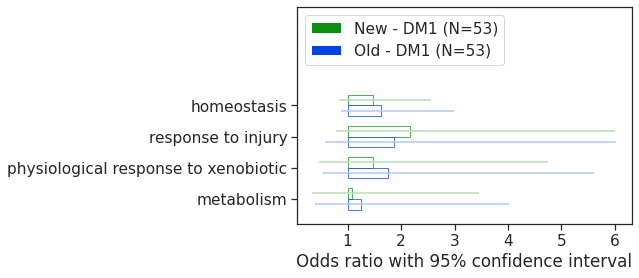

In [314]:
a = plot_hbar_comparison(all_results[all_results.observed>=2], communities=["C882", "C882_old"], mps="MP:0005376", horz=6, vert = 4,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - DM1", "Old - DM1"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005376 homeostasis/metabolism phenotype


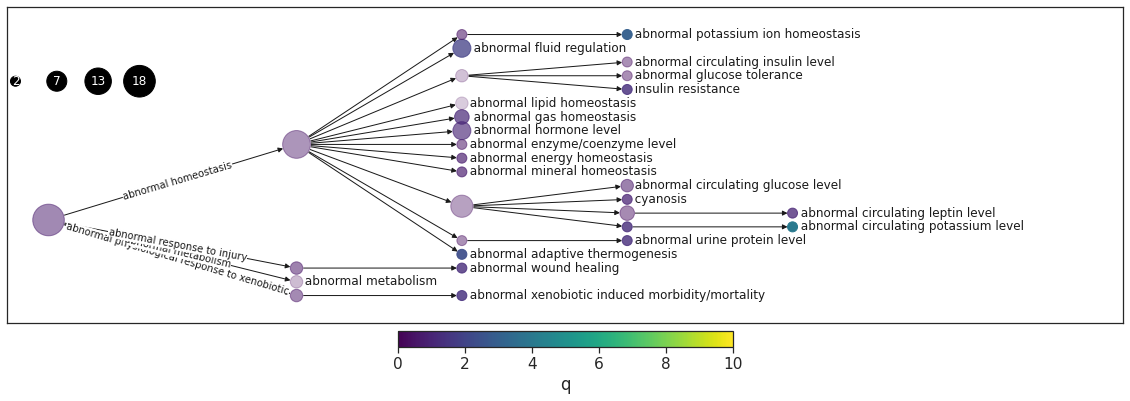

Empty DataFrame
Columns: [OR, q, obs, hits, total, description, depth]
Index: []

In [578]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C882", "MP:0005376", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="hypergeom", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)
get_hits(n, results, p=0.01, OR=2, obs_min=7, total=10000, level=3)

### Cardiovascular

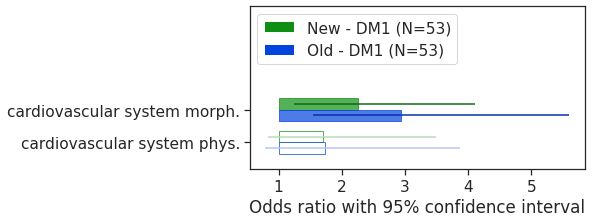

In [315]:
a = plot_hbar_comparison(all_results[all_results.observed>=2], communities=["C882", "C882_old"], mps="MP:0005385", horz=6, vert = 3,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - DM1", "Old - DM1"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005385 cardiovascular system phenotype


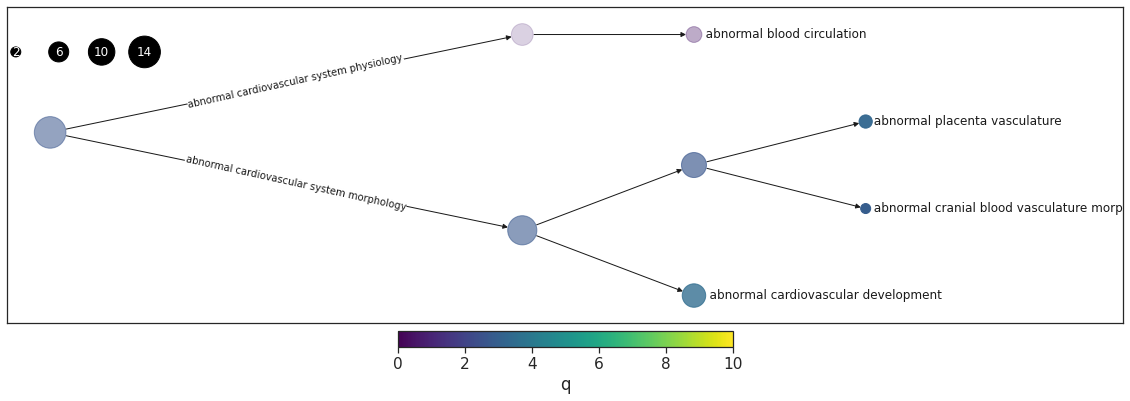

OR         q  obs  \
MP:0002925  4.443213  3.482551  8.0   
MP:0001614  3.310752  2.691109  9.0   

                                                         hits   total  \
MP:0002925  [KDM6A, WNK1, AXIN1, UBR2, KDM8, STK4, CCP110,...   730.0   
MP:0001614  [ZBTB20, JMJD8, WNK1, HPS4, SP3, UBR2, STK4, K...  1101.0   

                                    description  depth  
MP:0002925  abnormal cardiovascular development      3  
MP:0001614     abnormal blood vessel morphology      3

In [579]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C882", "MP:0005385", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="hypergeom", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", 
                                descriptive_labels=True, adjust_root=0.35)
get_hits(n, results, p=0.01, OR=2, obs_min=7, total=10000, level=3)

## MSC - C907

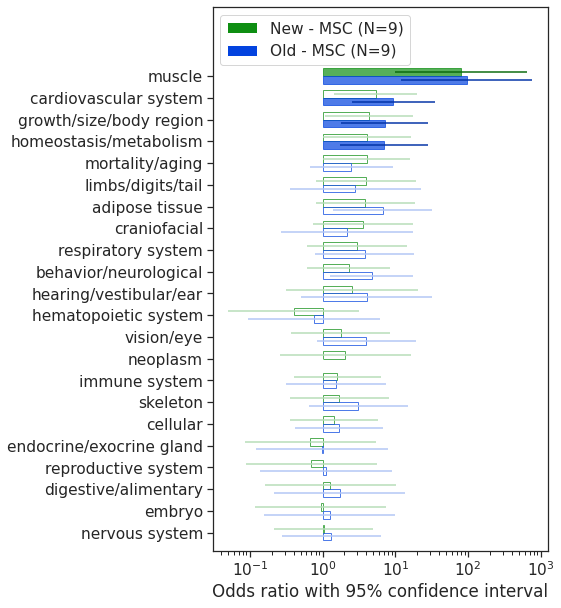

In [485]:
a = plot_hbar_comparison(all_results, communities=["C907", "C907_old"], mps=top_level, horz=6, vert = 10,
                         sig_level=0.05, community_names=["New - MSC", "Old - MSC"], sort_by="q", label_number="percent_community",
                        correct_by_community=True)

PARENT: MP:0000001 mammalian phenotype


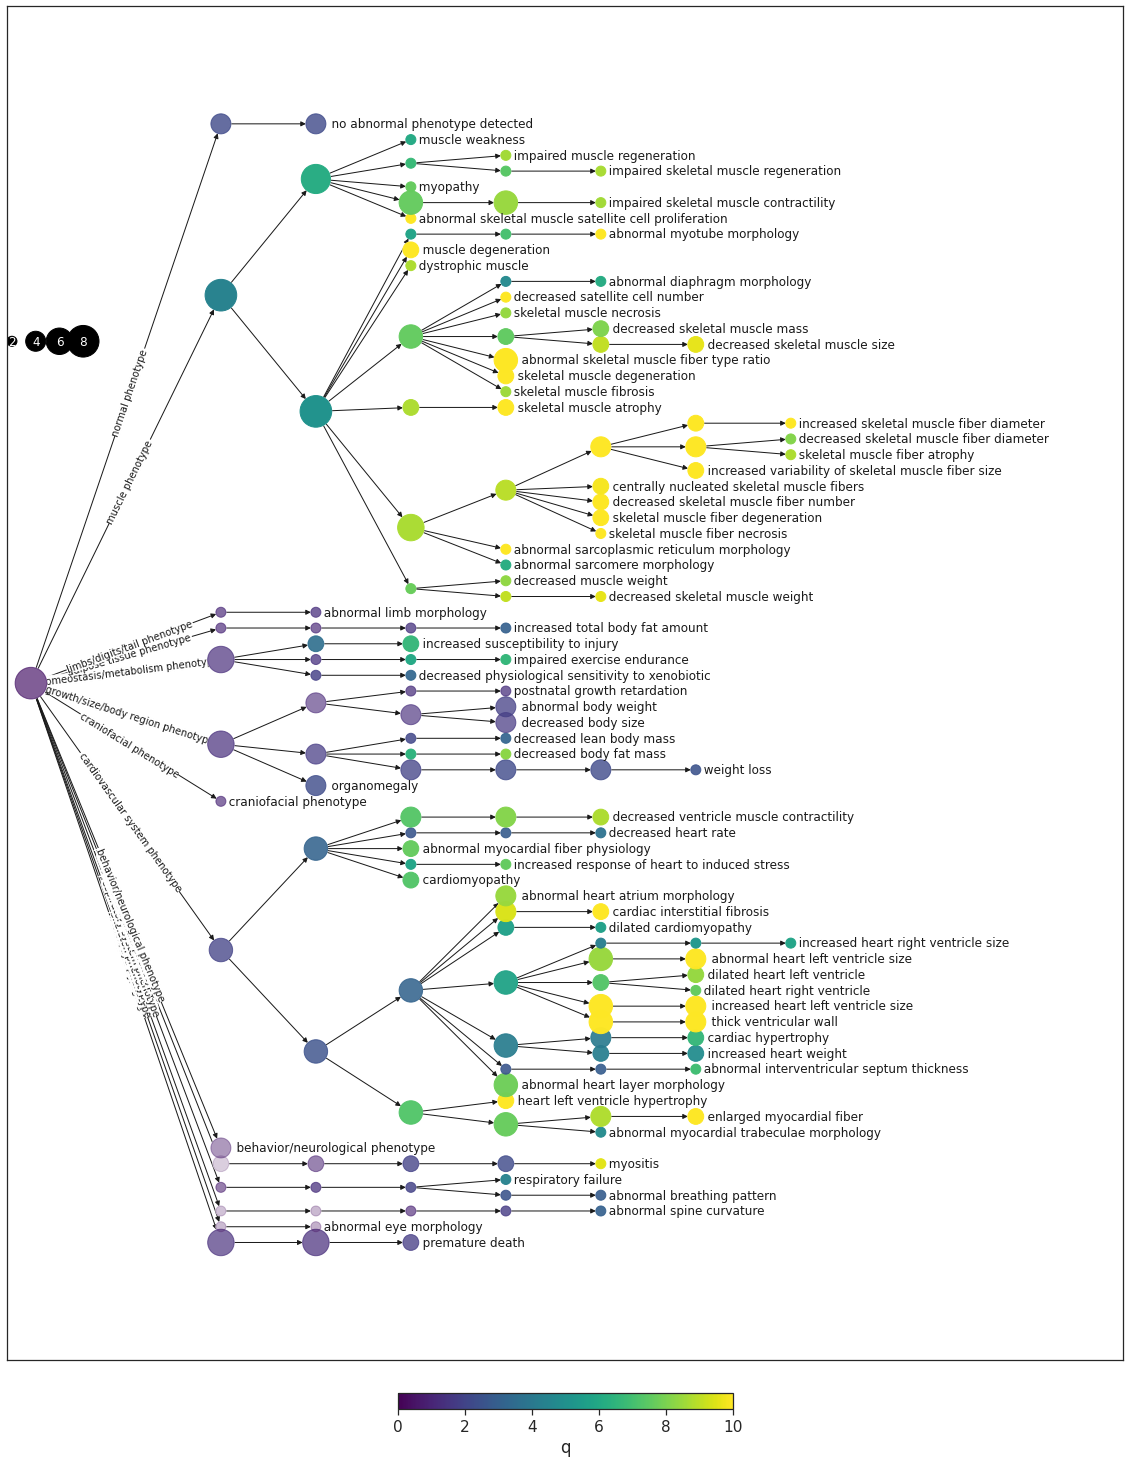

In [543]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C907", "MP:0000001", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="ppv", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=30, label="leaf", 
                                descriptive_labels=True, adjust_root=0.2)

### Muscle

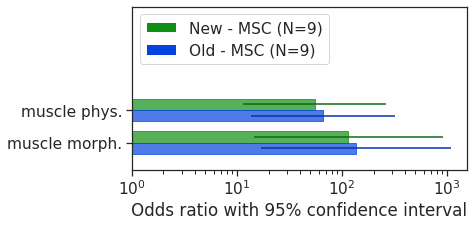

In [468]:
a = plot_hbar_comparison(all_results.loc[all_results.observed>=2], communities=["C907", "C907_old"], mps="MP:0005369", horz=6, vert=3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - MSC", "Old - MSC"], sort_by="q", label_number="percent_community")


PARENT: MP:0002106 abnormal muscle physiology


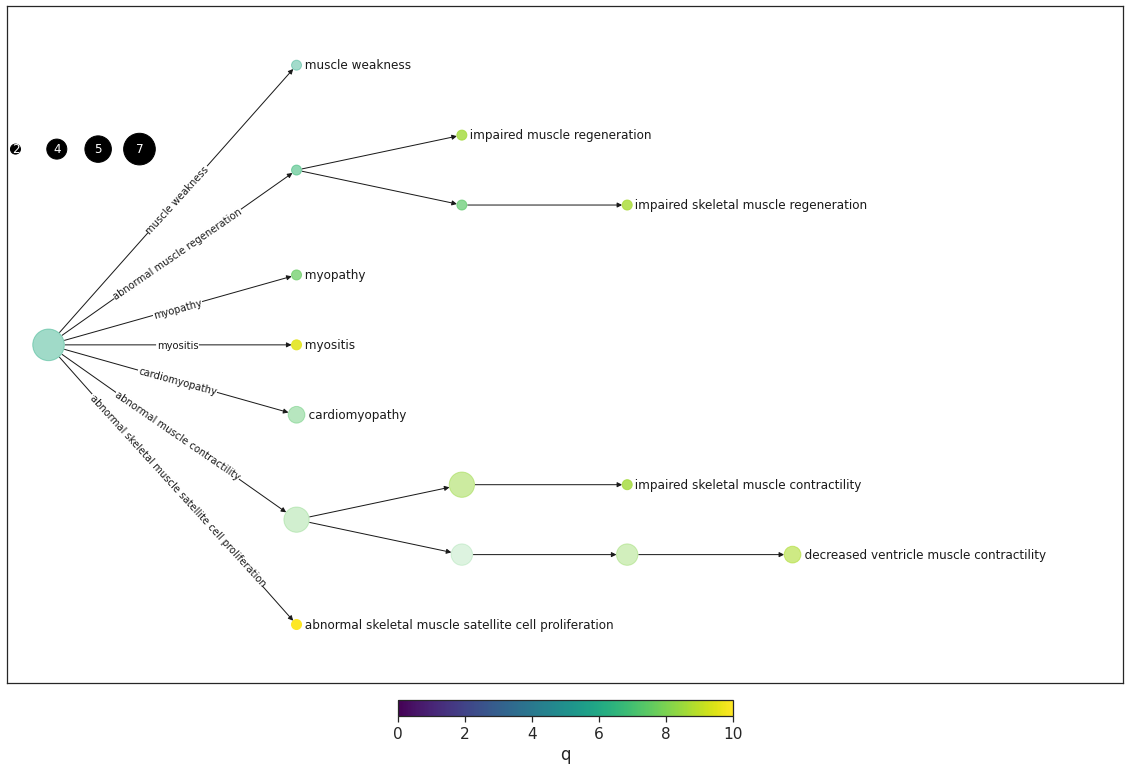

no hits passing filters


In [470]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C907", "MP:0002106", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="ppv", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=15, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)
get_hits(n, results, p=0.01, OR=2, obs_min=3, total=10000, level=3)

PARENT: MP:0002108 abnormal muscle morphology


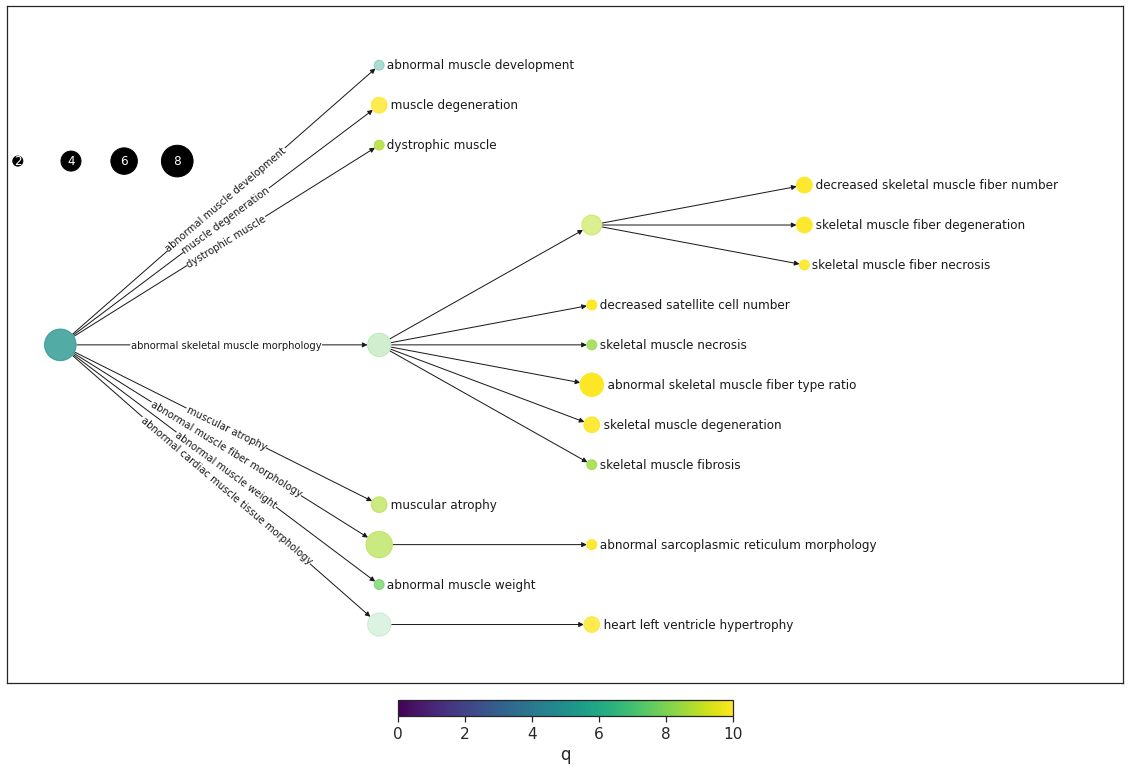

no hits passing filters


In [471]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C907", "MP:0002108", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="hypergeom", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=15, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)
get_hits(n, results, p=0.01, OR=2, obs_min=3, total=10000, level=3)

### Cardiovascular

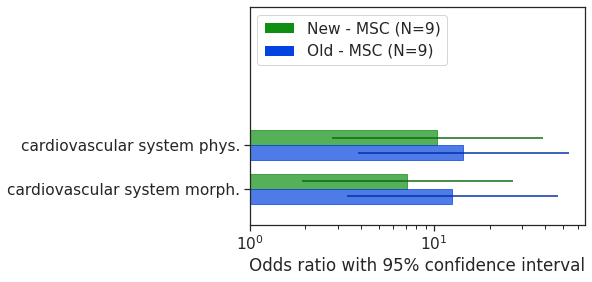

In [483]:
a = plot_hbar_comparison(all_results.loc[all_results.observed>=2], communities=["C907", "C907_old"], mps="MP:0005385", horz=6, vert=4, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - MSC", "Old - MSC"], sort_by="q", label_number="percent_community")

PARENT: MP:0005385 cardiovascular system phenotype


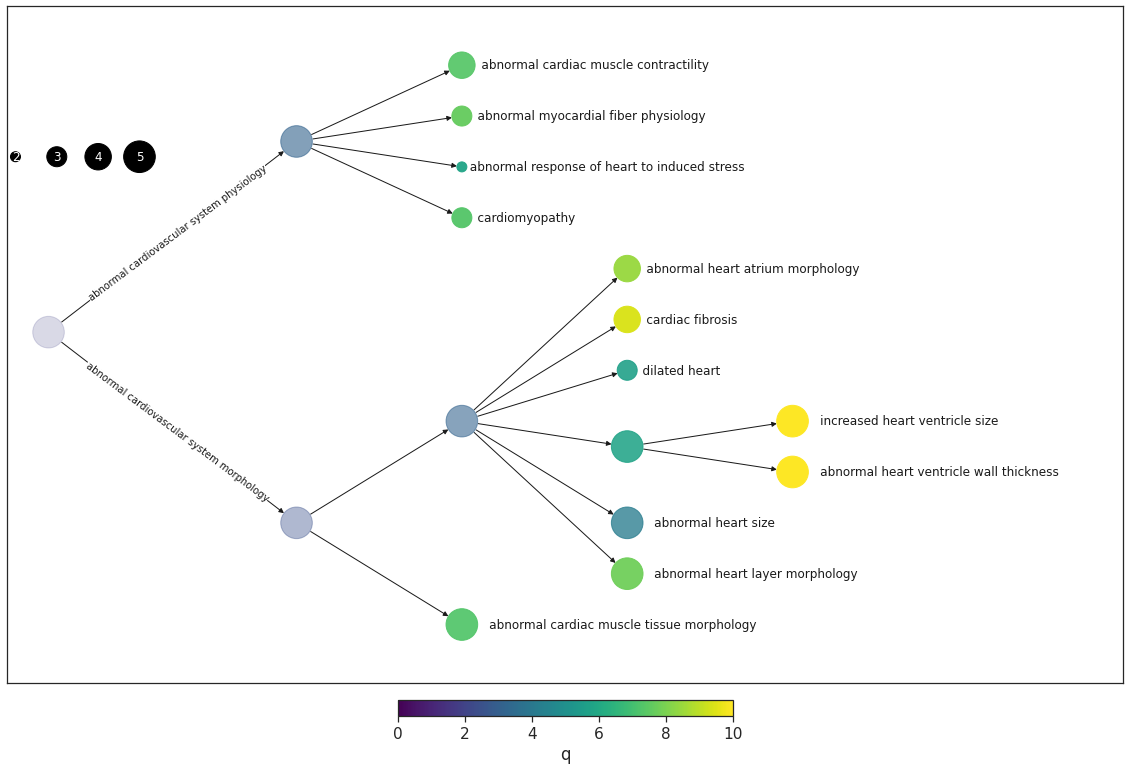

no hits passing filters


In [484]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C907", "MP:0005385", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="hypergeom", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=15, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)
get_hits(n, results, p=0.01, OR=2, obs_min=3, total=10000, level=3)

### Growth/body size

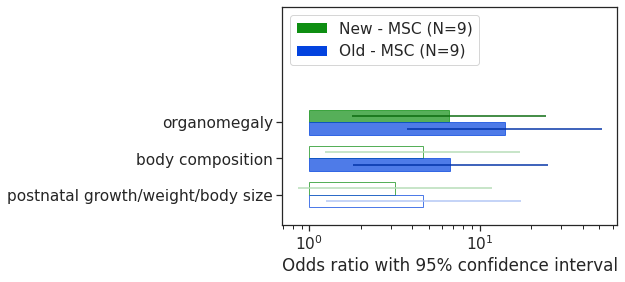

In [478]:
a = plot_hbar_comparison(all_results.loc[all_results.observed>=2], communities=["C907", "C907_old"], mps="MP:0005378", horz=6, vert=4, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - MSC", "Old - MSC"], sort_by="q", label_number="percent_community")

PARENT: MP:0002089 abnormal postnatal growth/weight/body size


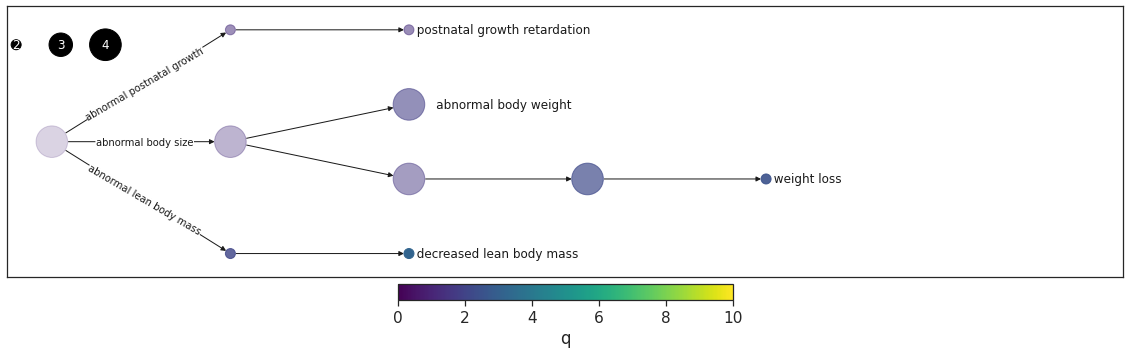

no hits passing filters


In [479]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C907", "MP:0002089", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="ppv", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=6, label="leaf", 
                                descriptive_labels=True)
get_hits(n, results, p=0.01, OR=2, obs_min=3, total=10000, level=3)

PARENT: MP:0005451 abnormal body composition


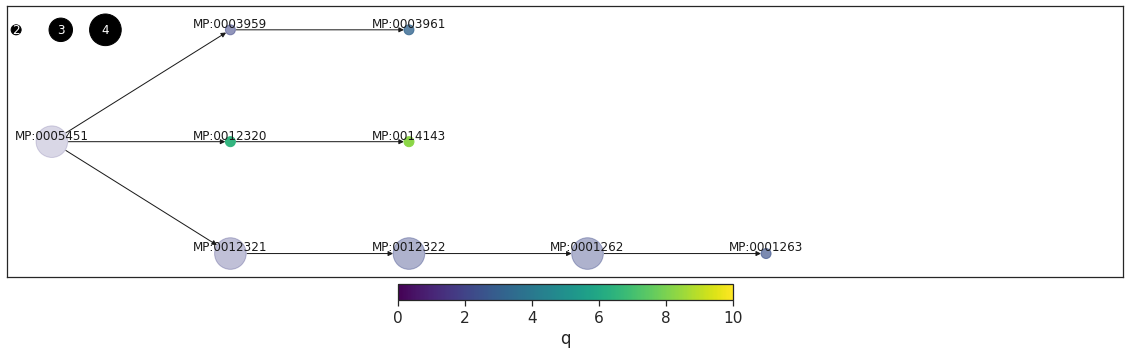

no hits passing filters


In [482]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C907", "MP:0005451", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="ppv", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=6, label="all", 
                                descriptive_labels=True)
get_hits(n, results, p=0.01, OR=2, obs_min=3, total=10000, level=3)

### Homeostasis/metabolism

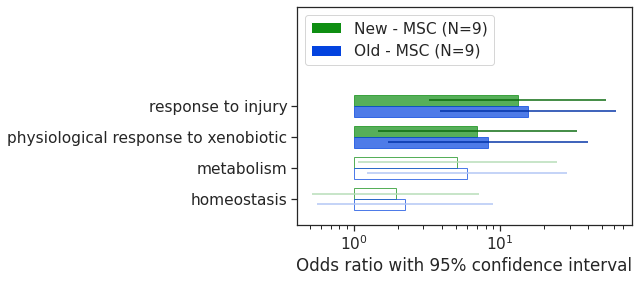

In [472]:
a = plot_hbar_comparison(all_results.loc[all_results.observed>=2], communities=["C907", "C907_old"], mps="MP:0005376", horz=6, vert=4, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - MSC", "Old - MSC"], sort_by="q", label_number="percent_community")

PARENT: MP:0005376 homeostasis/metabolism phenotype


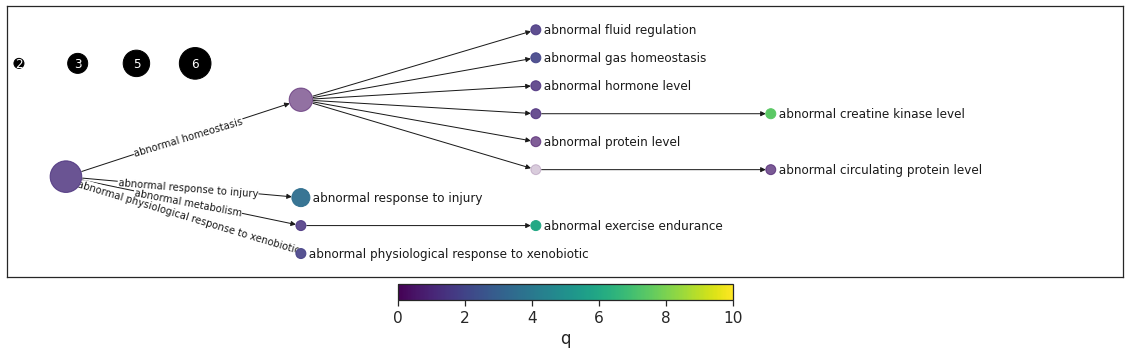

no hits passing filters


In [475]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C907", "MP:0005376", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="hypergeom", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=6, label="leaf", 
                                descriptive_labels=True)
get_hits(n, results, p=0.01, OR=2, obs_min=3, total=10000, level=2)

## PP/MPK2 - C889/C917

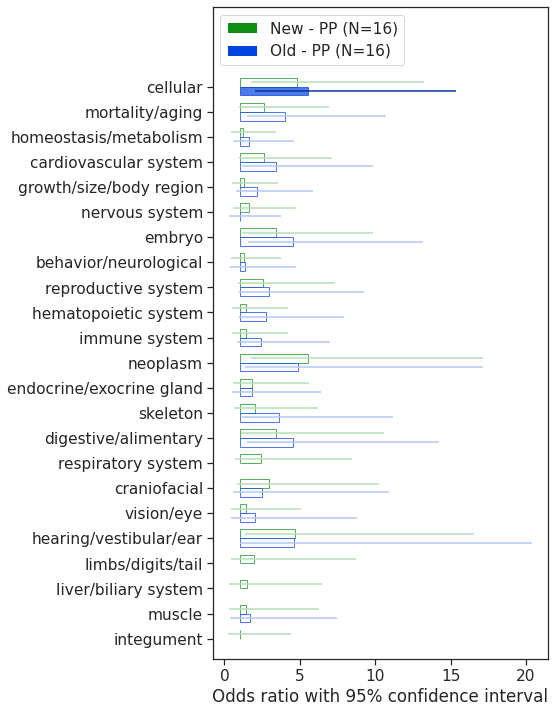

In [539]:
a = plot_hbar_comparison(all_results[all_results.observed>=2], communities=["C889", "C889_old"], mps=top_level, horz=6, vert = 12,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - PP", "Old - PP"], sort_by="observed", label_number="percent_community", 
                        correct_by_community=False)

PARENT: MP:0000001 mammalian phenotype


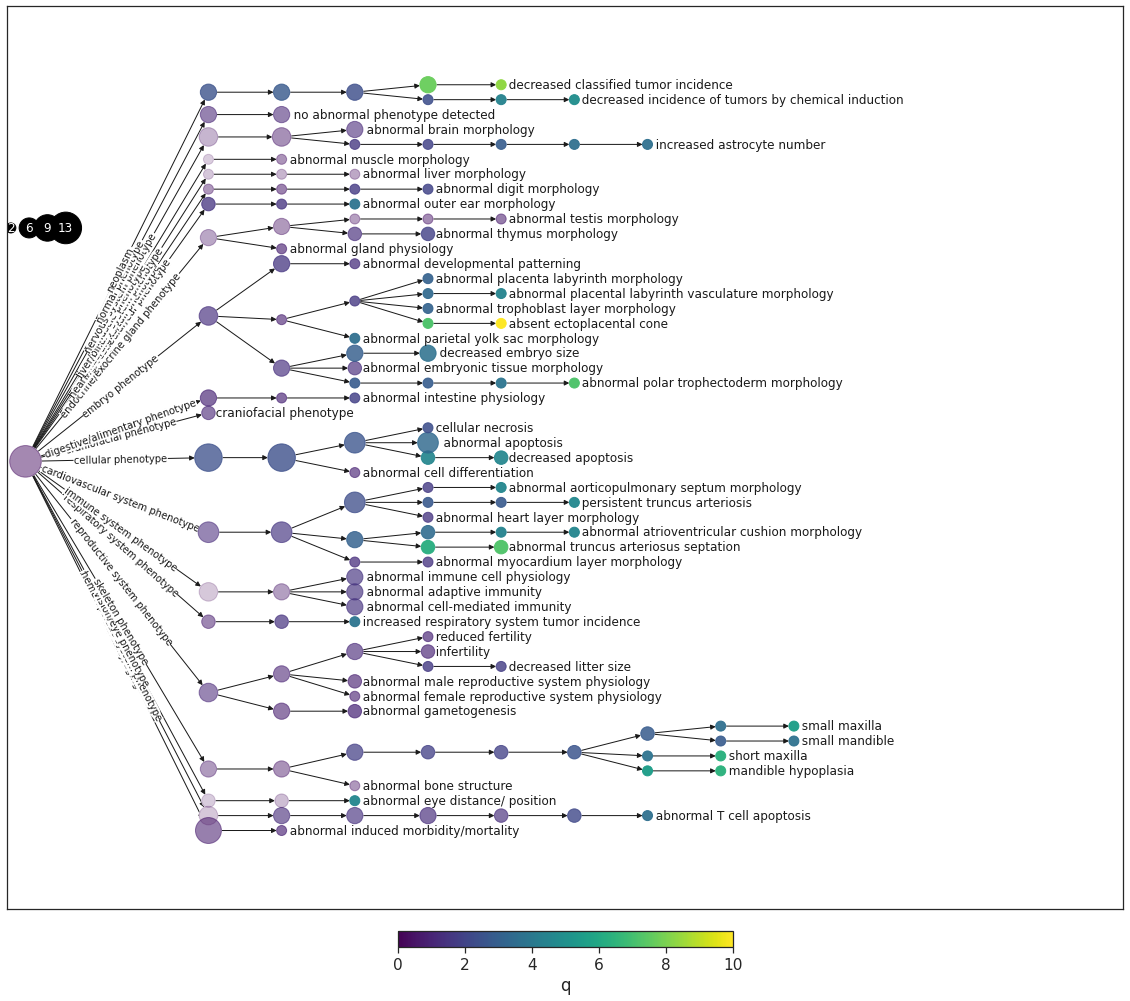

no hits passing filters


In [540]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C889", "MP:0000001", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="ppv", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=20, label="leaf", 
                                descriptive_labels=True, adjust_root=0.3)
get_hits(n, results, p=0.01, OR=2, obs_min=3, total=1000, level=2)

PARENT: MP:0000001 mammalian phenotype


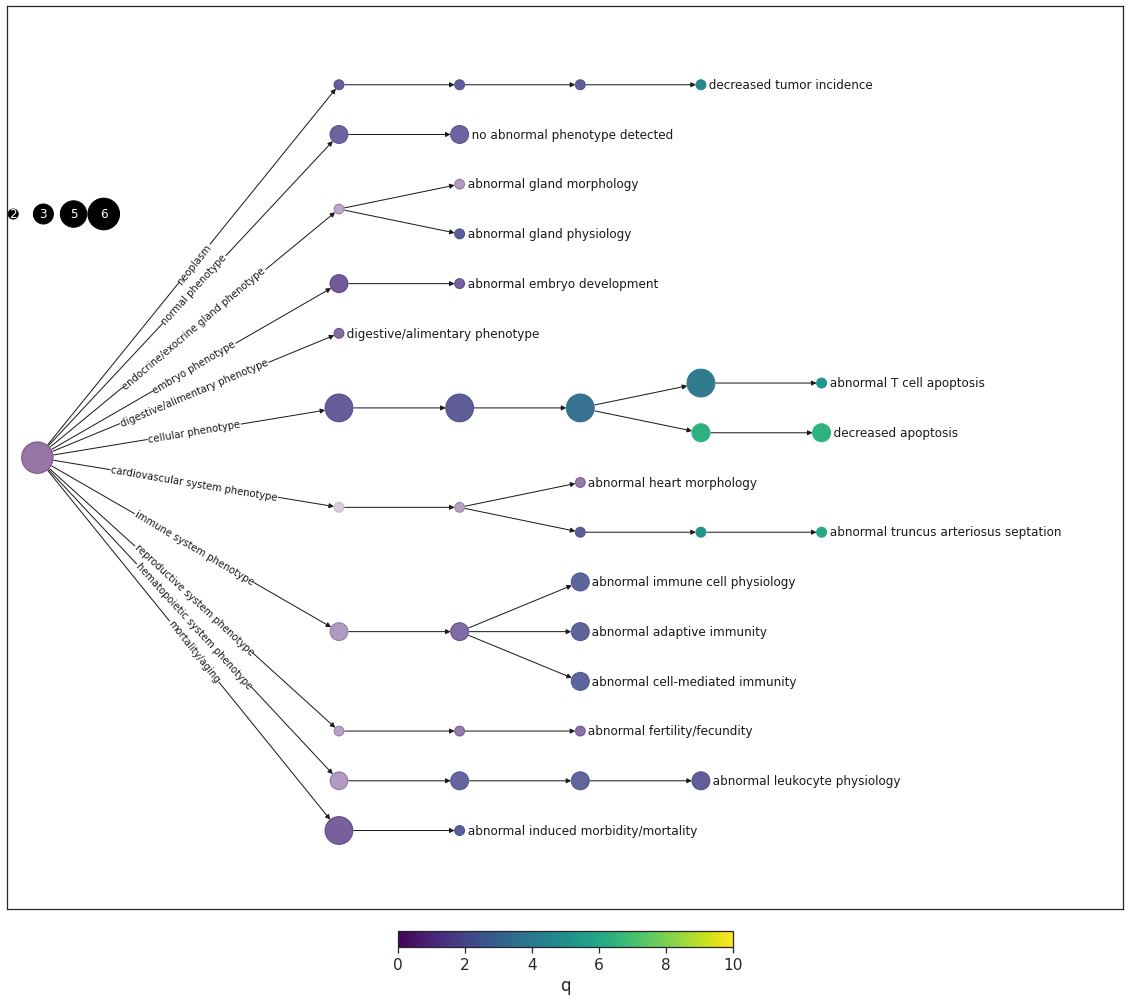

no hits passing filters


In [541]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C917", "MP:0000001", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="ppv", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=20, label="leaf", 
                                descriptive_labels=True, adjust_root=0.3)
get_hits(n, results, p=0.01, OR=2, obs_min=3, total=1000, level=2)

### Cellular

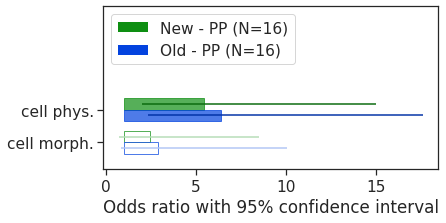

In [437]:
a = plot_hbar_comparison(all_results.loc[all_results.observed>=2], communities=["C889", "C889_old"], mps="MP:0005384", horz=6, vert=3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - PP", "Old - PP"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005384 cellular phenotype


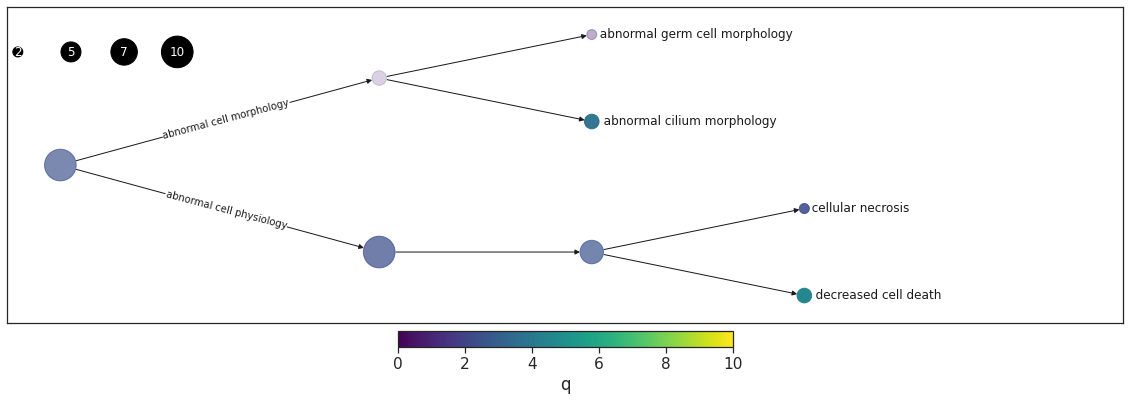

no hits passing filters


In [443]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C889", "MP:0005384", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="hypergeom", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)
get_hits(n, results, p=0.01, OR=2, obs_min=3, total=1000, level=2)

In [441]:
n

OR         q  obs  \
MP:0005384   4.795189  2.441418   10   
MP:0005621   5.456061  2.420002   10   
MP:0000313   5.150459  2.596094    6   
MP:0012555  14.889038  4.570337    3   
MP:0000316   8.722772  2.368748    2   
MP:0000358   2.413585  0.771393    3   
MP:0013202  11.924370  3.637819    3   
MP:0002208   2.895928  0.795953    2   

                                                         hits  
MP:0005384  [MAP2K6, MAP2K1, CAMK2G, MAPK1, MAP2K3, CAMK4,...  
MP:0005621  [MAP2K6, MAP2K1, CAMK2G, MAPK1, MAP2K3, CAMK4,...  
MP:0000313    [MAP2K6, MAP2K1, CAMK2G, MAPK1, MAP2K3, MAP2K5]  
MP:0012555                           [MAP2K6, CAMK2G, MAP2K3]  
MP:0000316                                    [MAPK1, MAP2K1]  
MP:0000358                              [STK33, TTBK2, CAMK4]  
MP:0013202                              [STK33, TTBK2, CAMK4]  
MP:0002208                                     [STK33, CAMK4]

### Mortality/aging

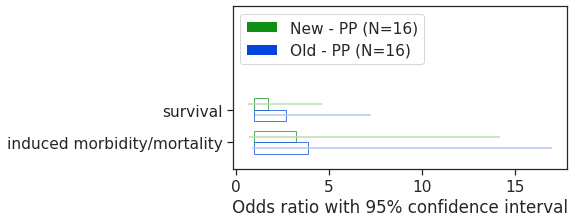

In [444]:
a = plot_hbar_comparison(all_results.loc[all_results.observed>=2], communities=["C889", "C889_old"], mps="MP:0010768", horz=6, vert=3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - PP", "Old - PP"], sort_by="observed", label_number="percent_community")

PARENT: MP:0010768 mortality/aging


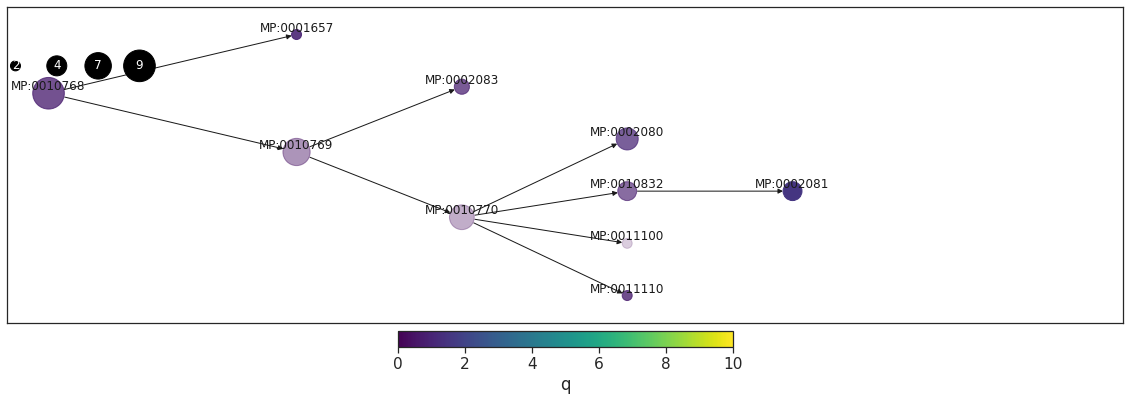

no hits passing filters


In [448]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C889", "MP:0010768", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="hypergeom", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="all", 
                                descriptive_labels=True, adjust_root=0.1)
get_hits(n, results, p=0.01, OR=2, obs_min=3, total=10000, level=3)

### Neoplasm

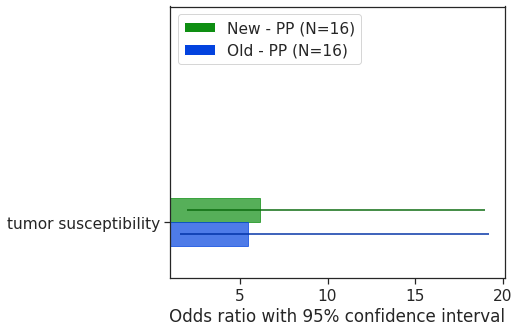

In [460]:
a = plot_hbar_comparison(all_results.loc[all_results.observed>=2], communities=["C889", "C889_old"], mps="MP:0002006",horz=6, vert=5, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - PP", "Old - PP"], sort_by="observed", label_number="percent_community")

PARENT: MP:0002006 neoplasm


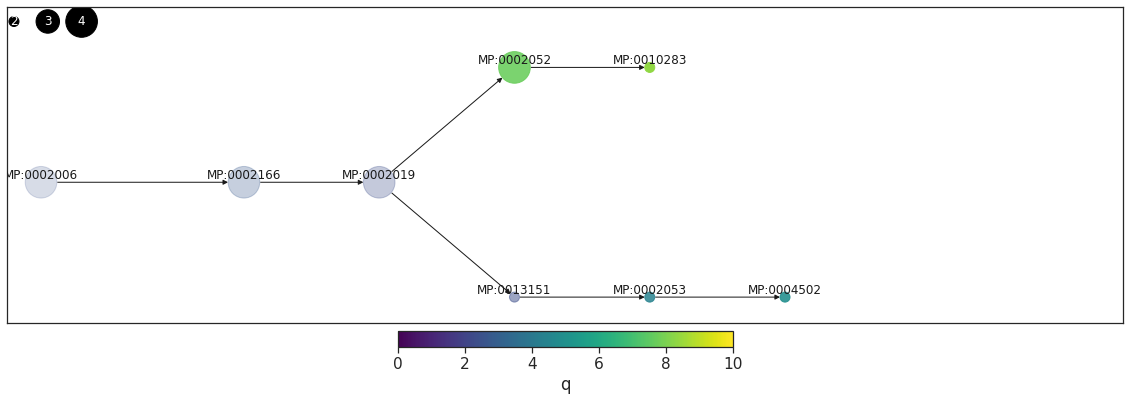

no hits passing filters


In [462]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C889", "MP:0002006", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="ppv", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="all", 
                                descriptive_labels=True, adjust_root=0.1)
get_hits(n, results, p=0.1, OR=2, obs_min=2, total=1000, level=2)

### Embryo

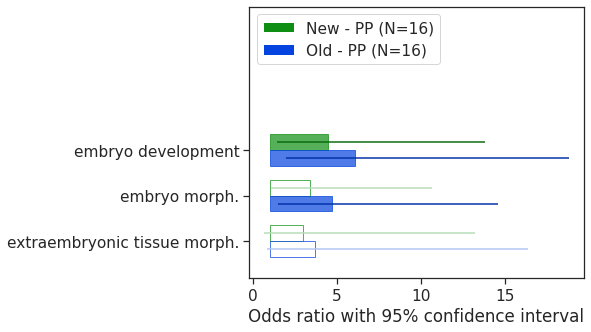

In [463]:
a = plot_hbar_comparison(all_results.loc[all_results.observed>=2], communities=["C889", "C889_old"], mps="MP:0005380",horz=6, vert=5, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - PP", "Old - PP"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005380 embryo phenotype


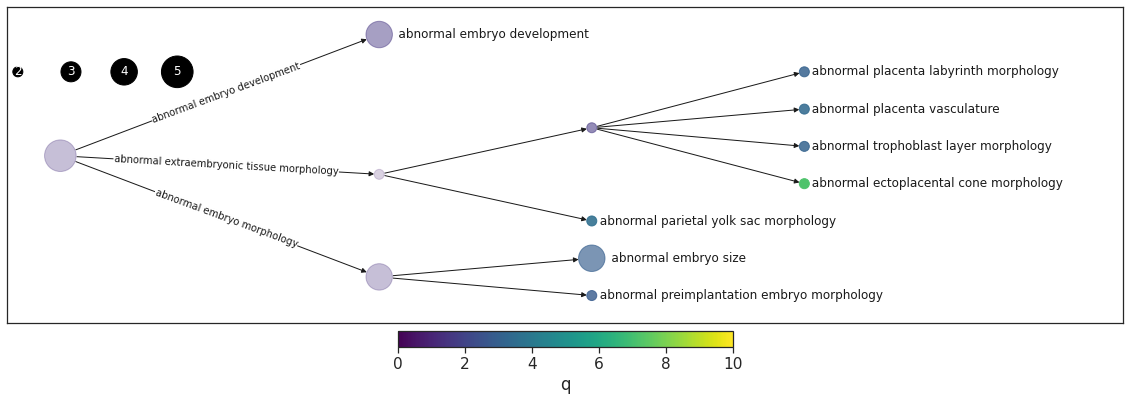

no hits passing filters


In [466]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C889", "MP:0005380", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="hypergeom", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)
get_hits(n, results, p=0.1, OR=2, obs_min=2, total=1000, level=2)

### Growth/body size

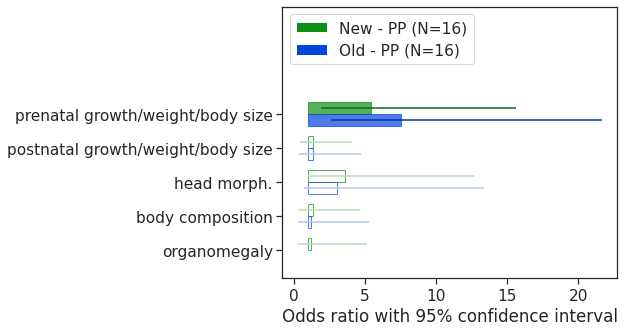

In [449]:
a = plot_hbar_comparison(all_results.loc[all_results.observed>=2], communities=["C889", "C889_old"], mps="MP:0005378",horz=6, vert=5, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - PP", "Old - PP"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005378 growth/size/body region phenotype


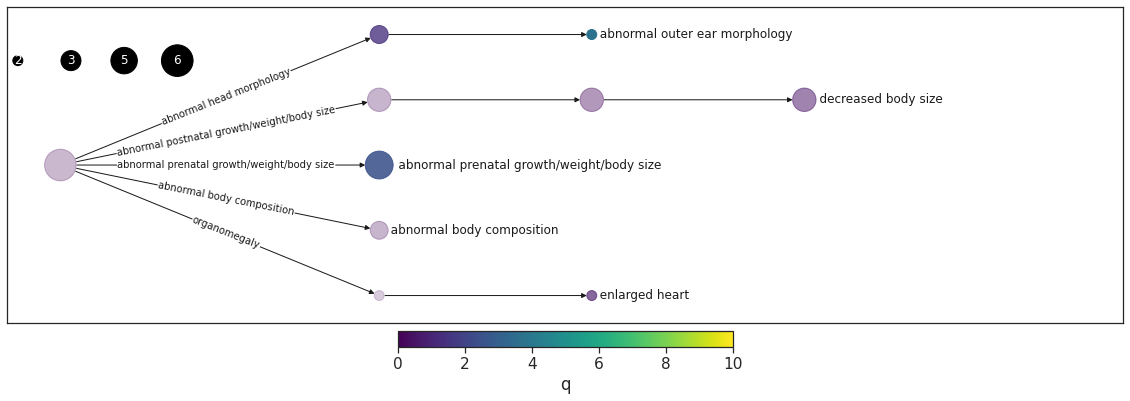

no hits passing filters


In [455]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C889", "MP:0005378", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="hypergeom", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)
get_hits(n, results, p=0.1, OR=2, obs_min=2, total=1000, level=2)

## RPA/C909

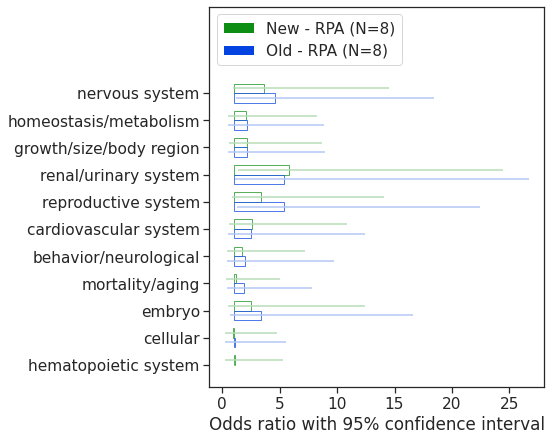

In [408]:
a = plot_hbar_comparison(all_results[all_results.observed>=2], communities=["C909", "C909_old"], mps=top_level, horz=6, vert = 7,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - RPA", "Old - RPA"], sort_by="observed", 
                         label_number="percent_community", correct_by_community=False)

PARENT: MP:0000001 mammalian phenotype


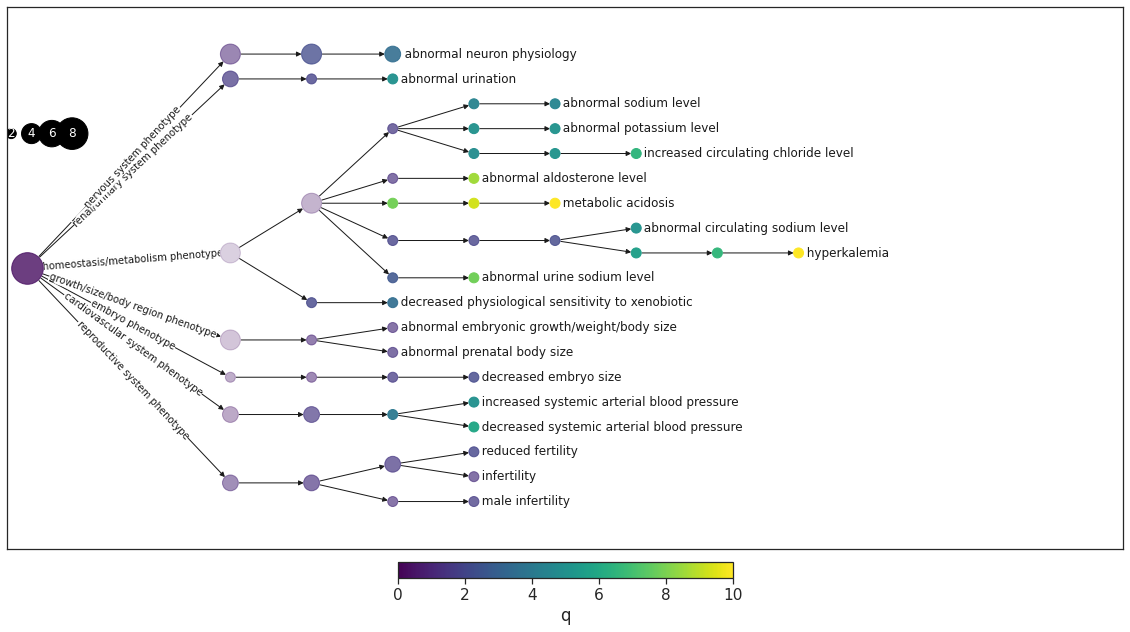

no hits passing filters


In [542]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C909", "MP:0000001", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="ppv", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=12, label="leaf", 
                                descriptive_labels=True, adjust_root=0.3)
get_hits(n, results, p=0.01, OR=2, obs_min=3, total=1000, level=2)

### Nervous System

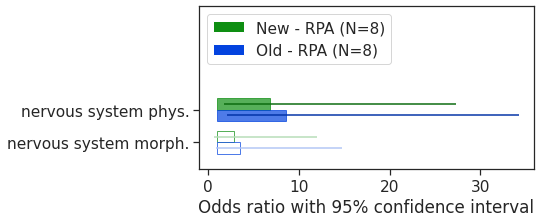

In [411]:
a = plot_hbar_comparison(all_results[all_results.observed>=2], communities=["C909", "C909_old"], mps="MP:0003631", horz=6, vert = 3,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - RPA", "Old - RPA"], sort_by="observed", label_number="percent_community")

PARENT: MP:0003631 nervous system phenotype


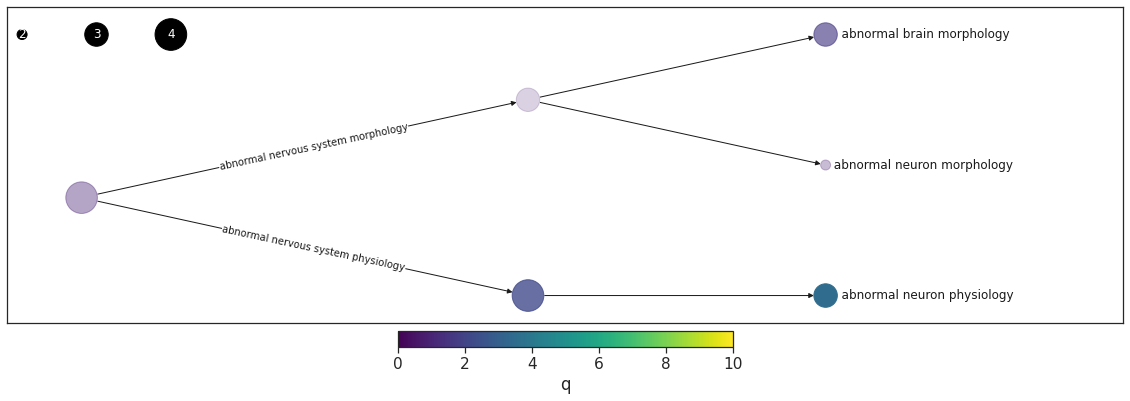

no hits passing filters


In [417]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C909", "MP:0003631", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="hypergeom", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)
get_hits(n, results, p=0.01, OR=2, obs_min=3, total=1000, level=2)

In [418]:
n

OR         q  obs                        hits
MP:0003631   3.622113  0.986198    4  [NUMBL, LMTK3, AATK, WNK1]
MP:0003633   6.831807  2.180274    4  [NUMBL, LMTK3, AATK, WNK1]
MP:0004811  13.964129  3.506668    3        [NUMBL, LMTK3, AATK]
MP:0003632   2.870849  0.806640    3         [NUMBL, AATK, WNK1]
MP:0002882   3.185559  0.806640    2               [NUMBL, AATK]
MP:0002152   5.012730  1.562663    3         [NUMBL, AATK, WNK1]

In [423]:
n

OR         q  obs                         hits
MP:0005376    2.053400  0.510011    4  [LMTK3, ANGEL1, WNK4, WNK1]
MP:0008872    8.209809  1.999906    2                 [WNK4, WNK1]
MP:0001764    2.423476  0.609314    4  [LMTK3, ANGEL1, WNK4, WNK1]
MP:0009643   11.520479  2.553114    2                 [WNK4, WNK1]
MP:0006274  107.781609  7.817431    2                 [WNK4, WNK1]
MP:0005636    7.505000  1.864625    2                 [WNK4, WNK1]
MP:0004043  109.678363  7.867710    2                 [WNK4, WNK1]
MP:0003953    5.077078  1.330175    2                 [WNK4, WNK1]
MP:0011415  139.014815  8.558626    2                 [WNK4, WNK1]
MP:0001765    6.178262  1.587561    2                 [WNK4, WNK1]
MP:0012007   34.895131  4.831091    2                 [WNK4, WNK1]
MP:0011978   37.902439  5.028957    2                 [WNK4, WNK1]
MP:0011977   29.245283  4.420903    2                 [WNK4, WNK1]

### Homestasis/Metabolism

### Growth/body size

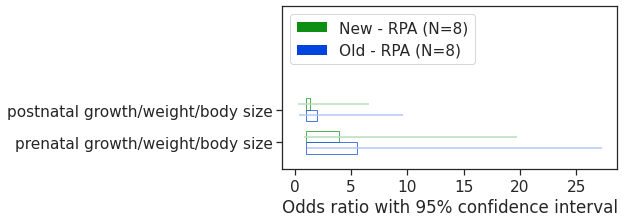

In [424]:
a = plot_hbar_comparison(all_results[all_results.observed>=2], communities=["C909", "C909_old"], mps="MP:0005378", horz=6, vert = 3,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - RPA", "Old - RPA"], sort_by="observed", label_number="percent_community")

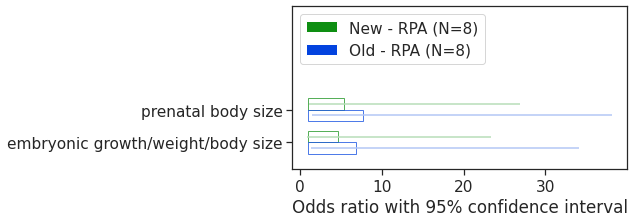

In [426]:
a = plot_hbar_comparison(all_results[all_results.observed>=2], communities=["C909", "C909_old"], mps="MP:0004196", horz=6, vert = 3,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - RPA", "Old - RPA"], sort_by="observed", label_number="percent_community")

PARENT: MP:0004196 abnormal prenatal growth/weight/body size


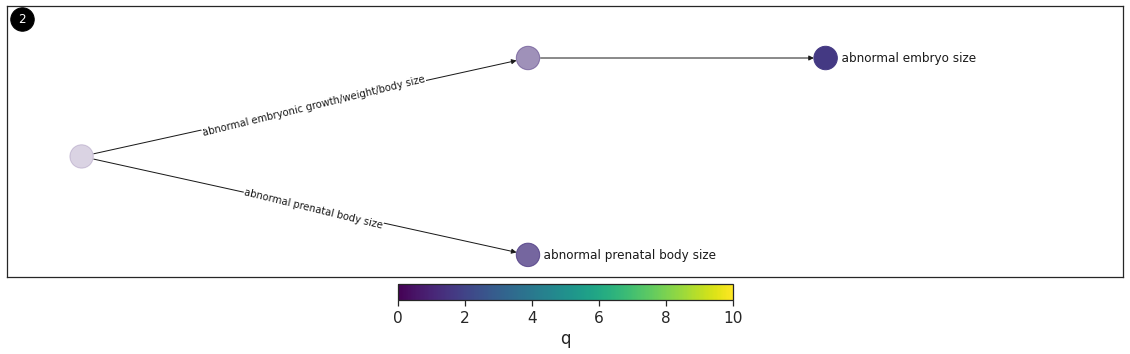

no hits passing filters


In [427]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C909", "MP:0004196", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="hypergeom", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=6, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)
get_hits(n, results, p=0.01, OR=2, obs_min=3, total=1000, level=2)

In [428]:
n

OR         q  obs           hits
MP:0004196  3.976403  1.040521    2  [NUMBL, WNK1]
MP:0010866  5.419572  1.413311    2  [NUMBL, WNK1]
MP:0002088  4.715513  1.239030    2  [NUMBL, WNK1]
MP:0001697  6.527352  1.663615    2  [NUMBL, WNK1]

### Renal/Urinary

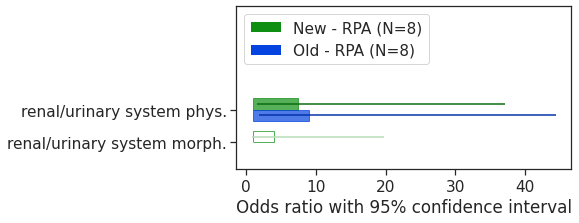

In [536]:
a = plot_hbar_comparison(all_results[all_results.observed>=2], communities=["C909", "C909_old"], mps="MP:0005367", horz=6, vert = 3,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["New - RPA", "Old - RPA"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005367 renal/urinary system phenotype


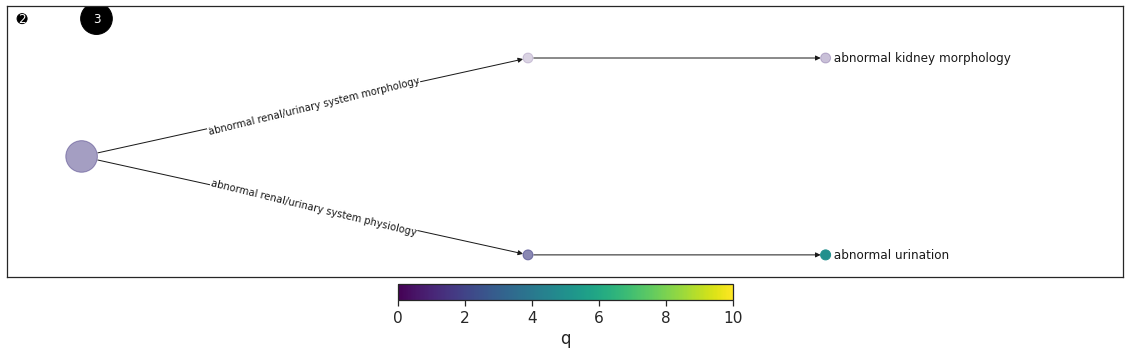

no hits passing filters


In [537]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C909", "MP:0005367", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="hypergeom", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=6, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)
get_hits(n, results, p=0.01, OR=2, obs_min=3, total=1000, level=2)

# __ Not updated ___ Results

## Prenatal - DM1/PP/RPA

In [85]:
prenatal = [10866, 1697]
cell = [5076, 13202, 12555]
nervous = [3861, 2152, 4811]
cardio = [1614, 2925]
#repro = [1925,2161 ]
ag = [10770, 8762]
neo = [2019]
#digestive = [10155]
embryonic = [2085, 1672]
#homestasis = [1764]
#urinary = [1756]
prenatal_terms = prenatal + cell + ag + nervous + cardio + neo +embryonic
prenatal_terms = [num_to_mp(term) for term in prenatal_terms]

prenatal_groups = [1,1] + [0]*3 + [1,1] + [0]*3 + [1,1]+[0]+[1,1,]


In [87]:
print(prenatal_terms)

['MP:0010866', 'MP:0001697', 'MP:0005076', 'MP:0013202', 'MP:0012555', 'MP:0010770', 'MP:0008762', 'MP:0003861', 'MP:0002152', 'MP:0004811', 'MP:0001614', 'MP:0002925', 'MP:0002019', 'MP:0002085', 'MP:0001672']


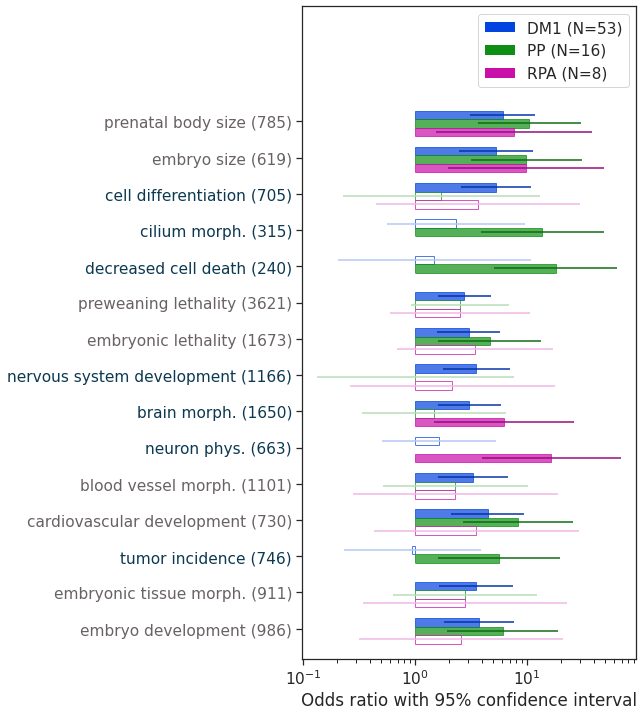

In [668]:
_, ax = plot_hbar_comparison(all_results, communities=["C882", "C889", "C909"], mps=prenatal_terms, sig_level=0.05, 
                         community_names=["DM1", "PP", "RPA"], sort_by=None, 
                         label_number="total", vert=12, color_idx=[1,0,4] , mp_graph=None, horz=6, save=True,
                            ylabel_groups=prenatal_groups)


## Postnatal - GSR/MSC

In [88]:
size = [1259, 1265, 1264,  1256, 12321]
homestasis = [5164, 9642, 3953, 2078]
exo = [13561, 13560, 13558]
behavior = [2069, 14114, 2067]
nervous = [8946]
immune = [2723]
muscleP = [5330, 5620]
muscleM = [2269,4087, 759 ]
cardio = [4215, 2972, 10630, 266]
postnatal_terms = size+ homestasis + exo + behavior + nervous + immune + muscleP + muscleM + cardio
postnatal_terms = [num_to_mp(term) for term in postnatal_terms]

postnatal_groups = [1]*5 + [0]*4 + [1]*3 + [0]*3 + [1,0,1,1] + [0]*3 + [1] *4

In [89]:
print(postnatal_terms)

['MP:0001259', 'MP:0001265', 'MP:0001264', 'MP:0001256', 'MP:0012321', 'MP:0005164', 'MP:0009642', 'MP:0003953', 'MP:0002078', 'MP:0013561', 'MP:0013560', 'MP:0013558', 'MP:0002069', 'MP:0014114', 'MP:0002067', 'MP:0008946', 'MP:0002723', 'MP:0005330', 'MP:0005620', 'MP:0002269', 'MP:0004087', 'MP:0000759', 'MP:0004215', 'MP:0002972', 'MP:0010630', 'MP:0000266']


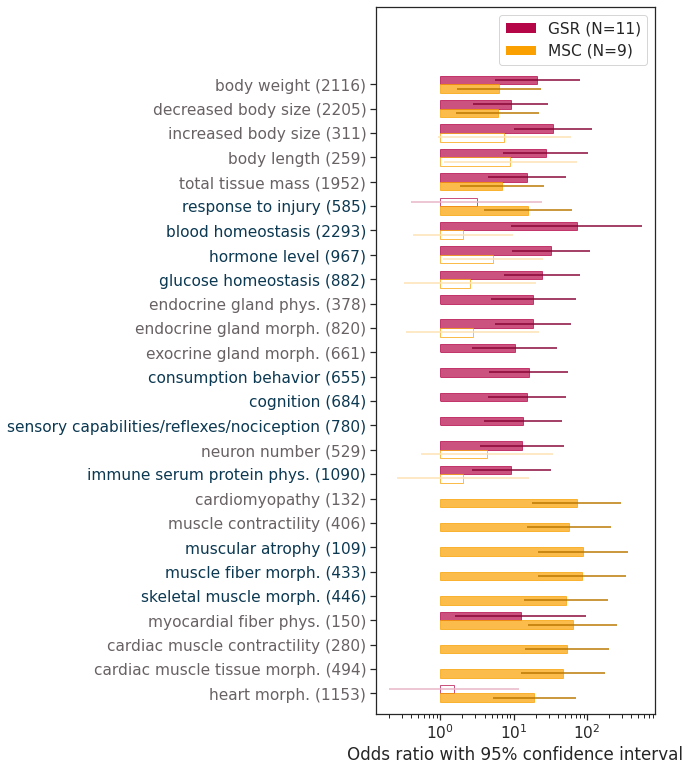

In [484]:
_, ax = plot_hbar_comparison(all_results, communities=["C894", "C907"], mps=postnatal_terms, sig_level=0.05, 
                         community_names=["GSR", "MSC"], sort_by=None, 
                         label_number="total", vert=13, color_idx=[3,2], mp_graph=None, horz=5, save=True,
                            ylabel_groups = postnatal_groups)


In [680]:
results.loc[num_to_mp(5376)]

observed   total         OR      OR_p  OR_CI_lower  OR_CI_upper  \
MP:0005376     160.0  4161.0   1.176220  0.080878     0.980267     1.411344   
MP:0005376       1.0  4161.0   0.352139  0.319728     0.045065     2.751615   
MP:0005376       3.0  4161.0   1.510204  0.550370     0.390356     5.842664   
MP:0005376       3.0  4161.0   1.762025  0.423216     0.440490     7.048363   
MP:0005376       1.0  4161.0   0.587059  0.621975     0.070657     4.877602   
MP:0005376       3.0  4161.0   2.643398  0.203233     0.591391    11.815457   
MP:0005376       2.0  4161.0   1.409377  0.681769     0.273340     7.266923   
MP:0005376       1.0  4161.0   0.704519  0.749209     0.082286     6.031944   
MP:0005376       1.0  4161.0   0.880709  0.909552     0.098411     7.881742   
MP:0005376       1.0  4161.0   0.880709  0.909552     0.098411     7.881742   
MP:0005376       1.0  4161.0   0.880709  0.909552     0.098411     7.881742   
MP:0005376       2.0  4161.0   2.349283  0.349553     0.392423    14.064242   
MP:0005376       2.0  4161.0   3.524164  0.207868     0.496276    25.025863   
MP:0005376       2.0  4161.0   3.524164  0.207868     0.496276    25.025863   
MP:0005376      60.0  4161.0   1.378029  0.036356     1.020580     1.860673   
MP:0005376      20.0  4161.0   0.511954  0.005280     0.319834     0.819476   
MP:0005376      18.0  4161.0   1.815331  0.040171     1.027102     3.208469   
MP:0005376       7.0  4161.0   1.027574  0.949553     0.442449     2.386510   
MP:0005376       1.0  4161.0   0.219997  0.141909     0.029167     1.659368   
MP:0005376       2.0  4161.0   0.469472  0.315278     0.107318     2.053739   
MP:0005376       5.0  4161.0   1.602065  0.382479     0.556330     4.613471   
MP:0005376       2.0  4161.0   0.541772  0.419829     0.122211     2.401727   
MP:0005376       5.0  4161.0   1.958347  0.228445     0.655959     5.846591   
MP:0005376       1.0  4161.0   0.352139  0.319728     0.045065     2.751615   
MP:0005376      10.0  4161.0   1.469024  0.307395     0.701938     3.074389   
MP:0005376      47.0  4161.0   1.361283  0.073918     0.970610     1.909203   
MP:0005376       1.0  4161.0   0.880709  0.909552     0.098411     7.881742   
MP:0005376       4.0  4161.0   2.349932  0.185796     0.662832     8.331191   
MP:0005376       1.0  4161.0   0.391293  0.373452     0.049560     3.089382   
MP:0005376       6.0  4161.0   7.054633  0.005744     1.763592    28.219590   
MP:0005376       3.0  4161.0   2.114574  0.305310     0.505142     8.851820   
MP:0005376       6.0  4161.0   0.812719  0.647300     0.334296     1.975827   
MP:0005376       3.0  4161.0   0.960777  0.951033     0.267917     3.445441   
MP:0005376      10.0  4161.0  35.311973  0.000679     4.519068   275.927590   
MP:0005376       1.0  4161.0   0.391293  0.373452     0.049560     3.089382   
MP:0005376      13.0  4161.0   0.832173  0.552009     0.454239     1.524556   
MP:0005376       2.0  4161.0   1.409377  0.681769     0.273340     7.266923   
MP:0005376       2.0  4161.0   1.761842  0.513214     0.322592     9.622341   
MP:0005376       3.0  4161.0   2.643398  0.203233     0.591391    11.815457   
MP:0005376       2.0  4161.0   1.761842  0.513214     0.322592     9.622341   
MP:0005376       9.0  4161.0   1.763126  0.165201     0.791516     3.927418   
MP:0005376       2.0  4161.0   1.409377  0.681769     0.273340     7.266923   
MP:0005376       2.0  4161.0   0.782774  0.754119     0.169065     3.624258   
MP:0005376       1.0  4161.0   0.251459  0.182377     0.033057     1.912812   
MP:0005376       3.0  4161.0   2.114574  0.305310     0.505142     8.851820   
MP:0005376       4.0  4161.0   2.349932  0.185796     0.662832     8.331191   
MP:0005376       1.0  4161.0   0.880709  0.909552     0.098411     7.881742   
MP:0005376       2.0  4161.0   1.409377  0.681769     0.273340     7.266923   
MP:0005376       1.0  4161.0   0.880709  0.909552     0.098411     7.881742   

                 hyper_p  sig_5e6                       descr

## Full Heatmap

In [93]:
## All prenatal
prenatal = [1697,10866 ]
cell = [5076, 313]
nervous1 = [4811, 2152]
cardio1 = [2925]
#repro = [1925,2161 ]
ag = [8762,10770]
neo = [2019]
#digestive = [10155]
embryonic = [1672,2085 ]

In [94]:
# All postnatal
#size = [1259, 1256, 1265, 1264]
size = [3956, 5451]
homeostasis = [5164, 3953, 2078]
exo = [13560,13561 , 13558]
behavior = [2069, 14114, 2067]
nervous2 = [8946]
immune = [2723]
muscle = [4087, 759,5620, 2269]
cardio2 = [266,10630,  4215]

In [95]:
growth = prenatal + size
cell = cell
nervous = nervous2 + nervous1
cardio = cardio1+cardio2
ag = ag
neo = neo
embryonic = embryonic
all_terms = []
groups = []
group_id = 0
for group in [growth , cell, embryonic , ag ,  cardio, muscle,
              homeostasis , exo ,neo,  behavior,nervous]:
    all_terms += [num_to_mp(term) for term in group]
    groups += [group_id]*len(group)
    if group_id == 1:
        group_id = 0
    else:
        group_id = 1

ValueError: too many values to unpack (expected 2)

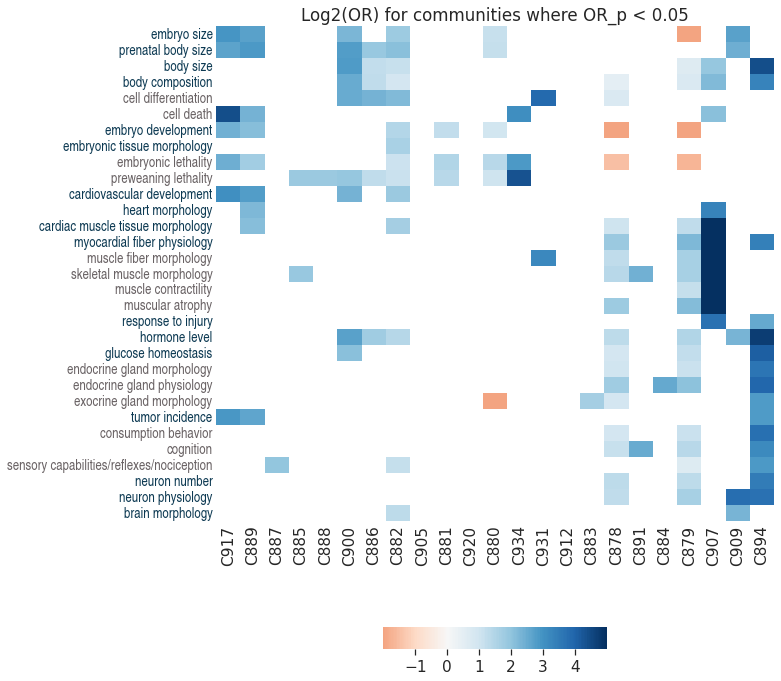

In [96]:
a, b  = plot_community_heatmap(results, all_terms, node_list, new_annotations, stat="OR", filter_stat="OR_p", MPO=MPO2,
                             ylabel_groups = groups, color_range = [-2, 0, 5], vert=13, horz = 10)

ValueError: too many values to unpack (expected 2)

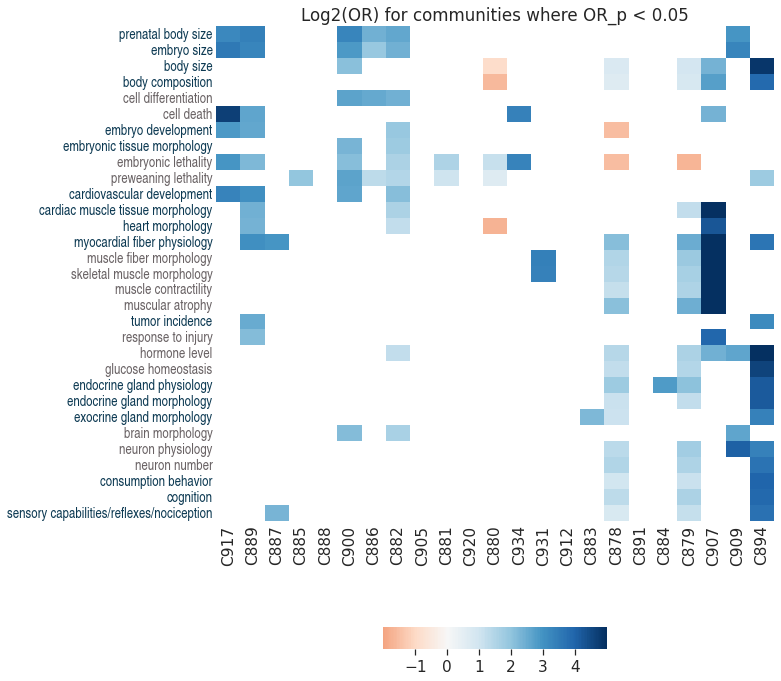

In [149]:
a, b  = plot_community_heatmap(results, all_terms, node_list, new_annotations, stat="OR", filter_stat="OR_p", MPO=MPO2,
                             ylabel_groups = groups, color_range = [-2, 0, 5], vert=13, horz = 10)

In [33]:
new_node_list = [900, 886, 882,917, 889, 885, 888, 920, 905, 881, 880, 934, 931, 887, 
                 912,  883, 878, 891, 884, 879, 909, 907, 894]
new_node_list = ["C" + str(node) for node in new_node_list]

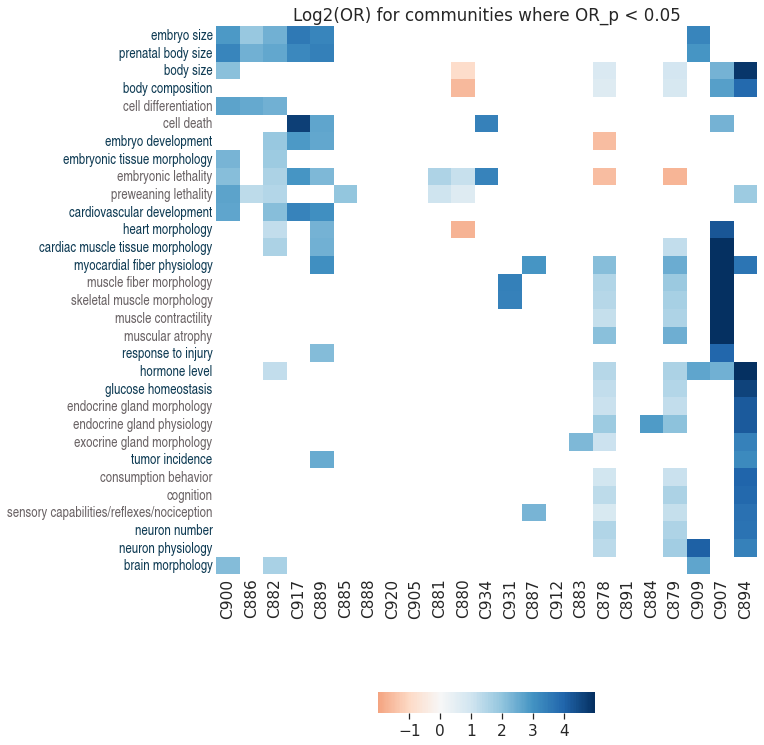

In [173]:
a  = plot_community_heatmap(results, all_terms, new_node_list, new_annotations, stat="OR", filter_stat="OR_p", MPO=MPO2,
                             ylabel_groups = groups, color_range = [-2, 0, 5], vert=14.4, horz=9.7)

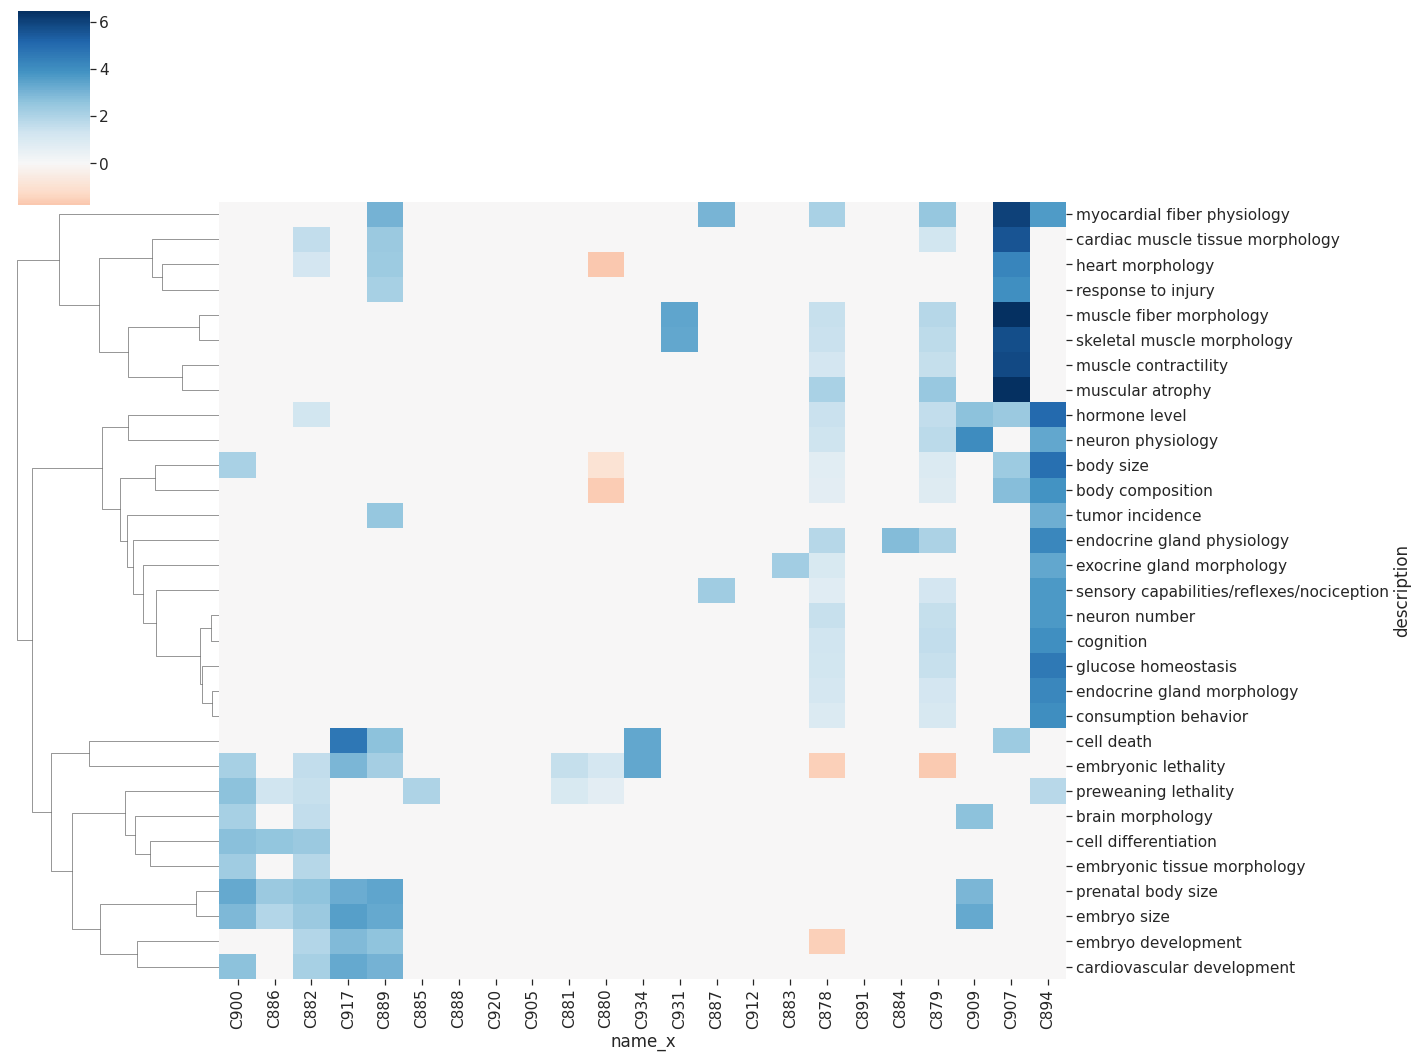

In [147]:
a2 = np.log2(a)
sns.clustermap(a2.fillna(0), method = "average", col_cluster=False, cmap="RdBu", center=0, figsize=(20,15))

# Testing

In [214]:
import matplotlib
matplotlib.get_cachedir()

'/cellar/users/snwright/.cache/matplotlib'

In [224]:
%%bash
less /cellar/users/snwright/.cache/matplotlib/fontlist-v330.json


{
  "_version": 330,
  "_FontManager__default_weight": "normal",
  "default_size": null,
  "defaultFamily": {
    "ttf": "DejaVu Sans",
    "afm": "Helvetica"
  },
  "afmlist": [
    {
      "fname": "fonts/pdfcorefonts/Courier-Bold.afm",
      "name": "Courier",
      "style": "normal",
      "variant": "normal",
      "weight": "bold",
      "stretch": "normal",
      "size": "scalable",
      "__class__": "FontEntry"
    },
    {
      "fname": "fonts/afm/cmex10.afm",
      "name": "Computer Modern",
      "style": "normal",
      "variant": "normal",
      "weight": "medium",
      "stretch": "normal",
      "size": "scalable",
      "__class__": "FontEntry"
    },
    {
      "fname": "fonts/afm/cmr10.afm",
      "name": "Computer Modern",
      "style": "normal",
      "variant": "normal",
      "weight": "medium",
      "stretch": "normal",
      "size": "scalable",
      "__class__": "FontEntry"
    },
    {
      "fname": "fonts/pdfcorefonts/Courier-Oblique.afm",
      "name":

In [1]:
from matplotlib import font_manager
font_manager.findSystemFonts(fontpaths=None, fontext="ttf")

['/usr/share/fonts/urw-base35/NimbusSans-Bold.otf',
 '/usr/share/fonts/urw-base35/P052-Roman.otf',
 '/usr/share/fonts/urw-base35/C059-BdIta.otf',
 '/usr/share/fonts/dejavu/DejaVuSansMono-BoldOblique.ttf',
 '/usr/share/fonts/google-droid/DroidSansDevanagari-Regular.ttf',
 '/usr/share/fonts/liberation-mono/LiberationMono-BoldItalic.ttf',
 '/usr/share/fonts/google-droid/DroidSansArmenian.ttf',
 '/usr/share/fonts/urw-base35/C059-Italic.otf',
 '/usr/share/fonts/urw-base35/NimbusRoman-Bold.otf',
 '/usr/share/fonts/urw-base35/NimbusRoman-Regular.otf',
 '/usr/share/fonts/dejavu/DejaVuSans-ExtraLight.ttf',
 '/usr/share/fonts/dejavu/DejaVuSansCondensed-Bold.ttf',
 '/usr/share/fonts/google-droid/DroidSansJapanese.ttf',
 '/usr/share/fonts/urw-base35/NimbusSans-BoldItalic.otf',
 '/usr/share/fonts/google-droid/DroidSansGeorgian.ttf',
 '/usr/share/fonts/google-droid/DroidSansTamil-Bold.ttf',
 '/usr/share/fonts/liberation-mono/LiberationMono-Italic.ttf',
 '/usr/share/fonts/dejavu/DejaVuSansMono-Bold.t

In [28]:
font_manager.findfont("Nimbus Sans Narrow")

'/usr/share/fonts/urw-base35/NimbusSansNarrow-Regular.otf'

In [97]:
from scipy.cluster.hierarchy import optimal_leaf_ordering
from scipy.cluster.hierarchy import dendrogram, linkage

In [100]:
X = [[i] for i in [2, 8, 0, 4, 1, 9, 9, 0]]
Z = linkage(X, 'single')

In [103]:
Z

array([[ 2.,  7.,  0.,  2.],
       [ 5.,  6.,  0.,  2.],
       [ 0.,  4.,  1.,  2.],
       [ 8., 10.,  1.,  4.],
       [ 1.,  9.,  1.,  3.],
       [ 3., 11.,  2.,  5.],
       [12., 13.,  4.,  8.]])

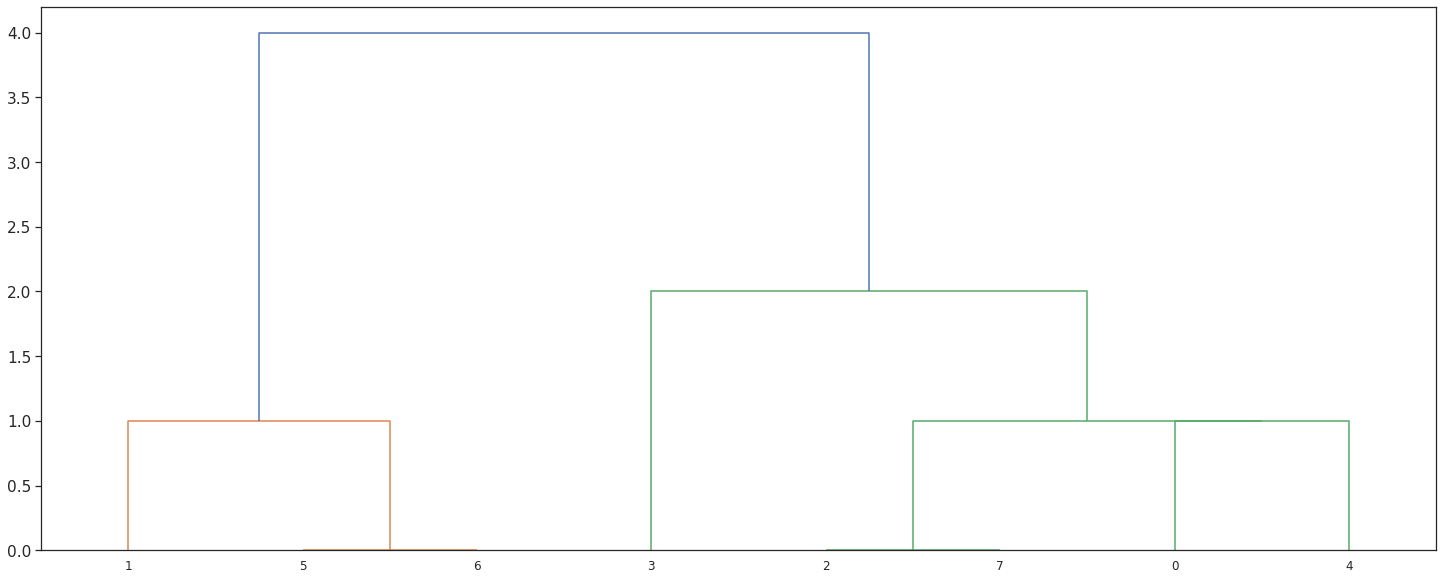

In [102]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()